In [ ]:
!pip install torchmultimodal-nightly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_c

In [ ]:
import torch
import torchvision
import torchvision.transforms.functional as F

from torch import nn
from tqdm import tqdm
from torchmultimodal.diffusion_labs.modules.adapters.cfguidance import CFGuidance
from torchmultimodal.diffusion_labs.modules.losses.diffusion_hybrid_loss import DiffusionHybridLoss
from torchmultimodal.diffusion_labs.samplers.ddpm import DDPModule
from torchmultimodal.diffusion_labs.predictors.noise_predictor import NoisePredictor
from torchmultimodal.diffusion_labs.schedules.discrete_gaussian_schedule import linear_beta_schedule, DiscreteGaussianSchedule
from torchmultimodal.diffusion_labs.transforms.diffusion_transform import RandomDiffusionSteps
from torchmultimodal.diffusion_labs.utils.common import DiffusionOutput

In [ ]:

schedule= DiscreteGaussianSchedule(linear_beta_schedule(1000))

In [ ]:

predictor=NoisePredictor(schedule,lambda x: torch.clamp(x,-1,1))
print("yes")

yes


In [ ]:

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, cond_channels):
        super().__init__()
        self.block = nn.Sequential(
        nn.Conv2d(in_channels+cond_channels,out_channels,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
        nn.ReLU(),
        )
        self.pooling = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x, c):
        _, _, w, h = x.size()
        c = c.expand(-1, -1, w, h)
        x = self.block(torch.cat([x, c], 1))
        x_small = self.pooling(x)
        return x, x_small


class UpBlock(nn.Module):
    def __init__(self, inp, out):
        super().__init__()
        self.block = nn.Sequential(
        nn.Conv2d(2*inp,out,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out,out,kernel_size=3,padding=1),
        nn.ReLU(),
        )
        self.upsample = nn.Upsample(scale_factor=2)

    def forward(self, x, x_small):
        x_big = self.upsample(x_small)
        x = torch.cat((x_big, x), dim=1)
        x = self.block(x)
        return x

class UNet(nn.Module):
    def __init__(self, time_size=32, digit_size=32, steps=1000):
        super().__init__()
        # Define UNet
        cond_size=time_size+digit_size
        self.conv=nn.Conv2d(1,128,kernel_size=3,padding=1)
        self.down=nn.ModuleList([DownBlock(128,256,cond_size),DownBlock(256,512,cond_size)])
        self.bottleneck=DownBlock(512,512,cond_size)
        self.up=nn.ModuleList([UpBlock(512,256),UpBlock(256,128)])
        self.time_projection=nn.Embedding(steps,time_size)
        self.prediction = nn.Conv2d(128,1,kernel_size=3,padding=1)
        self.variance=nn.Conv2d(128,1,kernel_size=3,padding=1)

    def forward(self, x, t, conditional_inputs):
        # Define forward
        b,c,h,w=x.shape
        timestep=self.time_projection(t).view(b,-1,1,1)
        condition=conditional_inputs["context"].view(b,-1,1,1)
        condition=torch.cat([timestep,condition],dim=1)
        outs=[]
        x=self.conv(x)
        for block in self.down:
            out,x=block(x,condition)
            outs.append(out)
        x,_=self.bottleneck(x,condition)
        for block in self.up:
            x=block(outs.pop(),x)
        v=self.variance(x)
        p=self.prediction(x)
        return DiffusionOutput(p,v)
print("Completed")

Completed


In [ ]:
unet = UNet(time_size=32, digit_size=32)
unet=CFGuidance(unet,{"context":32},guidance=2.0)
# Add support for classifier free guidance

In [ ]:

eval_steps=torch.linspace(0,999,250,dtype=torch.long)
model = DDPModule(unet, schedule, predictor, eval_steps)
print("Complete")

Complete


In [ ]:

encoder=nn.Embedding(10,32)

In [ ]:
from torchvision.transforms import Compose, Resize, ToTensor, Lambda
diffusion_transforms=RandomDiffusionSteps(schedule,batched=False)
transform=Compose([Resize(32),ToTensor(),Lambda(lambda x:2*x-1),Lambda(lambda x:diffusion_transforms({"x":x}))])
print("Complete")




Complete


In [ ]:
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader

train_dataset = FashionMNIST("fashion_mnist", train=True, download=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=192, shuffle=True, num_workers=2, pin_memory=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 10369462.12it/s]


Extracting fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 201193.04it/s]


Extracting fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 1991710.65it/s]


Extracting fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19955893.71it/s]

Extracting fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



In [ ]:
epochs = 25

device = "cuda"
encoder.to(device)
model.to(device)

# Apply optimizer to diffusion model and encoder for joint training
optimizer = torch.optim.AdamW(
    [{"params": encoder.parameters()}, {"params": model.parameters()}], lr=0.0001
)
# Define loss
h_loss = DiffusionHybridLoss(schedule)

encoder.train()
model.train()
for e in range(epochs):
    for sample in (pbar := tqdm(train_dataloader)):
        x, c = sample
        x0, xt, noise, t, c = x["x"].to(device), x["xt"].to(device), x["noise"].to(device), x["t"].to(device), c.to(device)
        optimizer.zero_grad()


        # Compute loss
        embedding = encoder(c)
        print(type(embedding))
        out = model(xt, t, {"context": embedding})  # Pass embedding as a dictionary
        loss = h_loss(out.prediction, noise, out.mean, out.log_variance, x0, xt, t)

        loss.backward()
        optimizer.step()

        pbar.set_description(f'{e+1}| Loss: {loss.item()}')

  0%|          | 0/313 [00:00<?, ?it/s]

<class 'torch.Tensor'>


1| Loss: 0.042355671525001526:   0%|          | 1/313 [00:00<03:52,  1.34it/s]

<class 'torch.Tensor'>


1| Loss: 0.8147119879722595:   1%|          | 2/313 [00:01<03:00,  1.72it/s]

<class 'torch.Tensor'>


1| Loss: 0.09499292075634003:   1%|          | 3/313 [00:01<02:44,  1.89it/s]

<class 'torch.Tensor'>


1| Loss: 0.1516110897064209:   1%|▏         | 4/313 [00:02<02:36,  1.98it/s]

<class 'torch.Tensor'>


1| Loss: 0.21693609654903412:   2%|▏         | 5/313 [00:02<02:32,  2.02it/s]

<class 'torch.Tensor'>


1| Loss: 0.18900203704833984:   2%|▏         | 6/313 [00:03<02:29,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.16841453313827515:   2%|▏         | 7/313 [00:03<02:26,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.1347358673810959:   3%|▎         | 8/313 [00:04<02:25,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.14926284551620483:   3%|▎         | 9/313 [00:04<02:25,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.14308999478816986:   3%|▎         | 10/313 [00:04<02:25,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.13863418996334076:   4%|▎         | 11/313 [00:05<02:24,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.13767500221729279:   4%|▍         | 12/313 [00:05<02:24,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.11142558604478836:   4%|▍         | 13/313 [00:06<02:24,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.12930667400360107:   4%|▍         | 14/313 [00:06<02:22,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.13914136588573456:   5%|▍         | 15/313 [00:07<02:22,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.13780373334884644:   5%|▌         | 16/313 [00:07<02:21,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.16453368961811066:   5%|▌         | 17/313 [00:08<02:20,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.1190231516957283:   6%|▌         | 18/313 [00:08<02:19,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.12311374396085739:   6%|▌         | 19/313 [00:09<02:19,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.12483391910791397:   6%|▋         | 20/313 [00:09<02:18,  2.12it/s]

<class 'torch.Tensor'>


1| Loss: 0.11308261007070541:   7%|▋         | 21/313 [00:10<02:18,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.11997463554143906:   7%|▋         | 22/313 [00:10<02:17,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.10475291311740875:   7%|▋         | 23/313 [00:11<02:16,  2.12it/s]

<class 'torch.Tensor'>


1| Loss: 0.11683014035224915:   8%|▊         | 24/313 [00:11<02:16,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.12016556411981583:   8%|▊         | 25/313 [00:12<02:16,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.11117807775735855:   8%|▊         | 26/313 [00:12<02:15,  2.12it/s]

<class 'torch.Tensor'>


1| Loss: 0.10353903472423553:   9%|▊         | 27/313 [00:13<02:15,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.09325504302978516:   9%|▉         | 28/313 [00:13<02:14,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.09669645875692368:   9%|▉         | 29/313 [00:14<02:15,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.10584762692451477:  10%|▉         | 30/313 [00:14<02:15,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.12766075134277344:  10%|▉         | 31/313 [00:14<02:14,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.09778111428022385:  10%|█         | 32/313 [00:15<02:14,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.09456299245357513:  11%|█         | 33/313 [00:15<02:14,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.11361709982156754:  11%|█         | 34/313 [00:16<02:13,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.11618860065937042:  11%|█         | 35/313 [00:16<02:13,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.10349887609481812:  12%|█▏        | 36/313 [00:17<02:13,  2.07it/s]

<class 'torch.Tensor'>


1| Loss: 0.10785931348800659:  12%|█▏        | 37/313 [00:17<02:13,  2.07it/s]

<class 'torch.Tensor'>


1| Loss: 0.10650473833084106:  12%|█▏        | 38/313 [00:18<02:14,  2.04it/s]

<class 'torch.Tensor'>


1| Loss: 0.10417722910642624:  12%|█▏        | 39/313 [00:18<02:13,  2.05it/s]

<class 'torch.Tensor'>


1| Loss: 0.09628729522228241:  13%|█▎        | 40/313 [00:19<02:13,  2.05it/s]

<class 'torch.Tensor'>


1| Loss: 0.11154218763113022:  13%|█▎        | 41/313 [00:19<02:12,  2.05it/s]

<class 'torch.Tensor'>


1| Loss: 0.10765814036130905:  13%|█▎        | 42/313 [00:20<02:11,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.1208488866686821:  14%|█▎        | 43/313 [00:20<02:10,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.10750430077314377:  14%|█▍        | 44/313 [00:21<02:09,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.10143212229013443:  14%|█▍        | 45/313 [00:21<02:09,  2.07it/s]

<class 'torch.Tensor'>


1| Loss: 0.07307372242212296:  15%|█▍        | 46/313 [00:22<02:09,  2.07it/s]

<class 'torch.Tensor'>


1| Loss: 0.10166782885789871:  15%|█▌        | 47/313 [00:22<02:09,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.09954752027988434:  15%|█▌        | 48/313 [00:23<02:08,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.11888975650072098:  16%|█▌        | 49/313 [00:23<02:08,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.09154392033815384:  16%|█▌        | 50/313 [00:24<02:07,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.09396864473819733:  16%|█▋        | 51/313 [00:24<02:07,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.07679570466279984:  17%|█▋        | 52/313 [00:25<02:06,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.09478626400232315:  17%|█▋        | 53/313 [00:25<02:06,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.07947275787591934:  17%|█▋        | 54/313 [00:26<02:05,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.09248099476099014:  18%|█▊        | 55/313 [00:26<02:05,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.12959948182106018:  18%|█▊        | 56/313 [00:27<02:04,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.10375770181417465:  18%|█▊        | 57/313 [00:27<02:04,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.0751166120171547:  19%|█▊        | 58/313 [00:28<02:03,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.09180442988872528:  19%|█▉        | 59/313 [00:28<02:03,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.07446449995040894:  19%|█▉        | 60/313 [00:29<02:03,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.07091990858316422:  19%|█▉        | 61/313 [00:29<02:02,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.0761161744594574:  20%|█▉        | 62/313 [00:30<02:02,  2.05it/s]

<class 'torch.Tensor'>


1| Loss: 0.05801701545715332:  20%|██        | 63/313 [00:30<02:01,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.0925917774438858:  20%|██        | 64/313 [00:30<02:00,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.06948858499526978:  21%|██        | 65/313 [00:31<02:00,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.07950786501169205:  21%|██        | 66/313 [00:31<01:59,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.0612017884850502:  21%|██▏       | 67/313 [00:32<01:59,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.0847044587135315:  22%|██▏       | 68/313 [00:32<01:58,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.0655529722571373:  22%|██▏       | 69/313 [00:33<01:58,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.07104017585515976:  22%|██▏       | 70/313 [00:33<01:57,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.07602947950363159:  23%|██▎       | 71/313 [00:34<01:57,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.08744475990533829:  23%|██▎       | 72/313 [00:34<01:56,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.08349762856960297:  23%|██▎       | 73/313 [00:35<01:56,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.07449503242969513:  24%|██▎       | 74/313 [00:35<01:55,  2.07it/s]

<class 'torch.Tensor'>


1| Loss: 0.06968831270933151:  24%|██▍       | 75/313 [00:36<01:54,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.07629519701004028:  24%|██▍       | 76/313 [00:36<01:54,  2.07it/s]

<class 'torch.Tensor'>


1| Loss: 0.0662226751446724:  25%|██▍       | 77/313 [00:37<01:53,  2.07it/s]

<class 'torch.Tensor'>


1| Loss: 0.06470497697591782:  25%|██▍       | 78/313 [00:37<01:52,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.07641812413930893:  25%|██▌       | 79/313 [00:38<01:52,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.056227125227451324:  26%|██▌       | 80/313 [00:38<01:52,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.05757863074541092:  26%|██▌       | 81/313 [00:39<01:50,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.07252297550439835:  26%|██▌       | 82/313 [00:39<01:50,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.052211470901966095:  27%|██▋       | 83/313 [00:40<01:50,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.05412834882736206:  27%|██▋       | 84/313 [00:40<01:49,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.054492250084877014:  27%|██▋       | 85/313 [00:41<01:49,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.05775659903883934:  27%|██▋       | 86/313 [00:41<01:48,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.06372484564781189:  28%|██▊       | 87/313 [00:42<01:48,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.05960075184702873:  28%|██▊       | 88/313 [00:42<01:48,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.06178330257534981:  28%|██▊       | 89/313 [00:43<01:49,  2.05it/s]

<class 'torch.Tensor'>


1| Loss: 0.06377115100622177:  29%|██▉       | 90/313 [00:43<01:48,  2.05it/s]

<class 'torch.Tensor'>


1| Loss: 0.06302393972873688:  29%|██▉       | 91/313 [00:44<01:48,  2.05it/s]

<class 'torch.Tensor'>


1| Loss: 0.06350986659526825:  29%|██▉       | 92/313 [00:44<01:47,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.053413018584251404:  30%|██▉       | 93/313 [00:44<01:46,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.061904177069664:  30%|███       | 94/313 [00:45<01:45,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.062275756150484085:  30%|███       | 95/313 [00:45<01:44,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.051259845495224:  31%|███       | 96/313 [00:46<01:44,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.04377417638897896:  31%|███       | 97/313 [00:46<01:43,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.06959071755409241:  31%|███▏      | 98/313 [00:47<01:43,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.05440369248390198:  32%|███▏      | 99/313 [00:47<01:41,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.046230852603912354:  32%|███▏      | 100/313 [00:48<01:41,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.05764571949839592:  32%|███▏      | 101/313 [00:48<01:40,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.06238722428679466:  33%|███▎      | 102/313 [00:49<01:40,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.04737909138202667:  33%|███▎      | 103/313 [00:49<01:39,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.0462375245988369:  33%|███▎      | 104/313 [00:50<01:39,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.049936581403017044:  34%|███▎      | 105/313 [00:50<01:38,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.053980328142642975:  34%|███▍      | 106/313 [00:51<01:37,  2.12it/s]

<class 'torch.Tensor'>


1| Loss: 0.05149725452065468:  34%|███▍      | 107/313 [00:51<01:37,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.05052483454346657:  35%|███▍      | 108/313 [00:52<01:37,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.06206739693880081:  35%|███▍      | 109/313 [00:52<01:37,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.047134093940258026:  35%|███▌      | 110/313 [00:53<01:37,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.0627622902393341:  35%|███▌      | 111/313 [00:53<01:37,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.0638962835073471:  36%|███▌      | 112/313 [00:54<01:36,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.05032461881637573:  36%|███▌      | 113/313 [00:54<01:35,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.044074028730392456:  36%|███▋      | 114/313 [00:54<01:35,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.04683997482061386:  37%|███▋      | 115/313 [00:55<01:34,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.03859516605734825:  37%|███▋      | 116/313 [00:55<01:34,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.045935507863759995:  37%|███▋      | 117/313 [00:56<01:34,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.05120411515235901:  38%|███▊      | 118/313 [00:56<01:34,  2.07it/s]

<class 'torch.Tensor'>


1| Loss: 0.0391559898853302:  38%|███▊      | 119/313 [00:57<01:33,  2.07it/s]

<class 'torch.Tensor'>


1| Loss: 0.05397700518369675:  38%|███▊      | 120/313 [00:57<01:32,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.0502493716776371:  39%|███▊      | 121/313 [00:58<01:31,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.05117592588067055:  39%|███▉      | 122/313 [00:58<01:30,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.03815704956650734:  39%|███▉      | 123/313 [00:59<01:30,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.05510657653212547:  40%|███▉      | 124/313 [00:59<01:29,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.05101143568754196:  40%|███▉      | 125/313 [01:00<01:29,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.05801302194595337:  40%|████      | 126/313 [01:00<01:28,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.04290037229657173:  41%|████      | 127/313 [01:01<01:27,  2.12it/s]

<class 'torch.Tensor'>


1| Loss: 0.04181602597236633:  41%|████      | 128/313 [01:01<01:27,  2.12it/s]

<class 'torch.Tensor'>


1| Loss: 0.04796021059155464:  41%|████      | 129/313 [01:02<01:27,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.03995955362915993:  42%|████▏     | 130/313 [01:02<01:26,  2.12it/s]

<class 'torch.Tensor'>


1| Loss: 0.04208198934793472:  42%|████▏     | 131/313 [01:03<01:25,  2.12it/s]

<class 'torch.Tensor'>


1| Loss: 0.05212951824069023:  42%|████▏     | 132/313 [01:03<01:25,  2.12it/s]

<class 'torch.Tensor'>


1| Loss: 0.04713871702551842:  42%|████▏     | 133/313 [01:04<01:25,  2.12it/s]

<class 'torch.Tensor'>


1| Loss: 0.044254153966903687:  43%|████▎     | 134/313 [01:04<01:24,  2.12it/s]

<class 'torch.Tensor'>


1| Loss: 0.0545039139688015:  43%|████▎     | 135/313 [01:04<01:24,  2.12it/s]

<class 'torch.Tensor'>


1| Loss: 0.05988826975226402:  43%|████▎     | 136/313 [01:05<01:23,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.04949098452925682:  44%|████▍     | 137/313 [01:05<01:23,  2.12it/s]

<class 'torch.Tensor'>


1| Loss: 0.051878515630960464:  44%|████▍     | 138/313 [01:06<01:22,  2.12it/s]

<class 'torch.Tensor'>


1| Loss: 0.05056256055831909:  44%|████▍     | 139/313 [01:06<01:22,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.05764232575893402:  45%|████▍     | 140/313 [01:07<01:21,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.04282626882195473:  45%|████▌     | 141/313 [01:07<01:22,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.07113125175237656:  45%|████▌     | 142/313 [01:08<01:21,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.04018286243081093:  46%|████▌     | 143/313 [01:08<01:21,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.03250984102487564:  46%|████▌     | 144/313 [01:09<01:20,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.05163053423166275:  46%|████▋     | 145/313 [01:09<01:19,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.03332550451159477:  47%|████▋     | 146/313 [01:10<01:19,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.044236987829208374:  47%|████▋     | 147/313 [01:10<01:18,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.05140890181064606:  47%|████▋     | 148/313 [01:11<01:18,  2.12it/s]

<class 'torch.Tensor'>


1| Loss: 0.03529762849211693:  48%|████▊     | 149/313 [01:11<01:17,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.03886907547712326:  48%|████▊     | 150/313 [01:12<01:17,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.04897889494895935:  48%|████▊     | 151/313 [01:12<01:16,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.05492875725030899:  49%|████▊     | 152/313 [01:13<01:16,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.04508138820528984:  49%|████▉     | 153/313 [01:13<01:15,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.03666938841342926:  49%|████▉     | 154/313 [01:13<01:14,  2.12it/s]

<class 'torch.Tensor'>


1| Loss: 0.048268258571624756:  50%|████▉     | 155/313 [01:14<01:14,  2.13it/s]

<class 'torch.Tensor'>


1| Loss: 0.04752124100923538:  50%|████▉     | 156/313 [01:14<01:13,  2.12it/s]

<class 'torch.Tensor'>


1| Loss: 0.04542740061879158:  50%|█████     | 157/313 [01:15<01:13,  2.12it/s]

<class 'torch.Tensor'>


1| Loss: 0.04178404062986374:  50%|█████     | 158/313 [01:15<01:13,  2.12it/s]

<class 'torch.Tensor'>


1| Loss: 0.053830720484256744:  51%|█████     | 159/313 [01:16<01:12,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.035750892013311386:  51%|█████     | 160/313 [01:16<01:12,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.04462442919611931:  51%|█████▏    | 161/313 [01:17<01:11,  2.13it/s]

<class 'torch.Tensor'>


1| Loss: 0.05522273853421211:  52%|█████▏    | 162/313 [01:17<01:10,  2.13it/s]

<class 'torch.Tensor'>


1| Loss: 0.044903144240379333:  52%|█████▏    | 163/313 [01:18<01:10,  2.12it/s]

<class 'torch.Tensor'>


1| Loss: 0.04250786826014519:  52%|█████▏    | 164/313 [01:18<01:10,  2.12it/s]

<class 'torch.Tensor'>


1| Loss: 0.04909232258796692:  53%|█████▎    | 165/313 [01:19<01:09,  2.12it/s]

<class 'torch.Tensor'>


1| Loss: 0.049225229769945145:  53%|█████▎    | 166/313 [01:19<01:09,  2.12it/s]

<class 'torch.Tensor'>


1| Loss: 0.034472934901714325:  53%|█████▎    | 167/313 [01:20<01:08,  2.12it/s]

<class 'torch.Tensor'>


1| Loss: 0.04050396382808685:  54%|█████▎    | 168/313 [01:20<01:09,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.038857098668813705:  54%|█████▍    | 169/313 [01:21<01:08,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.03947235643863678:  54%|█████▍    | 170/313 [01:21<01:08,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.0383114330470562:  55%|█████▍    | 171/313 [01:22<01:08,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.05105121433734894:  55%|█████▍    | 172/313 [01:22<01:07,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.03960024565458298:  55%|█████▌    | 173/313 [01:22<01:07,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.05045711249113083:  56%|█████▌    | 174/313 [01:23<01:06,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.05010933056473732:  56%|█████▌    | 175/313 [01:23<01:05,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.0563194565474987:  56%|█████▌    | 176/313 [01:24<01:05,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.03985307365655899:  57%|█████▋    | 177/313 [01:24<01:04,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.04158395901322365:  57%|█████▋    | 178/313 [01:25<01:03,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.0406389981508255:  57%|█████▋    | 179/313 [01:25<01:03,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.041840810328722:  58%|█████▊    | 180/313 [01:26<01:02,  2.12it/s]

<class 'torch.Tensor'>


1| Loss: 0.04988466948270798:  58%|█████▊    | 181/313 [01:26<01:02,  2.12it/s]

<class 'torch.Tensor'>


1| Loss: 0.04399486631155014:  58%|█████▊    | 182/313 [01:27<01:01,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.046779461205005646:  58%|█████▊    | 183/313 [01:27<01:01,  2.12it/s]

<class 'torch.Tensor'>


1| Loss: 0.048790670931339264:  59%|█████▉    | 184/313 [01:28<01:01,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.06619303673505783:  59%|█████▉    | 185/313 [01:28<01:00,  2.12it/s]

<class 'torch.Tensor'>


1| Loss: 0.04247202351689339:  59%|█████▉    | 186/313 [01:29<01:00,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.049086954444646835:  60%|█████▉    | 187/313 [01:29<00:59,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.04305534064769745:  60%|██████    | 188/313 [01:30<00:59,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.05610546097159386:  60%|██████    | 189/313 [01:30<00:58,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.03996936231851578:  61%|██████    | 190/313 [01:31<00:58,  2.12it/s]

<class 'torch.Tensor'>


1| Loss: 0.037963662296533585:  61%|██████    | 191/313 [01:31<00:57,  2.12it/s]

<class 'torch.Tensor'>


1| Loss: 0.03859866037964821:  61%|██████▏   | 192/313 [01:31<00:57,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.04214204102754593:  62%|██████▏   | 193/313 [01:32<00:56,  2.11it/s]

<class 'torch.Tensor'>


1| Loss: 0.034026533365249634:  62%|██████▏   | 194/313 [01:32<00:56,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.04698095843195915:  62%|██████▏   | 195/313 [01:33<00:56,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.045264147222042084:  63%|██████▎   | 196/313 [01:33<00:55,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.055459871888160706:  63%|██████▎   | 197/313 [01:34<00:55,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.037363287061452866:  63%|██████▎   | 198/313 [01:34<00:55,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.04252012446522713:  64%|██████▎   | 199/313 [01:35<00:54,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.042693983763456345:  64%|██████▍   | 200/313 [01:35<00:54,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.042861685156822205:  64%|██████▍   | 201/313 [01:36<00:53,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.0383552722632885:  65%|██████▍   | 202/313 [01:36<00:53,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.04260151833295822:  65%|██████▍   | 203/313 [01:37<00:53,  2.07it/s]

<class 'torch.Tensor'>


1| Loss: 0.037852633744478226:  65%|██████▌   | 204/313 [01:37<00:52,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.0563722625374794:  65%|██████▌   | 205/313 [01:38<00:51,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.045376602560281754:  66%|██████▌   | 206/313 [01:38<00:51,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.03538576140999794:  66%|██████▌   | 207/313 [01:39<00:51,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.048764847218990326:  66%|██████▋   | 208/313 [01:39<00:50,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.038108211010694504:  67%|██████▋   | 209/313 [01:40<00:49,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.04179976135492325:  67%|██████▋   | 210/313 [01:40<00:49,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.044243622571229935:  67%|██████▋   | 211/313 [01:41<00:48,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.05531632900238037:  68%|██████▊   | 212/313 [01:41<00:48,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.05698350444436073:  68%|██████▊   | 213/313 [01:42<00:48,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.04107823595404625:  68%|██████▊   | 214/313 [01:42<00:47,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.038934897631406784:  69%|██████▊   | 215/313 [01:43<00:47,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.043287161737680435:  69%|██████▉   | 216/313 [01:43<00:46,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.04264313355088234:  69%|██████▉   | 217/313 [01:43<00:45,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.04182496294379234:  70%|██████▉   | 218/313 [01:44<00:45,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.03835044056177139:  70%|██████▉   | 219/313 [01:44<00:45,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.046097077429294586:  70%|███████   | 220/313 [01:45<00:44,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.04853197559714317:  71%|███████   | 221/313 [01:45<00:44,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.040462881326675415:  71%|███████   | 222/313 [01:46<00:43,  2.07it/s]

<class 'torch.Tensor'>


1| Loss: 0.03722596541047096:  71%|███████   | 223/313 [01:46<00:43,  2.07it/s]

<class 'torch.Tensor'>


1| Loss: 0.03864182531833649:  72%|███████▏  | 224/313 [01:47<00:43,  2.07it/s]

<class 'torch.Tensor'>


1| Loss: 0.03836230933666229:  72%|███████▏  | 225/313 [01:47<00:42,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.04661080241203308:  72%|███████▏  | 226/313 [01:48<00:42,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.054023366421461105:  73%|███████▎  | 227/313 [01:48<00:41,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.04327249154448509:  73%|███████▎  | 228/313 [01:49<00:41,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.038322899490594864:  73%|███████▎  | 229/313 [01:49<00:40,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.04141117259860039:  73%|███████▎  | 230/313 [01:50<00:40,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.035152021795511246:  74%|███████▍  | 231/313 [01:50<00:39,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.04257621243596077:  74%|███████▍  | 232/313 [01:51<00:38,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.03871355578303337:  74%|███████▍  | 233/313 [01:51<00:38,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.04034806042909622:  75%|███████▍  | 234/313 [01:52<00:37,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.04212924465537071:  75%|███████▌  | 235/313 [01:52<00:37,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.04963870346546173:  75%|███████▌  | 236/313 [01:53<00:36,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.042251452803611755:  76%|███████▌  | 237/313 [01:53<00:36,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.03745851665735245:  76%|███████▌  | 238/313 [01:54<00:35,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.03465022146701813:  76%|███████▋  | 239/313 [01:54<00:35,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.03807123750448227:  77%|███████▋  | 240/313 [01:55<00:35,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.04142846539616585:  77%|███████▋  | 241/313 [01:55<00:34,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.042873091995716095:  77%|███████▋  | 242/313 [01:55<00:33,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.03307539224624634:  78%|███████▊  | 243/313 [01:56<00:33,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.0438530296087265:  78%|███████▊  | 244/313 [01:56<00:32,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.051581863313913345:  78%|███████▊  | 245/313 [01:57<00:32,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.047679465264081955:  79%|███████▊  | 246/313 [01:57<00:32,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.04212557524442673:  79%|███████▉  | 247/313 [01:58<00:31,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.03195779025554657:  79%|███████▉  | 248/313 [01:58<00:31,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.03869137540459633:  80%|███████▉  | 249/313 [01:59<00:30,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.045839324593544006:  80%|███████▉  | 250/313 [01:59<00:30,  2.07it/s]

<class 'torch.Tensor'>


1| Loss: 0.0426773838698864:  80%|████████  | 251/313 [02:00<00:29,  2.07it/s]

<class 'torch.Tensor'>


1| Loss: 0.04362848028540611:  81%|████████  | 252/313 [02:00<00:29,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.03826206177473068:  81%|████████  | 253/313 [02:01<00:28,  2.07it/s]

<class 'torch.Tensor'>


1| Loss: 0.03929374739527702:  81%|████████  | 254/313 [02:01<00:28,  2.07it/s]

<class 'torch.Tensor'>


1| Loss: 0.04501446336507797:  81%|████████▏ | 255/313 [02:02<00:27,  2.07it/s]

<class 'torch.Tensor'>


1| Loss: 0.04265034198760986:  82%|████████▏ | 256/313 [02:02<00:27,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.04720534384250641:  82%|████████▏ | 257/313 [02:03<00:26,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.045331474393606186:  82%|████████▏ | 258/313 [02:03<00:26,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.030071642249822617:  83%|████████▎ | 259/313 [02:04<00:25,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.043275441974401474:  83%|████████▎ | 260/313 [02:04<00:25,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.044162340462207794:  83%|████████▎ | 261/313 [02:05<00:24,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.03550364822149277:  84%|████████▎ | 262/313 [02:05<00:24,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.04226873442530632:  84%|████████▍ | 263/313 [02:06<00:23,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.04190369322896004:  84%|████████▍ | 264/313 [02:06<00:23,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.04499329999089241:  85%|████████▍ | 265/313 [02:07<00:22,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.034943532198667526:  85%|████████▍ | 266/313 [02:07<00:22,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.032746415585279465:  85%|████████▌ | 267/313 [02:08<00:22,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.037647973746061325:  86%|████████▌ | 268/313 [02:08<00:21,  2.07it/s]

<class 'torch.Tensor'>


1| Loss: 0.04216054454445839:  86%|████████▌ | 269/313 [02:08<00:21,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.041004493832588196:  86%|████████▋ | 270/313 [02:09<00:20,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.03876199945807457:  87%|████████▋ | 271/313 [02:09<00:20,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.03781115263700485:  87%|████████▋ | 272/313 [02:10<00:19,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.04387690871953964:  87%|████████▋ | 273/313 [02:10<00:19,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.04576121270656586:  88%|████████▊ | 274/313 [02:11<00:18,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.03961252421140671:  88%|████████▊ | 275/313 [02:11<00:18,  2.07it/s]

<class 'torch.Tensor'>


1| Loss: 0.04748537763953209:  88%|████████▊ | 276/313 [02:12<00:17,  2.07it/s]

<class 'torch.Tensor'>


1| Loss: 0.04311828687787056:  88%|████████▊ | 277/313 [02:12<00:17,  2.07it/s]

<class 'torch.Tensor'>


1| Loss: 0.0408366397023201:  89%|████████▉ | 278/313 [02:13<00:16,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.04502018541097641:  89%|████████▉ | 279/313 [02:13<00:16,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.03880484029650688:  89%|████████▉ | 280/313 [02:14<00:15,  2.07it/s]

<class 'torch.Tensor'>


1| Loss: 0.03994802013039589:  90%|████████▉ | 281/313 [02:14<00:15,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.04149767383933067:  90%|█████████ | 282/313 [02:15<00:14,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.04923013970255852:  90%|█████████ | 283/313 [02:15<00:14,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.04116187244653702:  91%|█████████ | 284/313 [02:16<00:13,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.05801961198449135:  91%|█████████ | 285/313 [02:16<00:13,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.04091839864850044:  91%|█████████▏| 286/313 [02:17<00:12,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.05788155272603035:  92%|█████████▏| 287/313 [02:17<00:12,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.03716489300131798:  92%|█████████▏| 288/313 [02:18<00:11,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.03885652497410774:  92%|█████████▏| 289/313 [02:18<00:11,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.039301201701164246:  93%|█████████▎| 290/313 [02:19<00:10,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.036904916167259216:  93%|█████████▎| 291/313 [02:19<00:10,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.04712856933474541:  93%|█████████▎| 292/313 [02:20<00:10,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.03411609306931496:  94%|█████████▎| 293/313 [02:20<00:09,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.03408651798963547:  94%|█████████▍| 294/313 [02:20<00:09,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.033990100026130676:  94%|█████████▍| 295/313 [02:21<00:08,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.045148495584726334:  95%|█████████▍| 296/313 [02:21<00:08,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.04148329049348831:  95%|█████████▍| 297/313 [02:22<00:07,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.04174386337399483:  95%|█████████▌| 298/313 [02:22<00:07,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.037065621465444565:  96%|█████████▌| 299/313 [02:23<00:06,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.03803568333387375:  96%|█████████▌| 300/313 [02:23<00:06,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.04814640060067177:  96%|█████████▌| 301/313 [02:24<00:05,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.03343161940574646:  96%|█████████▋| 302/313 [02:24<00:05,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.04872750863432884:  97%|█████████▋| 303/313 [02:25<00:04,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.04440648853778839:  97%|█████████▋| 304/313 [02:25<00:04,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.04100368544459343:  97%|█████████▋| 305/313 [02:26<00:03,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.043682683259248734:  98%|█████████▊| 306/313 [02:26<00:03,  2.06it/s]

<class 'torch.Tensor'>


1| Loss: 0.03739861771464348:  98%|█████████▊| 307/313 [02:27<00:02,  2.07it/s]

<class 'torch.Tensor'>


1| Loss: 0.042380400002002716:  98%|█████████▊| 308/313 [02:27<00:02,  2.07it/s]

<class 'torch.Tensor'>


1| Loss: 0.04713987559080124:  99%|█████████▊| 309/313 [02:28<00:01,  2.07it/s]

<class 'torch.Tensor'>


1| Loss: 0.03651304915547371:  99%|█████████▉| 310/313 [02:28<00:01,  2.09it/s]

<class 'torch.Tensor'>


1| Loss: 0.03764849528670311:  99%|█████████▉| 311/313 [02:29<00:00,  2.08it/s]

<class 'torch.Tensor'>


1| Loss: 0.041498057544231415: 100%|█████████▉| 312/313 [02:29<00:00,  2.10it/s]

<class 'torch.Tensor'>


1| Loss: 0.040284834802150726: 100%|██████████| 313/313 [02:29<00:00,  2.09it/s]
  0%|          | 0/313 [00:00<?, ?it/s]

<class 'torch.Tensor'>


2| Loss: 0.04956035688519478:   0%|          | 1/313 [00:00<03:37,  1.43it/s]

<class 'torch.Tensor'>


2| Loss: 0.036000318825244904:   1%|          | 2/313 [00:01<02:59,  1.73it/s]

<class 'torch.Tensor'>


2| Loss: 0.04522400721907616:   1%|          | 3/313 [00:01<02:44,  1.89it/s]

<class 'torch.Tensor'>


2| Loss: 0.0428466759622097:   1%|▏         | 4/313 [00:02<02:36,  1.97it/s]

<class 'torch.Tensor'>


2| Loss: 0.034801412373781204:   2%|▏         | 5/313 [00:02<02:33,  2.01it/s]

<class 'torch.Tensor'>


2| Loss: 0.04649008437991142:   2%|▏         | 6/313 [00:03<02:29,  2.05it/s]

<class 'torch.Tensor'>


2| Loss: 0.042040154337882996:   2%|▏         | 7/313 [00:03<02:28,  2.05it/s]

<class 'torch.Tensor'>


2| Loss: 0.04774561524391174:   3%|▎         | 8/313 [00:04<02:27,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.03404552489519119:   3%|▎         | 9/313 [00:04<02:26,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.03797944262623787:   3%|▎         | 10/313 [00:05<02:25,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.04016575217247009:   4%|▎         | 11/313 [00:05<02:24,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.044459544122219086:   4%|▍         | 12/313 [00:05<02:24,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.04272914677858353:   4%|▍         | 13/313 [00:06<02:22,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.04310047626495361:   4%|▍         | 14/313 [00:06<02:22,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.038649823516607285:   5%|▍         | 15/313 [00:07<02:22,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.038114167749881744:   5%|▌         | 16/313 [00:07<02:22,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.050582557916641235:   5%|▌         | 17/313 [00:08<02:23,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.04340432956814766:   6%|▌         | 18/313 [00:08<02:22,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.05492829531431198:   6%|▌         | 19/313 [00:09<02:21,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.04669669270515442:   6%|▋         | 20/313 [00:09<02:22,  2.06it/s]

<class 'torch.Tensor'>


2| Loss: 0.042385928332805634:   7%|▋         | 21/313 [00:10<02:21,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.03011566586792469:   7%|▋         | 22/313 [00:10<02:20,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.03754974529147148:   7%|▋         | 23/313 [00:11<02:20,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.04300812631845474:   8%|▊         | 24/313 [00:11<02:18,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.04508524015545845:   8%|▊         | 25/313 [00:12<02:18,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.042890921235084534:   8%|▊         | 26/313 [00:12<02:17,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.04043316841125488:   9%|▊         | 27/313 [00:13<02:16,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.04363521561026573:   9%|▉         | 28/313 [00:13<02:15,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.03773290291428566:   9%|▉         | 29/313 [00:14<02:14,  2.11it/s]

<class 'torch.Tensor'>


2| Loss: 0.04372262582182884:  10%|▉         | 30/313 [00:14<02:14,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.04260716959834099:  10%|▉         | 31/313 [00:15<02:13,  2.11it/s]

<class 'torch.Tensor'>


2| Loss: 0.04352278262376785:  10%|█         | 32/313 [00:15<02:13,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.048134446144104004:  11%|█         | 33/313 [00:16<02:14,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.03438299894332886:  11%|█         | 34/313 [00:16<02:13,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.042614247649908066:  11%|█         | 35/313 [00:16<02:12,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.032943323254585266:  12%|█▏        | 36/313 [00:17<02:12,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.038316283375024796:  12%|█▏        | 37/313 [00:17<02:11,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.0407036729156971:  12%|█▏        | 38/313 [00:18<02:10,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.05156213790178299:  12%|█▏        | 39/313 [00:18<02:10,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.038774166256189346:  13%|█▎        | 40/313 [00:19<02:10,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.04534886032342911:  13%|█▎        | 41/313 [00:19<02:09,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.045134544372558594:  13%|█▎        | 42/313 [00:20<02:09,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.04178266599774361:  14%|█▎        | 43/313 [00:20<02:09,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.033758100122213364:  14%|█▍        | 44/313 [00:21<02:10,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.03294927999377251:  14%|█▍        | 45/313 [00:21<02:09,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.0361720472574234:  15%|█▍        | 46/313 [00:22<02:09,  2.06it/s]

<class 'torch.Tensor'>


2| Loss: 0.03884432837367058:  15%|█▌        | 47/313 [00:22<02:08,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.030145417898893356:  15%|█▌        | 48/313 [00:23<02:07,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.03823714330792427:  16%|█▌        | 49/313 [00:23<02:06,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.03475821390748024:  16%|█▌        | 50/313 [00:24<02:06,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.05181407555937767:  16%|█▋        | 51/313 [00:24<02:05,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.04325065761804581:  17%|█▋        | 52/313 [00:25<02:04,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.031708985567092896:  17%|█▋        | 53/313 [00:25<02:03,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.048510387539863586:  17%|█▋        | 54/313 [00:26<02:03,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.04482058063149452:  18%|█▊        | 55/313 [00:26<02:03,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.03883854299783707:  18%|█▊        | 56/313 [00:27<02:02,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.0447269007563591:  18%|█▊        | 57/313 [00:27<02:02,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.03409843146800995:  19%|█▊        | 58/313 [00:27<02:01,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.03343278542160988:  19%|█▉        | 59/313 [00:28<02:01,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.040704503655433655:  19%|█▉        | 60/313 [00:28<02:00,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.03433047980070114:  19%|█▉        | 61/313 [00:29<01:59,  2.11it/s]

<class 'torch.Tensor'>


2| Loss: 0.04001154378056526:  20%|█▉        | 62/313 [00:29<01:59,  2.11it/s]

<class 'torch.Tensor'>


2| Loss: 0.04452059417963028:  20%|██        | 63/313 [00:30<01:58,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.04210224002599716:  20%|██        | 64/313 [00:30<01:58,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.0356525219976902:  21%|██        | 65/313 [00:31<01:58,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.03763940557837486:  21%|██        | 66/313 [00:31<01:57,  2.11it/s]

<class 'torch.Tensor'>


2| Loss: 0.05107935890555382:  21%|██▏       | 67/313 [00:32<01:57,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.04191587492823601:  22%|██▏       | 68/313 [00:32<01:56,  2.11it/s]

<class 'torch.Tensor'>


2| Loss: 0.039719294756650925:  22%|██▏       | 69/313 [00:33<01:56,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.028710857033729553:  22%|██▏       | 70/313 [00:33<01:56,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.056514088064432144:  23%|██▎       | 71/313 [00:34<01:56,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.04510832205414772:  23%|██▎       | 72/313 [00:34<01:56,  2.06it/s]

<class 'torch.Tensor'>


2| Loss: 0.039438582956790924:  23%|██▎       | 73/313 [00:35<01:56,  2.06it/s]

<class 'torch.Tensor'>


2| Loss: 0.03853951394557953:  24%|██▎       | 74/313 [00:35<01:55,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.03478848189115524:  24%|██▍       | 75/313 [00:36<01:54,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.04106348380446434:  24%|██▍       | 76/313 [00:36<01:53,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.038115426898002625:  25%|██▍       | 77/313 [00:37<01:52,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.043318431824445724:  25%|██▍       | 78/313 [00:37<01:52,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.04391607642173767:  25%|██▌       | 79/313 [00:38<01:51,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.025827782228589058:  26%|██▌       | 80/313 [00:38<01:51,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.032278724014759064:  26%|██▌       | 81/313 [00:38<01:50,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.03170327842235565:  26%|██▌       | 82/313 [00:39<01:49,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.04776780307292938:  27%|██▋       | 83/313 [00:39<01:49,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.03804762288928032:  27%|██▋       | 84/313 [00:40<01:49,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.038871102035045624:  27%|██▋       | 85/313 [00:40<01:48,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.03766268491744995:  27%|██▋       | 86/313 [00:41<01:48,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.045107509940862656:  28%|██▊       | 87/313 [00:41<01:47,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.03825220465660095:  28%|██▊       | 88/313 [00:42<01:47,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.04250373691320419:  28%|██▊       | 89/313 [00:42<01:46,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.039351630955934525:  29%|██▉       | 90/313 [00:43<01:46,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.038371067494153976:  29%|██▉       | 91/313 [00:43<01:45,  2.11it/s]

<class 'torch.Tensor'>


2| Loss: 0.046099625527858734:  29%|██▉       | 92/313 [00:44<01:44,  2.12it/s]

<class 'torch.Tensor'>


2| Loss: 0.03596189245581627:  30%|██▉       | 93/313 [00:44<01:44,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.041968028992414474:  30%|███       | 94/313 [00:45<01:43,  2.11it/s]

<class 'torch.Tensor'>


2| Loss: 0.04317927360534668:  30%|███       | 95/313 [00:45<01:43,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.03277183696627617:  31%|███       | 96/313 [00:46<01:43,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.04604514688253403:  31%|███       | 97/313 [00:46<01:43,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.0374201238155365:  31%|███▏      | 98/313 [00:47<01:42,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.038176413625478745:  32%|███▏      | 99/313 [00:47<01:43,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.05256818234920502:  32%|███▏      | 100/313 [00:48<01:42,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.03828560933470726:  32%|███▏      | 101/313 [00:48<01:42,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.031506072729825974:  33%|███▎      | 102/313 [00:49<01:41,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.033174142241477966:  33%|███▎      | 103/313 [00:49<01:40,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.039038095623254776:  33%|███▎      | 104/313 [00:49<01:39,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.04330677539110184:  34%|███▎      | 105/313 [00:50<01:39,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.03933320567011833:  34%|███▍      | 106/313 [00:50<01:39,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.040251996368169785:  34%|███▍      | 107/313 [00:51<01:38,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.0358864888548851:  35%|███▍      | 108/313 [00:51<01:37,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.04017740115523338:  35%|███▍      | 109/313 [00:52<01:37,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.04099762439727783:  35%|███▌      | 110/313 [00:52<01:37,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.03578739985823631:  35%|███▌      | 111/313 [00:53<01:36,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.05844971165060997:  36%|███▌      | 112/313 [00:53<01:36,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.04762394726276398:  36%|███▌      | 113/313 [00:54<01:35,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.048758771270513535:  36%|███▋      | 114/313 [00:54<01:34,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.040951162576675415:  37%|███▋      | 115/313 [00:55<01:34,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.04236133396625519:  37%|███▋      | 116/313 [00:55<01:33,  2.11it/s]

<class 'torch.Tensor'>


2| Loss: 0.035048019140958786:  37%|███▋      | 117/313 [00:56<01:33,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.03760640323162079:  38%|███▊      | 118/313 [00:56<01:32,  2.11it/s]

<class 'torch.Tensor'>


2| Loss: 0.04339748993515968:  38%|███▊      | 119/313 [00:57<01:32,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.04367820918560028:  38%|███▊      | 120/313 [00:57<01:31,  2.11it/s]

<class 'torch.Tensor'>


2| Loss: 0.032167788594961166:  39%|███▊      | 121/313 [00:58<01:31,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.030566100031137466:  39%|███▉      | 122/313 [00:58<01:31,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.04560690000653267:  39%|███▉      | 123/313 [00:59<01:31,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.037219975143671036:  40%|███▉      | 124/313 [00:59<01:31,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.04938856139779091:  40%|███▉      | 125/313 [01:00<01:30,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.04444272816181183:  40%|████      | 126/313 [01:00<01:29,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.031381092965602875:  41%|████      | 127/313 [01:00<01:29,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.0282711461186409:  41%|████      | 128/313 [01:01<01:29,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.04129888862371445:  41%|████      | 129/313 [01:01<01:28,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.04152961075305939:  42%|████▏     | 130/313 [01:02<01:27,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.033102236688137054:  42%|████▏     | 131/313 [01:02<01:27,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.037318091839551926:  42%|████▏     | 132/313 [01:03<01:26,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.02838774397969246:  42%|████▏     | 133/313 [01:03<01:26,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.0409073643386364:  43%|████▎     | 134/313 [01:04<01:25,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.03884919732809067:  43%|████▎     | 135/313 [01:04<01:25,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.03519013524055481:  43%|████▎     | 136/313 [01:05<01:24,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.050136055797338486:  44%|████▍     | 137/313 [01:05<01:23,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.031741488724946976:  44%|████▍     | 138/313 [01:06<01:23,  2.11it/s]

<class 'torch.Tensor'>


2| Loss: 0.04246018826961517:  44%|████▍     | 139/313 [01:06<01:22,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.0343841090798378:  45%|████▍     | 140/313 [01:07<01:22,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.04584123194217682:  45%|████▌     | 141/313 [01:07<01:22,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.03382893279194832:  45%|████▌     | 142/313 [01:08<01:22,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.03347976505756378:  46%|████▌     | 143/313 [01:08<01:21,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.02906709350645542:  46%|████▌     | 144/313 [01:09<01:21,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.05517686903476715:  46%|████▋     | 145/313 [01:09<01:20,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.04381541907787323:  47%|████▋     | 146/313 [01:10<01:19,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.03577283397316933:  47%|████▋     | 147/313 [01:10<01:19,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.04368070140480995:  47%|████▋     | 148/313 [01:11<01:18,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.048185668885707855:  48%|████▊     | 149/313 [01:11<01:18,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.038101788610219955:  48%|████▊     | 150/313 [01:11<01:18,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.033086542040109634:  48%|████▊     | 151/313 [01:12<01:18,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.037194304168224335:  49%|████▊     | 152/313 [01:12<01:18,  2.05it/s]

<class 'torch.Tensor'>


2| Loss: 0.03523484617471695:  49%|████▉     | 153/313 [01:13<01:17,  2.06it/s]

<class 'torch.Tensor'>


2| Loss: 0.04967784509062767:  49%|████▉     | 154/313 [01:13<01:16,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.039511051028966904:  50%|████▉     | 155/313 [01:14<01:16,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.03294843062758446:  50%|████▉     | 156/313 [01:14<01:14,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.04237624257802963:  50%|█████     | 157/313 [01:15<01:14,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.04132525250315666:  50%|█████     | 158/313 [01:15<01:13,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.03428134694695473:  51%|█████     | 159/313 [01:16<01:13,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.03671317175030708:  51%|█████     | 160/313 [01:16<01:13,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.03992169722914696:  51%|█████▏    | 161/313 [01:17<01:12,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.04506245255470276:  52%|█████▏    | 162/313 [01:17<01:12,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.04324721172451973:  52%|█████▏    | 163/313 [01:18<01:11,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.04100339487195015:  52%|█████▏    | 164/313 [01:18<01:11,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.035505518317222595:  53%|█████▎    | 165/313 [01:19<01:10,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.04572860151529312:  53%|█████▎    | 166/313 [01:19<01:10,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.03358231484889984:  53%|█████▎    | 167/313 [01:20<01:09,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.037372708320617676:  54%|█████▎    | 168/313 [01:20<01:09,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.03234248235821724:  54%|█████▍    | 169/313 [01:21<01:08,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.04128346964716911:  54%|█████▍    | 170/313 [01:21<01:08,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.040151916444301605:  55%|█████▍    | 171/313 [01:22<01:07,  2.11it/s]

<class 'torch.Tensor'>


2| Loss: 0.03657308965921402:  55%|█████▍    | 172/313 [01:22<01:06,  2.11it/s]

<class 'torch.Tensor'>


2| Loss: 0.04478229954838753:  55%|█████▌    | 173/313 [01:22<01:06,  2.11it/s]

<class 'torch.Tensor'>


2| Loss: 0.036309707909822464:  56%|█████▌    | 174/313 [01:23<01:06,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.03867761045694351:  56%|█████▌    | 175/313 [01:23<01:05,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.046400051563978195:  56%|█████▌    | 176/313 [01:24<01:05,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.04661048203706741:  57%|█████▋    | 177/313 [01:24<01:05,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.043064605444669724:  57%|█████▋    | 178/313 [01:25<01:05,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.03585601598024368:  57%|█████▋    | 179/313 [01:25<01:04,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.03766142204403877:  58%|█████▊    | 180/313 [01:26<01:04,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.040443602949380875:  58%|█████▊    | 181/313 [01:26<01:03,  2.06it/s]

<class 'torch.Tensor'>


2| Loss: 0.03302696347236633:  58%|█████▊    | 182/313 [01:27<01:03,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.04075125232338905:  58%|█████▊    | 183/313 [01:27<01:02,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.03474146127700806:  59%|█████▉    | 184/313 [01:28<01:01,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.03875301405787468:  59%|█████▉    | 185/313 [01:28<01:00,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.03070298209786415:  59%|█████▉    | 186/313 [01:29<01:00,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.0388239324092865:  60%|█████▉    | 187/313 [01:29<00:59,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.038890302181243896:  60%|██████    | 188/313 [01:30<00:59,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.04065711051225662:  60%|██████    | 189/313 [01:30<00:59,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.04249265044927597:  61%|██████    | 190/313 [01:31<00:58,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.041899606585502625:  61%|██████    | 191/313 [01:31<00:57,  2.11it/s]

<class 'torch.Tensor'>


2| Loss: 0.044782210141420364:  61%|██████▏   | 192/313 [01:32<00:57,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.033856574445962906:  62%|██████▏   | 193/313 [01:32<00:57,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.036509208381175995:  62%|██████▏   | 194/313 [01:33<00:56,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.04864126816391945:  62%|██████▏   | 195/313 [01:33<00:56,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.031032143160700798:  63%|██████▎   | 196/313 [01:34<00:56,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.04620469734072685:  63%|██████▎   | 197/313 [01:34<00:55,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.04146295413374901:  63%|██████▎   | 198/313 [01:34<00:55,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.037428636103868484:  64%|██████▎   | 199/313 [01:35<00:54,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.04414784163236618:  64%|██████▍   | 200/313 [01:35<00:54,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.03623523935675621:  64%|██████▍   | 201/313 [01:36<00:53,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.04670422151684761:  65%|██████▍   | 202/313 [01:36<00:53,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.035300496965646744:  65%|██████▍   | 203/313 [01:37<00:52,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.03962194174528122:  65%|██████▌   | 204/313 [01:37<00:52,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.052469223737716675:  65%|██████▌   | 205/313 [01:38<00:51,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.03001941181719303:  66%|██████▌   | 206/313 [01:38<00:51,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.04397372156381607:  66%|██████▌   | 207/313 [01:39<00:51,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.03677394241094589:  66%|██████▋   | 208/313 [01:39<00:50,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.0507446825504303:  67%|██████▋   | 209/313 [01:40<00:50,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.05376902222633362:  67%|██████▋   | 210/313 [01:40<00:49,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.04059162735939026:  67%|██████▋   | 211/313 [01:41<00:49,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.02958640828728676:  68%|██████▊   | 212/313 [01:41<00:48,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.04456457123160362:  68%|██████▊   | 213/313 [01:42<00:47,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.04283255338668823:  68%|██████▊   | 214/313 [01:42<00:47,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.04176056385040283:  69%|██████▊   | 215/313 [01:43<00:46,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.035713694989681244:  69%|██████▉   | 216/313 [01:43<00:46,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.03752503916621208:  69%|██████▉   | 217/313 [01:44<00:45,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.04340541735291481:  70%|██████▉   | 218/313 [01:44<00:45,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.029400549829006195:  70%|██████▉   | 219/313 [01:45<00:45,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.047230180352926254:  70%|███████   | 220/313 [01:45<00:44,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.045917488634586334:  71%|███████   | 221/313 [01:46<00:44,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.031252238899469376:  71%|███████   | 222/313 [01:46<00:43,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.052090562880039215:  71%|███████   | 223/313 [01:46<00:42,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.03726153448224068:  72%|███████▏  | 224/313 [01:47<00:42,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.04385855793952942:  72%|███████▏  | 225/313 [01:47<00:41,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.047199442982673645:  72%|███████▏  | 226/313 [01:48<00:41,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.03494749218225479:  73%|███████▎  | 227/313 [01:48<00:40,  2.11it/s]

<class 'torch.Tensor'>


2| Loss: 0.035240136086940765:  73%|███████▎  | 228/313 [01:49<00:40,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.04677949845790863:  73%|███████▎  | 229/313 [01:49<00:40,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.0378783717751503:  73%|███████▎  | 230/313 [01:50<00:40,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.04062923789024353:  74%|███████▍  | 231/313 [01:50<00:40,  2.05it/s]

<class 'torch.Tensor'>


2| Loss: 0.04291156306862831:  74%|███████▍  | 232/313 [01:51<00:39,  2.05it/s]

<class 'torch.Tensor'>


2| Loss: 0.04099956899881363:  74%|███████▍  | 233/313 [01:51<00:39,  2.05it/s]

<class 'torch.Tensor'>


2| Loss: 0.04126368463039398:  75%|███████▍  | 234/313 [01:52<00:38,  2.06it/s]

<class 'torch.Tensor'>


2| Loss: 0.03460941091179848:  75%|███████▌  | 235/313 [01:52<00:37,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.036690548062324524:  75%|███████▌  | 236/313 [01:53<00:37,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.04031066596508026:  76%|███████▌  | 237/313 [01:53<00:36,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.03645008057355881:  76%|███████▌  | 238/313 [01:54<00:36,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.044357042759656906:  76%|███████▋  | 239/313 [01:54<00:35,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.036654286086559296:  77%|███████▋  | 240/313 [01:55<00:35,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.034731533378362656:  77%|███████▋  | 241/313 [01:55<00:34,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.04965557903051376:  77%|███████▋  | 242/313 [01:56<00:34,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.04521770775318146:  78%|███████▊  | 243/313 [01:56<00:33,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.030429774895310402:  78%|███████▊  | 244/313 [01:57<00:32,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.032916463911533356:  78%|███████▊  | 245/313 [01:57<00:32,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.038354530930519104:  79%|███████▊  | 246/313 [01:57<00:32,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.03727700933814049:  79%|███████▉  | 247/313 [01:58<00:31,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.03703319653868675:  79%|███████▉  | 248/313 [01:58<00:31,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.03419036790728569:  80%|███████▉  | 249/313 [01:59<00:30,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.03292085602879524:  80%|███████▉  | 250/313 [01:59<00:30,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.03536120057106018:  80%|████████  | 251/313 [02:00<00:29,  2.11it/s]

<class 'torch.Tensor'>


2| Loss: 0.038523994386196136:  81%|████████  | 252/313 [02:00<00:29,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.03008556179702282:  81%|████████  | 253/313 [02:01<00:28,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.03897425904870033:  81%|████████  | 254/313 [02:01<00:28,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.05196418985724449:  81%|████████▏ | 255/313 [02:02<00:27,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.0399094820022583:  82%|████████▏ | 256/313 [02:02<00:27,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.04055608808994293:  82%|████████▏ | 257/313 [02:03<00:26,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.03647111356258392:  82%|████████▏ | 258/313 [02:03<00:26,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.035559944808483124:  83%|████████▎ | 259/313 [02:04<00:26,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.03720034658908844:  83%|████████▎ | 260/313 [02:04<00:25,  2.06it/s]

<class 'torch.Tensor'>


2| Loss: 0.04340020567178726:  83%|████████▎ | 261/313 [02:05<00:25,  2.06it/s]

<class 'torch.Tensor'>


2| Loss: 0.048311084508895874:  84%|████████▎ | 262/313 [02:05<00:24,  2.06it/s]

<class 'torch.Tensor'>


2| Loss: 0.04507274553179741:  84%|████████▍ | 263/313 [02:06<00:24,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.04195708408951759:  84%|████████▍ | 264/313 [02:06<00:23,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.03790229931473732:  85%|████████▍ | 265/313 [02:07<00:23,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.04614631086587906:  85%|████████▍ | 266/313 [02:07<00:22,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.03220377862453461:  85%|████████▌ | 267/313 [02:08<00:22,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.040299370884895325:  86%|████████▌ | 268/313 [02:08<00:21,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.03975692763924599:  86%|████████▌ | 269/313 [02:09<00:21,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.03724455460906029:  86%|████████▋ | 270/313 [02:09<00:20,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.037202514708042145:  87%|████████▋ | 271/313 [02:09<00:20,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.044184610247612:  87%|████████▋ | 272/313 [02:10<00:19,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.035443950444459915:  87%|████████▋ | 273/313 [02:10<00:19,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.042301349341869354:  88%|████████▊ | 274/313 [02:11<00:18,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.04795597121119499:  88%|████████▊ | 275/313 [02:11<00:18,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.03212205693125725:  88%|████████▊ | 276/313 [02:12<00:17,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.03207118809223175:  88%|████████▊ | 277/313 [02:12<00:17,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.03371458500623703:  89%|████████▉ | 278/313 [02:13<00:16,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.03957316651940346:  89%|████████▉ | 279/313 [02:13<00:16,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.04383610934019089:  89%|████████▉ | 280/313 [02:14<00:15,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.034122973680496216:  90%|████████▉ | 281/313 [02:14<00:15,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.0369381345808506:  90%|█████████ | 282/313 [02:15<00:14,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.0385143905878067:  90%|█████████ | 283/313 [02:15<00:14,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.041501373052597046:  91%|█████████ | 284/313 [02:16<00:13,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.04257785156369209:  91%|█████████ | 285/313 [02:16<00:13,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.03521156683564186:  91%|█████████▏| 286/313 [02:17<00:13,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.04056696966290474:  92%|█████████▏| 287/313 [02:17<00:12,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.03712647780776024:  92%|█████████▏| 288/313 [02:18<00:12,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.036314863711595535:  92%|█████████▏| 289/313 [02:18<00:11,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.04877540469169617:  93%|█████████▎| 290/313 [02:19<00:11,  2.07it/s]

<class 'torch.Tensor'>


2| Loss: 0.0308657456189394:  93%|█████████▎| 291/313 [02:19<00:10,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.04227666184306145:  93%|█████████▎| 292/313 [02:20<00:10,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.03211961314082146:  94%|█████████▎| 293/313 [02:20<00:09,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.03488355129957199:  94%|█████████▍| 294/313 [02:21<00:09,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.0438791923224926:  94%|█████████▍| 295/313 [02:21<00:08,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.04337058961391449:  95%|█████████▍| 296/313 [02:21<00:08,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.04482533410191536:  95%|█████████▍| 297/313 [02:22<00:07,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.05164448171854019:  95%|█████████▌| 298/313 [02:22<00:07,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.04940348118543625:  96%|█████████▌| 299/313 [02:23<00:06,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.030882779508829117:  96%|█████████▌| 300/313 [02:23<00:06,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.032318245619535446:  96%|█████████▌| 301/313 [02:24<00:05,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.033292002975940704:  96%|█████████▋| 302/313 [02:24<00:05,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.03783460333943367:  97%|█████████▋| 303/313 [02:25<00:04,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.048610880970954895:  97%|█████████▋| 304/313 [02:25<00:04,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.03234823793172836:  97%|█████████▋| 305/313 [02:26<00:03,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.03617502748966217:  98%|█████████▊| 306/313 [02:26<00:03,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.03306391090154648:  98%|█████████▊| 307/313 [02:27<00:02,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.035630811005830765:  98%|█████████▊| 308/313 [02:27<00:02,  2.10it/s]

<class 'torch.Tensor'>


2| Loss: 0.03428519517183304:  99%|█████████▊| 309/313 [02:28<00:01,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.03411132097244263:  99%|█████████▉| 310/313 [02:28<00:01,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.04012870416045189:  99%|█████████▉| 311/313 [02:29<00:00,  2.08it/s]

<class 'torch.Tensor'>


2| Loss: 0.0405917763710022: 100%|█████████▉| 312/313 [02:29<00:00,  2.09it/s]

<class 'torch.Tensor'>


2| Loss: 0.03792668879032135: 100%|██████████| 313/313 [02:29<00:00,  2.09it/s]
  0%|          | 0/313 [00:00<?, ?it/s]

<class 'torch.Tensor'>


3| Loss: 0.04252186790108681:   0%|          | 1/313 [00:00<04:37,  1.12it/s]

<class 'torch.Tensor'>


3| Loss: 0.04120679572224617:   1%|          | 2/313 [00:01<03:23,  1.53it/s]

<class 'torch.Tensor'>


3| Loss: 0.04495307058095932:   1%|          | 3/313 [00:01<02:58,  1.74it/s]

<class 'torch.Tensor'>


3| Loss: 0.04291847348213196:   1%|▏         | 4/313 [00:02<02:44,  1.87it/s]

<class 'torch.Tensor'>


3| Loss: 0.034792542457580566:   2%|▏         | 5/313 [00:02<02:38,  1.94it/s]

<class 'torch.Tensor'>


3| Loss: 0.045172423124313354:   2%|▏         | 6/313 [00:03<02:33,  2.00it/s]

<class 'torch.Tensor'>


3| Loss: 0.04234590753912926:   2%|▏         | 7/313 [00:03<02:31,  2.03it/s]

<class 'torch.Tensor'>


3| Loss: 0.04109727218747139:   3%|▎         | 8/313 [00:04<02:29,  2.04it/s]

<class 'torch.Tensor'>


3| Loss: 0.04755478724837303:   3%|▎         | 9/313 [00:04<02:27,  2.06it/s]

<class 'torch.Tensor'>


3| Loss: 0.03504565730690956:   3%|▎         | 10/313 [00:05<02:26,  2.07it/s]

<class 'torch.Tensor'>


3| Loss: 0.043428339064121246:   4%|▎         | 11/313 [00:05<02:24,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.037850961089134216:   4%|▍         | 12/313 [00:06<02:24,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.03804431110620499:   4%|▍         | 13/313 [00:06<02:24,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.04257412254810333:   4%|▍         | 14/313 [00:07<02:22,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.04200785979628563:   5%|▍         | 15/313 [00:07<02:22,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.036182425916194916:   5%|▌         | 16/313 [00:08<02:21,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.029769783839583397:   5%|▌         | 17/313 [00:08<02:20,  2.11it/s]

<class 'torch.Tensor'>


3| Loss: 0.03154122084379196:   6%|▌         | 18/313 [00:09<02:20,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.03903746232390404:   6%|▌         | 19/313 [00:09<02:19,  2.11it/s]

<class 'torch.Tensor'>


3| Loss: 0.02922612428665161:   6%|▋         | 20/313 [00:09<02:19,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.03270888701081276:   7%|▋         | 21/313 [00:10<02:19,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.04091636836528778:   7%|▋         | 22/313 [00:10<02:18,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.03499486669898033:   7%|▋         | 23/313 [00:11<02:19,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.03973938152194023:   8%|▊         | 24/313 [00:11<02:19,  2.07it/s]

<class 'torch.Tensor'>


3| Loss: 0.0319865383207798:   8%|▊         | 25/313 [00:12<02:18,  2.07it/s]

<class 'torch.Tensor'>


3| Loss: 0.03994208946824074:   8%|▊         | 26/313 [00:12<02:18,  2.07it/s]

<class 'torch.Tensor'>


3| Loss: 0.04546070098876953:   9%|▊         | 27/313 [00:13<02:18,  2.07it/s]

<class 'torch.Tensor'>


3| Loss: 0.047395527362823486:   9%|▉         | 28/313 [00:13<02:17,  2.07it/s]

<class 'torch.Tensor'>


3| Loss: 0.035607434809207916:   9%|▉         | 29/313 [00:14<02:16,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.03578091412782669:  10%|▉         | 30/313 [00:14<02:14,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.03586149960756302:  10%|▉         | 31/313 [00:15<02:14,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.0403619185090065:  10%|█         | 32/313 [00:15<02:14,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.04128926992416382:  11%|█         | 33/313 [00:16<02:13,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.03903096169233322:  11%|█         | 34/313 [00:16<02:13,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.044731248170137405:  11%|█         | 35/313 [00:17<02:12,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.04066626727581024:  12%|█▏        | 36/313 [00:17<02:11,  2.11it/s]

<class 'torch.Tensor'>


3| Loss: 0.03941807895898819:  12%|█▏        | 37/313 [00:18<02:11,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.03629389777779579:  12%|█▏        | 38/313 [00:18<02:10,  2.11it/s]

<class 'torch.Tensor'>


3| Loss: 0.0519745759665966:  12%|█▏        | 39/313 [00:19<02:10,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.042308662086725235:  13%|█▎        | 40/313 [00:19<02:09,  2.11it/s]

<class 'torch.Tensor'>


3| Loss: 0.02971547283232212:  13%|█▎        | 41/313 [00:19<02:09,  2.11it/s]

<class 'torch.Tensor'>


3| Loss: 0.035281162708997726:  13%|█▎        | 42/313 [00:20<02:08,  2.11it/s]

<class 'torch.Tensor'>


3| Loss: 0.03410499542951584:  14%|█▎        | 43/313 [00:20<02:08,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.0408342108130455:  14%|█▍        | 44/313 [00:21<02:08,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.03337422013282776:  14%|█▍        | 45/313 [00:21<02:07,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.04907790198922157:  15%|█▍        | 46/313 [00:22<02:06,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.03914391249418259:  15%|█▌        | 47/313 [00:22<02:06,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.04463573917746544:  15%|█▌        | 48/313 [00:23<02:05,  2.11it/s]

<class 'torch.Tensor'>


3| Loss: 0.03605363517999649:  16%|█▌        | 49/313 [00:23<02:06,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.03212142735719681:  16%|█▌        | 50/313 [00:24<02:06,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.034123823046684265:  16%|█▋        | 51/313 [00:24<02:06,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.039600737392902374:  17%|█▋        | 52/313 [00:25<02:06,  2.07it/s]

<class 'torch.Tensor'>


3| Loss: 0.04117079824209213:  17%|█▋        | 53/313 [00:25<02:06,  2.06it/s]

<class 'torch.Tensor'>


3| Loss: 0.03369193896651268:  17%|█▋        | 54/313 [00:26<02:06,  2.05it/s]

<class 'torch.Tensor'>


3| Loss: 0.03567184507846832:  18%|█▊        | 55/313 [00:26<02:05,  2.06it/s]

<class 'torch.Tensor'>


3| Loss: 0.04753594845533371:  18%|█▊        | 56/313 [00:27<02:03,  2.07it/s]

<class 'torch.Tensor'>


3| Loss: 0.0379653163254261:  18%|█▊        | 57/313 [00:27<02:03,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.03374040126800537:  19%|█▊        | 58/313 [00:28<02:01,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.038728125393390656:  19%|█▉        | 59/313 [00:28<02:01,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.03481537848711014:  19%|█▉        | 60/313 [00:29<02:00,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.04170048236846924:  19%|█▉        | 61/313 [00:29<02:00,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.041961926966905594:  20%|█▉        | 62/313 [00:30<02:00,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.04149659723043442:  20%|██        | 63/313 [00:30<01:59,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.04163677245378494:  20%|██        | 64/313 [00:31<01:59,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.04667101800441742:  21%|██        | 65/313 [00:31<01:58,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.037715498358011246:  21%|██        | 66/313 [00:31<01:57,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.045580338686704636:  21%|██▏       | 67/313 [00:32<01:57,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.034550055861473083:  22%|██▏       | 68/313 [00:32<01:56,  2.11it/s]

<class 'torch.Tensor'>


3| Loss: 0.03803125396370888:  22%|██▏       | 69/313 [00:33<01:56,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.04487752914428711:  22%|██▏       | 70/313 [00:33<01:55,  2.11it/s]

<class 'torch.Tensor'>


3| Loss: 0.043737512081861496:  23%|██▎       | 71/313 [00:34<01:54,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.03927149251103401:  23%|██▎       | 72/313 [00:34<01:54,  2.11it/s]

<class 'torch.Tensor'>


3| Loss: 0.04076225683093071:  23%|██▎       | 73/313 [00:35<01:54,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.04717940464615822:  24%|██▎       | 74/313 [00:35<01:53,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.0364314541220665:  24%|██▍       | 75/313 [00:36<01:53,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.03889651596546173:  24%|██▍       | 76/313 [00:36<01:53,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.040386542677879333:  25%|██▍       | 77/313 [00:37<01:53,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.04324537143111229:  25%|██▍       | 78/313 [00:37<01:53,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.034660618752241135:  25%|██▌       | 79/313 [00:38<01:52,  2.07it/s]

<class 'torch.Tensor'>


3| Loss: 0.035261232405900955:  26%|██▌       | 80/313 [00:38<01:52,  2.07it/s]

<class 'torch.Tensor'>


3| Loss: 0.03639349713921547:  26%|██▌       | 81/313 [00:39<01:52,  2.07it/s]

<class 'torch.Tensor'>


3| Loss: 0.04289424419403076:  26%|██▌       | 82/313 [00:39<01:51,  2.07it/s]

<class 'torch.Tensor'>


3| Loss: 0.04037226364016533:  27%|██▋       | 83/313 [00:40<01:51,  2.07it/s]

<class 'torch.Tensor'>


3| Loss: 0.03412207216024399:  27%|██▋       | 84/313 [00:40<01:49,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.041890207678079605:  27%|██▋       | 85/313 [00:41<01:49,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.04606647044420242:  27%|██▋       | 86/313 [00:41<01:49,  2.07it/s]

<class 'torch.Tensor'>


3| Loss: 0.03455968573689461:  28%|██▊       | 87/313 [00:42<01:48,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.03337116912007332:  28%|██▊       | 88/313 [00:42<01:48,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.030983049422502518:  28%|██▊       | 89/313 [00:42<01:46,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.055063340812921524:  29%|██▉       | 90/313 [00:43<01:46,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.03789148107171059:  29%|██▉       | 91/313 [00:43<01:45,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.03703925013542175:  29%|██▉       | 92/313 [00:44<01:45,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.03340103477239609:  30%|██▉       | 93/313 [00:44<01:44,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.038782745599746704:  30%|███       | 94/313 [00:45<01:44,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.040174514055252075:  30%|███       | 95/313 [00:45<01:44,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.030105484649538994:  31%|███       | 96/313 [00:46<01:43,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.05061054602265358:  31%|███       | 97/313 [00:46<01:43,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.0367409884929657:  31%|███▏      | 98/313 [00:47<01:42,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.03560630977153778:  32%|███▏      | 99/313 [00:47<01:42,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.0320168063044548:  32%|███▏      | 100/313 [00:48<01:41,  2.11it/s]

<class 'torch.Tensor'>


3| Loss: 0.04416215792298317:  32%|███▏      | 101/313 [00:48<01:40,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.030013252049684525:  33%|███▎      | 102/313 [00:49<01:40,  2.11it/s]

<class 'torch.Tensor'>


3| Loss: 0.036509908735752106:  33%|███▎      | 103/313 [00:49<01:40,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.03177209198474884:  33%|███▎      | 104/313 [00:50<01:40,  2.07it/s]

<class 'torch.Tensor'>


3| Loss: 0.03613360598683357:  34%|███▎      | 105/313 [00:50<01:40,  2.07it/s]

<class 'torch.Tensor'>


3| Loss: 0.03766283392906189:  34%|███▍      | 106/313 [00:51<01:39,  2.07it/s]

<class 'torch.Tensor'>


3| Loss: 0.037422064691782:  34%|███▍      | 107/313 [00:51<01:39,  2.07it/s]

<class 'torch.Tensor'>


3| Loss: 0.04804461821913719:  35%|███▍      | 108/313 [00:52<01:38,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.03213661536574364:  35%|███▍      | 109/313 [00:52<01:37,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.0430661141872406:  35%|███▌      | 110/313 [00:53<01:37,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.04540203511714935:  35%|███▌      | 111/313 [00:53<01:36,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.04614626243710518:  36%|███▌      | 112/313 [00:54<01:36,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.04222193360328674:  36%|███▌      | 113/313 [00:54<01:36,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.03679939731955528:  36%|███▋      | 114/313 [00:54<01:36,  2.07it/s]

<class 'torch.Tensor'>


3| Loss: 0.03394489362835884:  37%|███▋      | 115/313 [00:55<01:34,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.042463235557079315:  37%|███▋      | 116/313 [00:55<01:34,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.03715887293219566:  37%|███▋      | 117/313 [00:56<01:33,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.03664499148726463:  38%|███▊      | 118/313 [00:56<01:33,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.039817508310079575:  38%|███▊      | 119/313 [00:57<01:32,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.040059108287096024:  38%|███▊      | 120/313 [00:57<01:32,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.04896761476993561:  39%|███▊      | 121/313 [00:58<01:32,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.033088140189647675:  39%|███▉      | 122/313 [00:58<01:31,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.03888920694589615:  39%|███▉      | 123/313 [00:59<01:30,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.03801044821739197:  40%|███▉      | 124/313 [00:59<01:29,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.0352221317589283:  40%|███▉      | 125/313 [01:00<01:29,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.03428511321544647:  40%|████      | 126/313 [01:00<01:28,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.03922143578529358:  41%|████      | 127/313 [01:01<01:28,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.04072662070393562:  41%|████      | 128/313 [01:01<01:27,  2.11it/s]

<class 'torch.Tensor'>


3| Loss: 0.04794025421142578:  41%|████      | 129/313 [01:02<01:27,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.029276680201292038:  42%|████▏     | 130/313 [01:02<01:26,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.03645048663020134:  42%|████▏     | 131/313 [01:03<01:26,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.034328509122133255:  42%|████▏     | 132/313 [01:03<01:26,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.03684050217270851:  42%|████▏     | 133/313 [01:04<01:26,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.03805287554860115:  43%|████▎     | 134/313 [01:04<01:26,  2.07it/s]

<class 'torch.Tensor'>


3| Loss: 0.03538038581609726:  43%|████▎     | 135/313 [01:05<01:25,  2.07it/s]

<class 'torch.Tensor'>


3| Loss: 0.04651954025030136:  43%|████▎     | 136/313 [01:05<01:25,  2.07it/s]

<class 'torch.Tensor'>


3| Loss: 0.04417150467634201:  44%|████▍     | 137/313 [01:05<01:24,  2.07it/s]

<class 'torch.Tensor'>


3| Loss: 0.032129496335983276:  44%|████▍     | 138/313 [01:06<01:23,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.03919251635670662:  44%|████▍     | 139/313 [01:06<01:22,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.04839661344885826:  45%|████▍     | 140/313 [01:07<01:22,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.03282944858074188:  45%|████▌     | 141/313 [01:07<01:21,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.030384665355086327:  45%|████▌     | 142/313 [01:08<01:21,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.04601270332932472:  46%|████▌     | 143/313 [01:08<01:20,  2.11it/s]

<class 'torch.Tensor'>


3| Loss: 0.045299701392650604:  46%|████▌     | 144/313 [01:09<01:19,  2.11it/s]

<class 'torch.Tensor'>


3| Loss: 0.04207510128617287:  46%|████▋     | 145/313 [01:09<01:19,  2.11it/s]

<class 'torch.Tensor'>


3| Loss: 0.04029146954417229:  47%|████▋     | 146/313 [01:10<01:19,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.037954460829496384:  47%|████▋     | 147/313 [01:10<01:18,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.035147637128829956:  47%|████▋     | 148/313 [01:11<01:18,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.03282944858074188:  48%|████▊     | 149/313 [01:11<01:17,  2.11it/s]

<class 'torch.Tensor'>


3| Loss: 0.038744308054447174:  48%|████▊     | 150/313 [01:12<01:17,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.03953131288290024:  48%|████▊     | 151/313 [01:12<01:17,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.04163051024079323:  49%|████▊     | 152/313 [01:13<01:16,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.03928978741168976:  49%|████▉     | 153/313 [01:13<01:16,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.03282094746828079:  49%|████▉     | 154/313 [01:14<01:15,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.03574954345822334:  50%|████▉     | 155/313 [01:14<01:15,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.04236716032028198:  50%|████▉     | 156/313 [01:15<01:14,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.0355047881603241:  50%|█████     | 157/313 [01:15<01:14,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.03822307288646698:  50%|█████     | 158/313 [01:15<01:14,  2.07it/s]

<class 'torch.Tensor'>


3| Loss: 0.03203326091170311:  51%|█████     | 159/313 [01:16<01:14,  2.07it/s]

<class 'torch.Tensor'>


3| Loss: 0.037219468504190445:  51%|█████     | 160/313 [01:16<01:14,  2.06it/s]

<class 'torch.Tensor'>


3| Loss: 0.050549380481243134:  51%|█████▏    | 161/313 [01:17<01:13,  2.07it/s]

<class 'torch.Tensor'>


3| Loss: 0.04029754921793938:  52%|█████▏    | 162/313 [01:17<01:13,  2.06it/s]

<class 'torch.Tensor'>


3| Loss: 0.035083603113889694:  52%|█████▏    | 163/313 [01:18<01:12,  2.06it/s]

<class 'torch.Tensor'>


3| Loss: 0.04623206704854965:  52%|█████▏    | 164/313 [01:18<01:12,  2.07it/s]

<class 'torch.Tensor'>


3| Loss: 0.04494840279221535:  53%|█████▎    | 165/313 [01:19<01:10,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.04144975543022156:  53%|█████▎    | 166/313 [01:19<01:10,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.03782692924141884:  53%|█████▎    | 167/313 [01:20<01:09,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.03310701623558998:  54%|█████▎    | 168/313 [01:20<01:09,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.033711571246385574:  54%|█████▍    | 169/313 [01:21<01:09,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.04156721755862236:  54%|█████▍    | 170/313 [01:21<01:08,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.027059687301516533:  55%|█████▍    | 171/313 [01:22<01:07,  2.11it/s]

<class 'torch.Tensor'>


3| Loss: 0.03400864452123642:  55%|█████▍    | 172/313 [01:22<01:07,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.036458104848861694:  55%|█████▌    | 173/313 [01:23<01:07,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.03835859149694443:  56%|█████▌    | 174/313 [01:23<01:06,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.04458735138177872:  56%|█████▌    | 175/313 [01:24<01:06,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.040185630321502686:  56%|█████▌    | 176/313 [01:24<01:05,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.03489616513252258:  57%|█████▋    | 177/313 [01:25<01:04,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.036061037331819534:  57%|█████▋    | 178/313 [01:25<01:04,  2.11it/s]

<class 'torch.Tensor'>


3| Loss: 0.048337072134017944:  57%|█████▋    | 179/313 [01:26<01:03,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.0360642671585083:  58%|█████▊    | 180/313 [01:26<01:03,  2.11it/s]

<class 'torch.Tensor'>


3| Loss: 0.05006664618849754:  58%|█████▊    | 181/313 [01:26<01:02,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.02679617702960968:  58%|█████▊    | 182/313 [01:27<01:02,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.04254424199461937:  58%|█████▊    | 183/313 [01:27<01:02,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.03734095022082329:  59%|█████▉    | 184/313 [01:28<01:01,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.04078703746199608:  59%|█████▉    | 185/313 [01:28<01:01,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.04856147617101669:  59%|█████▉    | 186/313 [01:29<01:01,  2.07it/s]

<class 'torch.Tensor'>


3| Loss: 0.04193100705742836:  60%|█████▉    | 187/313 [01:29<01:01,  2.04it/s]

<class 'torch.Tensor'>


3| Loss: 0.0516556054353714:  60%|██████    | 188/313 [01:30<01:01,  2.04it/s]

<class 'torch.Tensor'>


3| Loss: 0.031668245792388916:  60%|██████    | 189/313 [01:30<01:00,  2.05it/s]

<class 'torch.Tensor'>


3| Loss: 0.03563408553600311:  61%|██████    | 190/313 [01:31<00:59,  2.06it/s]

<class 'torch.Tensor'>


3| Loss: 0.03238388150930405:  61%|██████    | 191/313 [01:31<00:59,  2.06it/s]

<class 'torch.Tensor'>


3| Loss: 0.047248635441064835:  61%|██████▏   | 192/313 [01:32<00:58,  2.06it/s]

<class 'torch.Tensor'>


3| Loss: 0.03710391744971275:  62%|██████▏   | 193/313 [01:32<00:57,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.04068448394536972:  62%|██████▏   | 194/313 [01:33<00:57,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.03797801584005356:  62%|██████▏   | 195/313 [01:33<00:56,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.0419926792383194:  63%|██████▎   | 196/313 [01:34<00:55,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.03771461173892021:  63%|██████▎   | 197/313 [01:34<00:55,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.03950107842683792:  63%|██████▎   | 198/313 [01:35<00:54,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.03398056700825691:  64%|██████▎   | 199/313 [01:35<00:54,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.032987941056489944:  64%|██████▍   | 200/313 [01:36<00:53,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.03412628546357155:  64%|██████▍   | 201/313 [01:36<00:53,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.0435819998383522:  65%|██████▍   | 202/313 [01:37<00:52,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.03209683299064636:  65%|██████▍   | 203/313 [01:37<00:52,  2.11it/s]

<class 'torch.Tensor'>


3| Loss: 0.03443378955125809:  65%|██████▌   | 204/313 [01:38<00:51,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.04280561953783035:  65%|██████▌   | 205/313 [01:38<00:51,  2.11it/s]

<class 'torch.Tensor'>


3| Loss: 0.04564318433403969:  66%|██████▌   | 206/313 [01:39<00:50,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.040965624153614044:  66%|██████▌   | 207/313 [01:39<00:50,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.038024794310331345:  66%|██████▋   | 208/313 [01:39<00:49,  2.11it/s]

<class 'torch.Tensor'>


3| Loss: 0.041338395327329636:  67%|██████▋   | 209/313 [01:40<00:49,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.039187684655189514:  67%|██████▋   | 210/313 [01:40<00:48,  2.11it/s]

<class 'torch.Tensor'>


3| Loss: 0.03841232880949974:  67%|██████▋   | 211/313 [01:41<00:48,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.029974984005093575:  68%|██████▊   | 212/313 [01:41<00:48,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.03826718032360077:  68%|██████▊   | 213/313 [01:42<00:47,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.030795028433203697:  68%|██████▊   | 214/313 [01:42<00:47,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.03690667822957039:  69%|██████▊   | 215/313 [01:43<00:46,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.04837355017662048:  69%|██████▉   | 216/313 [01:43<00:46,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.05281961336731911:  69%|██████▉   | 217/313 [01:44<00:46,  2.06it/s]

<class 'torch.Tensor'>


3| Loss: 0.038497865200042725:  70%|██████▉   | 218/313 [01:44<00:45,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.036681000143289566:  70%|██████▉   | 219/313 [01:45<00:45,  2.07it/s]

<class 'torch.Tensor'>


3| Loss: 0.038013409823179245:  70%|███████   | 220/313 [01:45<00:44,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.03599505126476288:  71%|███████   | 221/313 [01:46<00:44,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.02619026228785515:  71%|███████   | 222/313 [01:46<00:43,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.03233980014920235:  71%|███████   | 223/313 [01:47<00:43,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.036901384592056274:  72%|███████▏  | 224/313 [01:47<00:42,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.037368837743997574:  72%|███████▏  | 225/313 [01:48<00:41,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.041619185358285904:  72%|███████▏  | 226/313 [01:48<00:41,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.039239972829818726:  73%|███████▎  | 227/313 [01:49<00:40,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.0365532822906971:  73%|███████▎  | 228/313 [01:49<00:40,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.03549058735370636:  73%|███████▎  | 229/313 [01:49<00:39,  2.11it/s]

<class 'torch.Tensor'>


3| Loss: 0.04140216112136841:  73%|███████▎  | 230/313 [01:50<00:39,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.03456636145710945:  74%|███████▍  | 231/313 [01:50<00:39,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.032594043761491776:  74%|███████▍  | 232/313 [01:51<00:38,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.03964892774820328:  74%|███████▍  | 233/313 [01:51<00:38,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.038414228707551956:  75%|███████▍  | 234/313 [01:52<00:37,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.04081142693758011:  75%|███████▌  | 235/313 [01:52<00:37,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.04516010358929634:  75%|███████▌  | 236/313 [01:53<00:36,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.02358396351337433:  76%|███████▌  | 237/313 [01:53<00:36,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.03018920309841633:  76%|███████▌  | 238/313 [01:54<00:35,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.037644121795892715:  76%|███████▋  | 239/313 [01:54<00:35,  2.07it/s]

<class 'torch.Tensor'>


3| Loss: 0.035149507224559784:  77%|███████▋  | 240/313 [01:55<00:35,  2.06it/s]

<class 'torch.Tensor'>


3| Loss: 0.045637957751750946:  77%|███████▋  | 241/313 [01:55<00:34,  2.07it/s]

<class 'torch.Tensor'>


3| Loss: 0.02863486111164093:  77%|███████▋  | 242/313 [01:56<00:34,  2.06it/s]

<class 'torch.Tensor'>


3| Loss: 0.0389920212328434:  78%|███████▊  | 243/313 [01:56<00:33,  2.06it/s]

<class 'torch.Tensor'>


3| Loss: 0.03735742345452309:  78%|███████▊  | 244/313 [01:57<00:33,  2.06it/s]

<class 'torch.Tensor'>


3| Loss: 0.043714489787817:  78%|███████▊  | 245/313 [01:57<00:32,  2.06it/s]

<class 'torch.Tensor'>


3| Loss: 0.03487812727689743:  79%|███████▊  | 246/313 [01:58<00:32,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.03217216581106186:  79%|███████▉  | 247/313 [01:58<00:31,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.033565420657396317:  79%|███████▉  | 248/313 [01:59<00:30,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.03167949244379997:  80%|███████▉  | 249/313 [01:59<00:30,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.047881245613098145:  80%|███████▉  | 250/313 [02:00<00:29,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.04689158871769905:  80%|████████  | 251/313 [02:00<00:29,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.045166075229644775:  81%|████████  | 252/313 [02:01<00:29,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.03482433035969734:  81%|████████  | 253/313 [02:01<00:28,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.040089450776576996:  81%|████████  | 254/313 [02:01<00:27,  2.11it/s]

<class 'torch.Tensor'>


3| Loss: 0.04004625976085663:  81%|████████▏ | 255/313 [02:02<00:27,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.04276641085743904:  82%|████████▏ | 256/313 [02:02<00:27,  2.11it/s]

<class 'torch.Tensor'>


3| Loss: 0.03552853688597679:  82%|████████▏ | 257/313 [02:03<00:26,  2.11it/s]

<class 'torch.Tensor'>


3| Loss: 0.03865313529968262:  82%|████████▏ | 258/313 [02:03<00:26,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.047087687999010086:  83%|████████▎ | 259/313 [02:04<00:25,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.039166852831840515:  83%|████████▎ | 260/313 [02:04<00:25,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.03567492216825485:  83%|████████▎ | 261/313 [02:05<00:24,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.03427900746464729:  84%|████████▎ | 262/313 [02:05<00:24,  2.11it/s]

<class 'torch.Tensor'>


3| Loss: 0.03313068300485611:  84%|████████▍ | 263/313 [02:06<00:23,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.04280233383178711:  84%|████████▍ | 264/313 [02:06<00:23,  2.11it/s]

<class 'torch.Tensor'>


3| Loss: 0.03416093438863754:  85%|████████▍ | 265/313 [02:07<00:22,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.03071882203221321:  85%|████████▍ | 266/313 [02:07<00:22,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.034232258796691895:  85%|████████▌ | 267/313 [02:08<00:22,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.038248319178819656:  86%|████████▌ | 268/313 [02:08<00:21,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.039480116218328476:  86%|████████▌ | 269/313 [02:09<00:21,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.043049100786447525:  86%|████████▋ | 270/313 [02:09<00:20,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.03583439439535141:  87%|████████▋ | 271/313 [02:10<00:20,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.03567538410425186:  87%|████████▋ | 272/313 [02:10<00:19,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.04020500183105469:  87%|████████▋ | 273/313 [02:11<00:19,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.033889491111040115:  88%|████████▊ | 274/313 [02:11<00:18,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.028178151696920395:  88%|████████▊ | 275/313 [02:11<00:18,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.02695765346288681:  88%|████████▊ | 276/313 [02:12<00:17,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.03929683566093445:  88%|████████▊ | 277/313 [02:12<00:17,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.04211985319852829:  89%|████████▉ | 278/313 [02:13<00:16,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.032004114240407944:  89%|████████▉ | 279/313 [02:13<00:16,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.0404270738363266:  89%|████████▉ | 280/313 [02:14<00:15,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.037848442792892456:  90%|████████▉ | 281/313 [02:14<00:15,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.027754267677664757:  90%|█████████ | 282/313 [02:15<00:14,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.03359556198120117:  90%|█████████ | 283/313 [02:15<00:14,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.03271910920739174:  91%|█████████ | 284/313 [02:16<00:13,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.03971739113330841:  91%|█████████ | 285/313 [02:16<00:13,  2.07it/s]

<class 'torch.Tensor'>


3| Loss: 0.035079486668109894:  91%|█████████▏| 286/313 [02:17<00:13,  2.07it/s]

<class 'torch.Tensor'>


3| Loss: 0.03980913758277893:  92%|█████████▏| 287/313 [02:17<00:12,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.036519475281238556:  92%|█████████▏| 288/313 [02:18<00:12,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.03314901888370514:  92%|█████████▏| 289/313 [02:18<00:11,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.03758955001831055:  93%|█████████▎| 290/313 [02:19<00:11,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.036490023136138916:  93%|█████████▎| 291/313 [02:19<00:10,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.044232435524463654:  93%|█████████▎| 292/313 [02:20<00:10,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.02821488492190838:  94%|█████████▎| 293/313 [02:20<00:09,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.029334228485822678:  94%|█████████▍| 294/313 [02:21<00:09,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.04175924137234688:  94%|█████████▍| 295/313 [02:21<00:08,  2.06it/s]

<class 'torch.Tensor'>


3| Loss: 0.04078005626797676:  95%|█████████▍| 296/313 [02:22<00:08,  2.06it/s]

<class 'torch.Tensor'>


3| Loss: 0.032815299928188324:  95%|█████████▍| 297/313 [02:22<00:07,  2.06it/s]

<class 'torch.Tensor'>


3| Loss: 0.03842053562402725:  95%|█████████▌| 298/313 [02:23<00:07,  2.05it/s]

<class 'torch.Tensor'>


3| Loss: 0.03533685579895973:  96%|█████████▌| 299/313 [02:23<00:06,  2.05it/s]

<class 'torch.Tensor'>


3| Loss: 0.033405859023332596:  96%|█████████▌| 300/313 [02:24<00:06,  2.07it/s]

<class 'torch.Tensor'>


3| Loss: 0.026019372045993805:  96%|█████████▌| 301/313 [02:24<00:05,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.042689379304647446:  96%|█████████▋| 302/313 [02:24<00:05,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.03290913254022598:  97%|█████████▋| 303/313 [02:25<00:04,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.03454930707812309:  97%|█████████▋| 304/313 [02:25<00:04,  2.07it/s]

<class 'torch.Tensor'>


3| Loss: 0.0408456064760685:  97%|█████████▋| 305/313 [02:26<00:03,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.0343216210603714:  98%|█████████▊| 306/313 [02:26<00:03,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.03706459328532219:  98%|█████████▊| 307/313 [02:27<00:02,  2.10it/s]

<class 'torch.Tensor'>


3| Loss: 0.03922472521662712:  98%|█████████▊| 308/313 [02:27<00:02,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.04466750845313072:  99%|█████████▊| 309/313 [02:28<00:01,  2.08it/s]

<class 'torch.Tensor'>


3| Loss: 0.042348865419626236:  99%|█████████▉| 310/313 [02:28<00:01,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.04051978141069412:  99%|█████████▉| 311/313 [02:29<00:00,  2.09it/s]

<class 'torch.Tensor'>


3| Loss: 0.03607264906167984: 100%|█████████▉| 312/313 [02:29<00:00,  2.11it/s]

<class 'torch.Tensor'>


3| Loss: 0.02852344512939453: 100%|██████████| 313/313 [02:30<00:00,  2.09it/s]
  0%|          | 0/313 [00:00<?, ?it/s]

<class 'torch.Tensor'>


4| Loss: 0.033778365701436996:   0%|          | 1/313 [00:00<03:36,  1.44it/s]

<class 'torch.Tensor'>


4| Loss: 0.027412258088588715:   1%|          | 2/313 [00:01<02:57,  1.75it/s]

<class 'torch.Tensor'>


4| Loss: 0.046670958399772644:   1%|          | 3/313 [00:01<02:42,  1.90it/s]

<class 'torch.Tensor'>


4| Loss: 0.032148268073797226:   1%|▏         | 4/313 [00:02<02:36,  1.97it/s]

<class 'torch.Tensor'>


4| Loss: 0.03937625512480736:   2%|▏         | 5/313 [00:02<02:33,  2.00it/s]

<class 'torch.Tensor'>


4| Loss: 0.033930931240320206:   2%|▏         | 6/313 [00:03<02:30,  2.04it/s]

<class 'torch.Tensor'>


4| Loss: 0.04146163910627365:   2%|▏         | 7/313 [00:03<02:29,  2.05it/s]

<class 'torch.Tensor'>


4| Loss: 0.04250501096248627:   3%|▎         | 8/313 [00:04<02:29,  2.03it/s]

<class 'torch.Tensor'>


4| Loss: 0.028472844511270523:   3%|▎         | 9/313 [00:04<02:29,  2.03it/s]

<class 'torch.Tensor'>


4| Loss: 0.05250220000743866:   3%|▎         | 10/313 [00:05<02:28,  2.05it/s]

<class 'torch.Tensor'>


4| Loss: 0.04482928663492203:   4%|▎         | 11/313 [00:05<02:25,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.03194563835859299:   4%|▍         | 12/313 [00:05<02:25,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.03312883898615837:   4%|▍         | 13/313 [00:06<02:24,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.046092212200164795:   4%|▍         | 14/313 [00:06<02:23,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.039133019745349884:   5%|▍         | 15/313 [00:07<02:23,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.0450560636818409:   5%|▌         | 16/313 [00:07<02:22,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.03387434408068657:   5%|▌         | 17/313 [00:08<02:23,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.03790018707513809:   6%|▌         | 18/313 [00:08<02:21,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.045718640089035034:   6%|▌         | 19/313 [00:09<02:20,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.036050945520401:   6%|▋         | 20/313 [00:09<02:19,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.03867774456739426:   7%|▋         | 21/313 [00:10<02:19,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.04579375684261322:   7%|▋         | 22/313 [00:10<02:18,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.03885800018906593:   7%|▋         | 23/313 [00:11<02:18,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03785044327378273:   8%|▊         | 24/313 [00:11<02:17,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.036174457520246506:   8%|▊         | 25/313 [00:12<02:17,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.042609188705682755:   8%|▊         | 26/313 [00:12<02:17,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.03916609659790993:   9%|▊         | 27/313 [00:13<02:17,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.03864842280745506:   9%|▉         | 28/313 [00:13<02:17,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.03346439450979233:   9%|▉         | 29/313 [00:14<02:16,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.038164570927619934:  10%|▉         | 30/313 [00:14<02:16,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.03197824954986572:  10%|▉         | 31/313 [00:15<02:14,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.042145226150751114:  10%|█         | 32/313 [00:15<02:14,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.042645152658224106:  11%|█         | 33/313 [00:16<02:14,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.034587662667036057:  11%|█         | 34/313 [00:16<02:14,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.028018096461892128:  11%|█         | 35/313 [00:17<02:15,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.030681567266583443:  12%|█▏        | 36/313 [00:17<02:14,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.03202721104025841:  12%|█▏        | 37/313 [00:18<02:14,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.034572914242744446:  12%|█▏        | 38/313 [00:18<02:13,  2.05it/s]

<class 'torch.Tensor'>


4| Loss: 0.04452790319919586:  12%|█▏        | 39/313 [00:18<02:12,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.03831234201788902:  13%|█▎        | 40/313 [00:19<02:12,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.03535981848835945:  13%|█▎        | 41/313 [00:19<02:10,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.045993346720933914:  13%|█▎        | 42/313 [00:20<02:10,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.04682201147079468:  14%|█▎        | 43/313 [00:20<02:08,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03887878730893135:  14%|█▍        | 44/313 [00:21<02:08,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03676817938685417:  14%|█▍        | 45/313 [00:21<02:08,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.036091700196266174:  15%|█▍        | 46/313 [00:22<02:07,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.040814563632011414:  15%|█▌        | 47/313 [00:22<02:06,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.029741736128926277:  15%|█▌        | 48/313 [00:23<02:06,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.037193864583969116:  16%|█▌        | 49/313 [00:23<02:05,  2.11it/s]

<class 'torch.Tensor'>


4| Loss: 0.0414695180952549:  16%|█▌        | 50/313 [00:24<02:05,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.027094217017292976:  16%|█▋        | 51/313 [00:24<02:05,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03381705656647682:  17%|█▋        | 52/313 [00:25<02:04,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03337717428803444:  17%|█▋        | 53/313 [00:25<02:04,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03570733219385147:  17%|█▋        | 54/313 [00:26<02:04,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.0361846499145031:  18%|█▊        | 55/313 [00:26<02:03,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.04005369171500206:  18%|█▊        | 56/313 [00:27<02:03,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.027843764051795006:  18%|█▊        | 57/313 [00:27<02:02,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.038326192647218704:  19%|█▊        | 58/313 [00:28<02:02,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.04607588052749634:  19%|█▉        | 59/313 [00:28<02:01,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.034982163459062576:  19%|█▉        | 60/313 [00:29<02:01,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03296332061290741:  19%|█▉        | 61/313 [00:29<02:01,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.03237299993634224:  20%|█▉        | 62/313 [00:29<02:01,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.04607883095741272:  20%|██        | 63/313 [00:30<02:01,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.037222836166620255:  20%|██        | 64/313 [00:30<02:00,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.04555675387382507:  21%|██        | 65/313 [00:31<02:00,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.04118522256612778:  21%|██        | 66/313 [00:31<01:59,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.03703542426228523:  21%|██▏       | 67/313 [00:32<01:59,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.025864526629447937:  22%|██▏       | 68/313 [00:32<01:57,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.0395553894340992:  22%|██▏       | 69/313 [00:33<01:57,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.034987423568964005:  22%|██▏       | 70/313 [00:33<01:56,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03437604755163193:  23%|██▎       | 71/313 [00:34<01:55,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.047168608754873276:  23%|██▎       | 72/313 [00:34<01:55,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.04472021758556366:  23%|██▎       | 73/313 [00:35<01:55,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.052665479481220245:  24%|██▎       | 74/313 [00:35<01:54,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.029522547498345375:  24%|██▍       | 75/313 [00:36<01:54,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.0332358181476593:  24%|██▍       | 76/313 [00:36<01:52,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.03945528343319893:  25%|██▍       | 77/313 [00:37<01:52,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.02877967618405819:  25%|██▍       | 78/313 [00:37<01:52,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03454561531543732:  25%|██▌       | 79/313 [00:38<01:51,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03748798742890358:  26%|██▌       | 80/313 [00:38<01:51,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03208956867456436:  26%|██▌       | 81/313 [00:39<01:50,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.03141714259982109:  26%|██▌       | 82/313 [00:39<01:50,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03774973005056381:  27%|██▋       | 83/313 [00:40<01:49,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.04087875410914421:  27%|██▋       | 84/313 [00:40<01:49,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.033775266259908676:  27%|██▋       | 85/313 [00:41<01:48,  2.11it/s]

<class 'torch.Tensor'>


4| Loss: 0.03092035837471485:  27%|██▋       | 86/313 [00:41<01:48,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03690585866570473:  28%|██▊       | 87/313 [00:41<01:48,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.03420960158109665:  28%|██▊       | 88/313 [00:42<01:48,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.029833167791366577:  28%|██▊       | 89/313 [00:42<01:49,  2.05it/s]

<class 'torch.Tensor'>


4| Loss: 0.031544748693704605:  29%|██▉       | 90/313 [00:43<01:48,  2.05it/s]

<class 'torch.Tensor'>


4| Loss: 0.03747718036174774:  29%|██▉       | 91/313 [00:43<01:48,  2.05it/s]

<class 'torch.Tensor'>


4| Loss: 0.03678705170750618:  29%|██▉       | 92/313 [00:44<01:48,  2.04it/s]

<class 'torch.Tensor'>


4| Loss: 0.03270043060183525:  30%|██▉       | 93/313 [00:44<01:46,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.03371567651629448:  30%|███       | 94/313 [00:45<01:46,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.03380477428436279:  30%|███       | 95/313 [00:45<01:45,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.026728373020887375:  31%|███       | 96/313 [00:46<01:44,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.03181292489171028:  31%|███       | 97/313 [00:46<01:43,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.05230840668082237:  31%|███▏      | 98/313 [00:47<01:42,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.05520585551857948:  32%|███▏      | 99/313 [00:47<01:42,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.04002457112073898:  32%|███▏      | 100/313 [00:48<01:42,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.045899879187345505:  32%|███▏      | 101/313 [00:48<01:41,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.03983352333307266:  33%|███▎      | 102/313 [00:49<01:40,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.04247519373893738:  33%|███▎      | 103/313 [00:49<01:40,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.038250770419836044:  33%|███▎      | 104/313 [00:50<01:39,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.027477886527776718:  34%|███▎      | 105/313 [00:50<01:39,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.03064107708632946:  34%|███▍      | 106/313 [00:51<01:38,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.035869501531124115:  34%|███▍      | 107/313 [00:51<01:37,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.03345451503992081:  35%|███▍      | 108/313 [00:52<01:37,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.030523335561156273:  35%|███▍      | 109/313 [00:52<01:36,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.03990381211042404:  35%|███▌      | 110/313 [00:53<01:36,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03771182522177696:  35%|███▌      | 111/313 [00:53<01:36,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.04126003757119179:  36%|███▌      | 112/313 [00:53<01:35,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.03493403270840645:  36%|███▌      | 113/313 [00:54<01:35,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.031118443235754967:  36%|███▋      | 114/313 [00:54<01:34,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03616010397672653:  37%|███▋      | 115/313 [00:55<01:34,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.03409602865576744:  37%|███▋      | 116/313 [00:55<01:34,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.03869887813925743:  37%|███▋      | 117/313 [00:56<01:34,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.03883851692080498:  38%|███▊      | 118/313 [00:56<01:35,  2.05it/s]

<class 'torch.Tensor'>


4| Loss: 0.04711245000362396:  38%|███▊      | 119/313 [00:57<01:34,  2.04it/s]

<class 'torch.Tensor'>


4| Loss: 0.0350303091108799:  38%|███▊      | 120/313 [00:57<01:33,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.03436394780874252:  39%|███▊      | 121/313 [00:58<01:33,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.03931726515293121:  39%|███▉      | 122/313 [00:58<01:32,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.04139375686645508:  39%|███▉      | 123/313 [00:59<01:31,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.04164060950279236:  40%|███▉      | 124/313 [00:59<01:31,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.03410153463482857:  40%|███▉      | 125/313 [01:00<01:29,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.037142686545848846:  40%|████      | 126/313 [01:00<01:29,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03688976913690567:  41%|████      | 127/313 [01:01<01:28,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.042367979884147644:  41%|████      | 128/313 [01:01<01:28,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.029910746961832047:  41%|████      | 129/313 [01:02<01:28,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.035135671496391296:  42%|████▏     | 130/313 [01:02<01:27,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.04266886040568352:  42%|████▏     | 131/313 [01:03<01:27,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.04020851105451584:  42%|████▏     | 132/313 [01:03<01:26,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.05318619683384895:  42%|████▏     | 133/313 [01:04<01:25,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03632736578583717:  43%|████▎     | 134/313 [01:04<01:25,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03957895562052727:  43%|████▎     | 135/313 [01:05<01:25,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.027591589838266373:  43%|████▎     | 136/313 [01:05<01:24,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03376474231481552:  44%|████▍     | 137/313 [01:06<01:24,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.040920376777648926:  44%|████▍     | 138/313 [01:06<01:24,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.04552311822772026:  44%|████▍     | 139/313 [01:06<01:23,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03992321342229843:  45%|████▍     | 140/313 [01:07<01:22,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.04380428045988083:  45%|████▌     | 141/313 [01:07<01:22,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.03004373423755169:  45%|████▌     | 142/313 [01:08<01:21,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.04506605491042137:  46%|████▌     | 143/313 [01:08<01:21,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.0334608294069767:  46%|████▌     | 144/313 [01:09<01:21,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.0367046557366848:  46%|████▋     | 145/313 [01:09<01:21,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.03487958759069443:  47%|████▋     | 146/313 [01:10<01:20,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.038293059915304184:  47%|████▋     | 147/313 [01:10<01:20,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.03510104864835739:  47%|████▋     | 148/313 [01:11<01:20,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.04782195761799812:  48%|████▊     | 149/313 [01:11<01:19,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.0402822382748127:  48%|████▊     | 150/313 [01:12<01:18,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.03263634070754051:  48%|████▊     | 151/313 [01:12<01:18,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.03799254819750786:  49%|████▊     | 152/313 [01:13<01:17,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.03478456288576126:  49%|████▉     | 153/313 [01:13<01:16,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.02880026400089264:  49%|████▉     | 154/313 [01:14<01:16,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03318781405687332:  50%|████▉     | 155/313 [01:14<01:15,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.027930917218327522:  50%|████▉     | 156/313 [01:15<01:15,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.03665211796760559:  50%|█████     | 157/313 [01:15<01:15,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.034814417362213135:  50%|█████     | 158/313 [01:16<01:14,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03725099563598633:  51%|█████     | 159/313 [01:16<01:14,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.03315122798085213:  51%|█████     | 160/313 [01:17<01:13,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.047130219638347626:  51%|█████▏    | 161/313 [01:17<01:12,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.030730770900845528:  52%|█████▏    | 162/313 [01:18<01:12,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.041974131017923355:  52%|█████▏    | 163/313 [01:18<01:12,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.04019361361861229:  52%|█████▏    | 164/313 [01:18<01:11,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03270266577601433:  53%|█████▎    | 165/313 [01:19<01:10,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.04363251104950905:  53%|█████▎    | 166/313 [01:19<01:10,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.026737213134765625:  53%|█████▎    | 167/313 [01:20<01:09,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.03423921763896942:  54%|█████▎    | 168/313 [01:20<01:09,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.0359744094312191:  54%|█████▍    | 169/313 [01:21<01:09,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.0427568294107914:  54%|█████▍    | 170/313 [01:21<01:08,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.03430849686264992:  55%|█████▍    | 171/313 [01:22<01:08,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.04410528391599655:  55%|█████▍    | 172/313 [01:22<01:08,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.033310286700725555:  55%|█████▌    | 173/313 [01:23<01:07,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.031324759125709534:  56%|█████▌    | 174/313 [01:23<01:07,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.027315907180309296:  56%|█████▌    | 175/313 [01:24<01:06,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.04238447919487953:  56%|█████▌    | 176/313 [01:24<01:05,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.042940832674503326:  57%|█████▋    | 177/313 [01:25<01:05,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.04237367585301399:  57%|█████▋    | 178/313 [01:25<01:05,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.038801681250333786:  57%|█████▋    | 179/313 [01:26<01:04,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.03354450687766075:  58%|█████▊    | 180/313 [01:26<01:04,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.0345548652112484:  58%|█████▊    | 181/313 [01:27<01:03,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.03322327509522438:  58%|█████▊    | 182/313 [01:27<01:03,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.04739009216427803:  58%|█████▊    | 183/313 [01:28<01:02,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.038636017590761185:  59%|█████▉    | 184/313 [01:28<01:02,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.03408843278884888:  59%|█████▉    | 185/313 [01:29<01:01,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.041515082120895386:  59%|█████▉    | 186/313 [01:29<01:00,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03476221486926079:  60%|█████▉    | 187/313 [01:30<00:59,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.033794745802879333:  60%|██████    | 188/313 [01:30<00:59,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.043908875435590744:  60%|██████    | 189/313 [01:31<00:58,  2.11it/s]

<class 'torch.Tensor'>


4| Loss: 0.03479701653122902:  61%|██████    | 190/313 [01:31<00:58,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.03501642867922783:  61%|██████    | 191/313 [01:31<00:57,  2.11it/s]

<class 'torch.Tensor'>


4| Loss: 0.030601803213357925:  61%|██████▏   | 192/313 [01:32<00:57,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.025776920840144157:  62%|██████▏   | 193/313 [01:32<00:57,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.029201282188296318:  62%|██████▏   | 194/313 [01:33<00:56,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03227386996150017:  62%|██████▏   | 195/313 [01:33<00:56,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.0333588682115078:  63%|██████▎   | 196/313 [01:34<00:56,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.040479373186826706:  63%|██████▎   | 197/313 [01:34<00:56,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.034795090556144714:  63%|██████▎   | 198/313 [01:35<00:55,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.030516793951392174:  64%|██████▎   | 199/313 [01:35<00:55,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.03451506420969963:  64%|██████▍   | 200/313 [01:36<00:54,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.03558509796857834:  64%|██████▍   | 201/313 [01:36<00:54,  2.05it/s]

<class 'torch.Tensor'>


4| Loss: 0.036632146686315536:  65%|██████▍   | 202/313 [01:37<00:53,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.039374276995658875:  65%|██████▍   | 203/313 [01:37<00:53,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.034475166350603104:  65%|██████▌   | 204/313 [01:38<00:52,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.04204240441322327:  65%|██████▌   | 205/313 [01:38<00:51,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.03217418119311333:  66%|██████▌   | 206/313 [01:39<00:51,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.033163219690322876:  66%|██████▌   | 207/313 [01:39<00:50,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.029184523969888687:  66%|██████▋   | 208/313 [01:40<00:50,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03162609413266182:  67%|██████▋   | 209/313 [01:40<00:49,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.0384586825966835:  67%|██████▋   | 210/313 [01:41<00:49,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.03879580646753311:  67%|██████▋   | 211/313 [01:41<00:48,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03522453084588051:  68%|██████▊   | 212/313 [01:42<00:48,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.03462647274136543:  68%|██████▊   | 213/313 [01:42<00:48,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.030925549566745758:  68%|██████▊   | 214/313 [01:43<00:47,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.03888900205492973:  69%|██████▊   | 215/313 [01:43<00:47,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.037801772356033325:  69%|██████▉   | 216/313 [01:44<00:46,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.04387262091040611:  69%|██████▉   | 217/313 [01:44<00:46,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.037249889224767685:  70%|██████▉   | 218/313 [01:44<00:45,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.03613314405083656:  70%|██████▉   | 219/313 [01:45<00:45,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.02986113168299198:  70%|███████   | 220/313 [01:45<00:44,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.035351723432540894:  71%|███████   | 221/313 [01:46<00:44,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.03779424726963043:  71%|███████   | 222/313 [01:46<00:43,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03638686612248421:  71%|███████   | 223/313 [01:47<00:43,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.025609178468585014:  72%|███████▏  | 224/313 [01:47<00:42,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.036324914544820786:  72%|███████▏  | 225/313 [01:48<00:42,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.03220139816403389:  72%|███████▏  | 226/313 [01:48<00:42,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.032173946499824524:  73%|███████▎  | 227/313 [01:49<00:41,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.026018435135483742:  73%|███████▎  | 228/313 [01:49<00:41,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.03360338881611824:  73%|███████▎  | 229/313 [01:50<00:40,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.03740374371409416:  73%|███████▎  | 230/313 [01:50<00:40,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.04177342727780342:  74%|███████▍  | 231/313 [01:51<00:39,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.04402865841984749:  74%|███████▍  | 232/313 [01:51<00:38,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.03284110873937607:  74%|███████▍  | 233/313 [01:52<00:38,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03221054747700691:  75%|███████▍  | 234/313 [01:52<00:37,  2.11it/s]

<class 'torch.Tensor'>


4| Loss: 0.04014095664024353:  75%|███████▌  | 235/313 [01:53<00:37,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.028739213943481445:  75%|███████▌  | 236/313 [01:53<00:36,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03260716795921326:  76%|███████▌  | 237/313 [01:54<00:36,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.03443992882966995:  76%|███████▌  | 238/313 [01:54<00:35,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.04083479568362236:  76%|███████▋  | 239/313 [01:55<00:35,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.045206502079963684:  77%|███████▋  | 240/313 [01:55<00:34,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.02892620675265789:  77%|███████▋  | 241/313 [01:56<00:34,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.03537913039326668:  77%|███████▋  | 242/313 [01:56<00:34,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.035884153097867966:  78%|███████▊  | 243/313 [01:56<00:33,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.03218924254179001:  78%|███████▊  | 244/313 [01:57<00:33,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.033697035163640976:  78%|███████▊  | 245/313 [01:57<00:32,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03172178938984871:  79%|███████▊  | 246/313 [01:58<00:32,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.03383387625217438:  79%|███████▉  | 247/313 [01:58<00:31,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03211703896522522:  79%|███████▉  | 248/313 [01:59<00:31,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.04121691733598709:  80%|███████▉  | 249/313 [01:59<00:30,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.03536418452858925:  80%|███████▉  | 250/313 [02:00<00:30,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.032023217529058456:  80%|████████  | 251/313 [02:00<00:30,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.03323124349117279:  81%|████████  | 252/313 [02:01<00:29,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.02950366772711277:  81%|████████  | 253/313 [02:01<00:29,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.04008256271481514:  81%|████████  | 254/313 [02:02<00:28,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.029789378866553307:  81%|████████▏ | 255/313 [02:02<00:28,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.03290368616580963:  82%|████████▏ | 256/313 [02:03<00:27,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.0442315936088562:  82%|████████▏ | 257/313 [02:03<00:26,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.028986815363168716:  82%|████████▏ | 258/313 [02:04<00:26,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03620980679988861:  83%|████████▎ | 259/313 [02:04<00:25,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.03870600089430809:  83%|████████▎ | 260/313 [02:05<00:25,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.0305797029286623:  83%|████████▎ | 261/313 [02:05<00:24,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.034292493015527725:  84%|████████▎ | 262/313 [02:06<00:24,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03100266307592392:  84%|████████▍ | 263/313 [02:06<00:24,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.030937453731894493:  84%|████████▍ | 264/313 [02:07<00:23,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.035116974264383316:  85%|████████▍ | 265/313 [02:07<00:22,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.049676138907670975:  85%|████████▍ | 266/313 [02:08<00:22,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.03889407217502594:  85%|████████▌ | 267/313 [02:08<00:21,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.03286111354827881:  86%|████████▌ | 268/313 [02:08<00:21,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.038809094578027725:  86%|████████▌ | 269/313 [02:09<00:20,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.03100988268852234:  86%|████████▋ | 270/313 [02:09<00:20,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.02559482678771019:  87%|████████▋ | 271/313 [02:10<00:20,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.04296090453863144:  87%|████████▋ | 272/313 [02:10<00:19,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03572633117437363:  87%|████████▋ | 273/313 [02:11<00:19,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.03192193806171417:  88%|████████▊ | 274/313 [02:11<00:18,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.04018428549170494:  88%|████████▊ | 275/313 [02:12<00:18,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.04165453836321831:  88%|████████▊ | 276/313 [02:12<00:17,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.03873622417449951:  88%|████████▊ | 277/313 [02:13<00:17,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.04462701082229614:  89%|████████▉ | 278/313 [02:13<00:16,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.02896634303033352:  89%|████████▉ | 279/313 [02:14<00:16,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.047877147793769836:  89%|████████▉ | 280/313 [02:14<00:15,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.03339685499668121:  90%|████████▉ | 281/313 [02:15<00:15,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.03237352892756462:  90%|█████████ | 282/313 [02:15<00:15,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.04424162581562996:  90%|█████████ | 283/313 [02:16<00:14,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.03439157456159592:  91%|█████████ | 284/313 [02:16<00:14,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.034022096544504166:  91%|█████████ | 285/313 [02:17<00:13,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.034417904913425446:  91%|█████████▏| 286/313 [02:17<00:12,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.033064305782318115:  92%|█████████▏| 287/313 [02:18<00:12,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.04146593064069748:  92%|█████████▏| 288/313 [02:18<00:12,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.03784893453121185:  92%|█████████▏| 289/313 [02:19<00:11,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03800463303923607:  93%|█████████▎| 290/313 [02:19<00:11,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.04265322536230087:  93%|█████████▎| 291/313 [02:20<00:10,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03309570997953415:  93%|█████████▎| 292/313 [02:20<00:10,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.029816824942827225:  94%|█████████▎| 293/313 [02:20<00:09,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.034078966826200485:  94%|█████████▍| 294/313 [02:21<00:09,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.04022908955812454:  94%|█████████▍| 295/313 [02:21<00:08,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.03234224393963814:  95%|█████████▍| 296/313 [02:22<00:08,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.023544736206531525:  95%|█████████▍| 297/313 [02:22<00:07,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.035838011652231216:  95%|█████████▌| 298/313 [02:23<00:07,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.036464087665081024:  96%|█████████▌| 299/313 [02:23<00:06,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.03744145855307579:  96%|█████████▌| 300/313 [02:24<00:06,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.031888894736766815:  96%|█████████▌| 301/313 [02:24<00:05,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.03809119388461113:  96%|█████████▋| 302/313 [02:25<00:05,  2.08it/s]

<class 'torch.Tensor'>


4| Loss: 0.04471450671553612:  97%|█████████▋| 303/313 [02:25<00:04,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.02901943027973175:  97%|█████████▋| 304/313 [02:26<00:04,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.03500163182616234:  97%|█████████▋| 305/313 [02:26<00:03,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.03313932940363884:  98%|█████████▊| 306/313 [02:27<00:03,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.03975662961602211:  98%|█████████▊| 307/313 [02:27<00:02,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.03890407830476761:  98%|█████████▊| 308/313 [02:28<00:02,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.031288158148527145:  99%|█████████▊| 309/313 [02:28<00:01,  2.06it/s]

<class 'torch.Tensor'>


4| Loss: 0.036303821951150894:  99%|█████████▉| 310/313 [02:29<00:01,  2.07it/s]

<class 'torch.Tensor'>


4| Loss: 0.03312937915325165:  99%|█████████▉| 311/313 [02:29<00:00,  2.09it/s]

<class 'torch.Tensor'>


4| Loss: 0.029621463268995285: 100%|█████████▉| 312/313 [02:30<00:00,  2.10it/s]

<class 'torch.Tensor'>


4| Loss: 0.04401661455631256: 100%|██████████| 313/313 [02:30<00:00,  2.08it/s]
  0%|          | 0/313 [00:00<?, ?it/s]

<class 'torch.Tensor'>


5| Loss: 0.034450970590114594:   0%|          | 1/313 [00:00<03:39,  1.42it/s]

<class 'torch.Tensor'>


5| Loss: 0.02975989133119583:   1%|          | 2/313 [00:01<02:58,  1.74it/s]

<class 'torch.Tensor'>


5| Loss: 0.03840242698788643:   1%|          | 3/313 [00:01<02:43,  1.90it/s]

<class 'torch.Tensor'>


5| Loss: 0.029461614787578583:   1%|▏         | 4/313 [00:02<02:35,  1.98it/s]

<class 'torch.Tensor'>


5| Loss: 0.038782745599746704:   2%|▏         | 5/313 [00:02<02:33,  2.01it/s]

<class 'torch.Tensor'>


5| Loss: 0.033029016107320786:   2%|▏         | 6/313 [00:03<02:31,  2.03it/s]

<class 'torch.Tensor'>


5| Loss: 0.0310372281819582:   2%|▏         | 7/313 [00:03<02:30,  2.04it/s]

<class 'torch.Tensor'>


5| Loss: 0.03780338913202286:   3%|▎         | 8/313 [00:04<02:28,  2.05it/s]

<class 'torch.Tensor'>


5| Loss: 0.04496561735868454:   3%|▎         | 9/313 [00:04<02:26,  2.07it/s]

<class 'torch.Tensor'>


5| Loss: 0.04149049520492554:   3%|▎         | 10/313 [00:05<02:26,  2.07it/s]

<class 'torch.Tensor'>


5| Loss: 0.032604873180389404:   4%|▎         | 11/313 [00:05<02:25,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.05231689661741257:   4%|▍         | 12/313 [00:05<02:24,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.038352109491825104:   4%|▍         | 13/313 [00:06<02:23,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.033135075122117996:   4%|▍         | 14/313 [00:06<02:23,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.034404657781124115:   5%|▍         | 15/313 [00:07<02:21,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.03212495893239975:   5%|▌         | 16/313 [00:07<02:21,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.036270782351493835:   5%|▌         | 17/313 [00:08<02:21,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.036575380712747574:   6%|▌         | 18/313 [00:08<02:21,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.035864487290382385:   6%|▌         | 19/313 [00:09<02:21,  2.07it/s]

<class 'torch.Tensor'>


5| Loss: 0.03979765623807907:   6%|▋         | 20/313 [00:09<02:21,  2.07it/s]

<class 'torch.Tensor'>


5| Loss: 0.02799174003303051:   7%|▋         | 21/313 [00:10<02:21,  2.07it/s]

<class 'torch.Tensor'>


5| Loss: 0.034381572157144547:   7%|▋         | 22/313 [00:10<02:21,  2.06it/s]

<class 'torch.Tensor'>


5| Loss: 0.03305164352059364:   7%|▋         | 23/313 [00:11<02:20,  2.07it/s]

<class 'torch.Tensor'>


5| Loss: 0.0333053320646286:   8%|▊         | 24/313 [00:11<02:18,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.039169687777757645:   8%|▊         | 25/313 [00:12<02:18,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.03965327888727188:   8%|▊         | 26/313 [00:12<02:16,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.0351744182407856:   9%|▊         | 27/313 [00:13<02:16,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.042573217302560806:   9%|▉         | 28/313 [00:13<02:15,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.0295217614620924:   9%|▉         | 29/313 [00:14<02:15,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03680294379591942:  10%|▉         | 30/313 [00:14<02:14,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.032424092292785645:  10%|▉         | 31/313 [00:15<02:14,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.04159390181303024:  10%|█         | 32/313 [00:15<02:13,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.027202066034078598:  11%|█         | 33/313 [00:16<02:13,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03502342849969864:  11%|█         | 34/313 [00:16<02:12,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.03169667720794678:  11%|█         | 35/313 [00:16<02:12,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.03791574761271477:  12%|█▏        | 36/313 [00:17<02:11,  2.11it/s]

<class 'torch.Tensor'>


5| Loss: 0.033619821071624756:  12%|█▏        | 37/313 [00:17<02:11,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.03192457556724548:  12%|█▏        | 38/313 [00:18<02:10,  2.11it/s]

<class 'torch.Tensor'>


5| Loss: 0.02873225323855877:  12%|█▏        | 39/313 [00:18<02:10,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.04255855828523636:  13%|█▎        | 40/313 [00:19<02:10,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.038700930774211884:  13%|█▎        | 41/313 [00:19<02:10,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.03204764425754547:  13%|█▎        | 42/313 [00:20<02:09,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03828301280736923:  14%|█▎        | 43/313 [00:20<02:09,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.033888544887304306:  14%|█▍        | 44/313 [00:21<02:09,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.03709385171532631:  14%|█▍        | 45/313 [00:21<02:08,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.02880437672138214:  15%|█▍        | 46/313 [00:22<02:08,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.03966676816344261:  15%|█▌        | 47/313 [00:22<02:07,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.044303715229034424:  15%|█▌        | 48/313 [00:23<02:07,  2.07it/s]

<class 'torch.Tensor'>


5| Loss: 0.03715759515762329:  16%|█▌        | 49/313 [00:23<02:09,  2.04it/s]

<class 'torch.Tensor'>


5| Loss: 0.04275056719779968:  16%|█▌        | 50/313 [00:24<02:08,  2.05it/s]

<class 'torch.Tensor'>


5| Loss: 0.04765133187174797:  16%|█▋        | 51/313 [00:24<02:07,  2.05it/s]

<class 'torch.Tensor'>


5| Loss: 0.03516174480319023:  17%|█▋        | 52/313 [00:25<02:05,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.03256649151444435:  17%|█▋        | 53/313 [00:25<02:05,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.03967695310711861:  17%|█▋        | 54/313 [00:26<02:04,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.03521442040801048:  18%|█▊        | 55/313 [00:26<02:03,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.042358722537755966:  18%|█▊        | 56/313 [00:27<02:03,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.04453291743993759:  18%|█▊        | 57/313 [00:27<02:02,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03775724023580551:  19%|█▊        | 58/313 [00:28<02:01,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03565569221973419:  19%|█▉        | 59/313 [00:28<02:01,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.043269265443086624:  19%|█▉        | 60/313 [00:28<02:00,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.04023463651537895:  19%|█▉        | 61/313 [00:29<02:00,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.038838375359773636:  20%|█▉        | 62/313 [00:29<02:00,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03042072243988514:  20%|██        | 63/313 [00:30<01:59,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03804948553442955:  20%|██        | 64/313 [00:30<01:59,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.033420268446207047:  21%|██        | 65/313 [00:31<01:58,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.03865717351436615:  21%|██        | 66/313 [00:31<01:58,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03658774867653847:  21%|██▏       | 67/313 [00:32<01:57,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.02952578477561474:  22%|██▏       | 68/313 [00:32<01:56,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.03831976279616356:  22%|██▏       | 69/313 [00:33<01:55,  2.11it/s]

<class 'torch.Tensor'>


5| Loss: 0.03213553503155708:  22%|██▏       | 70/313 [00:33<01:55,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.039957158267498016:  23%|██▎       | 71/313 [00:34<01:55,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.038833413273096085:  23%|██▎       | 72/313 [00:34<01:56,  2.07it/s]

<class 'torch.Tensor'>


5| Loss: 0.03796539083123207:  23%|██▎       | 73/313 [00:35<01:56,  2.06it/s]

<class 'torch.Tensor'>


5| Loss: 0.04440298303961754:  24%|██▎       | 74/313 [00:35<01:56,  2.06it/s]

<class 'torch.Tensor'>


5| Loss: 0.02909628301858902:  24%|██▍       | 75/313 [00:36<01:55,  2.06it/s]

<class 'torch.Tensor'>


5| Loss: 0.03368186205625534:  24%|██▍       | 76/313 [00:36<01:54,  2.06it/s]

<class 'torch.Tensor'>


5| Loss: 0.03211544081568718:  25%|██▍       | 77/313 [00:37<01:54,  2.06it/s]

<class 'torch.Tensor'>


5| Loss: 0.04058550298213959:  25%|██▍       | 78/313 [00:37<01:53,  2.07it/s]

<class 'torch.Tensor'>


5| Loss: 0.04124876484274864:  25%|██▌       | 79/313 [00:38<01:53,  2.06it/s]

<class 'torch.Tensor'>


5| Loss: 0.027919640764594078:  26%|██▌       | 80/313 [00:38<01:52,  2.07it/s]

<class 'torch.Tensor'>


5| Loss: 0.03733628988265991:  26%|██▌       | 81/313 [00:39<01:51,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.038907695561647415:  26%|██▌       | 82/313 [00:39<01:51,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.028856728225946426:  27%|██▋       | 83/313 [00:40<01:50,  2.07it/s]

<class 'torch.Tensor'>


5| Loss: 0.030919933691620827:  27%|██▋       | 84/313 [00:40<01:49,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.033961936831474304:  27%|██▋       | 85/313 [00:41<01:49,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.033590029925107956:  27%|██▋       | 86/313 [00:41<01:49,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.03854456543922424:  28%|██▊       | 87/313 [00:41<01:48,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.03924354538321495:  28%|██▊       | 88/313 [00:42<01:47,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.04034678637981415:  28%|██▊       | 89/313 [00:42<01:47,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03397029638290405:  29%|██▉       | 90/313 [00:43<01:47,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.03369531035423279:  29%|██▉       | 91/313 [00:43<01:46,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03930876776576042:  29%|██▉       | 92/313 [00:44<01:45,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.035063356161117554:  30%|██▉       | 93/313 [00:44<01:45,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.03245408460497856:  30%|███       | 94/313 [00:45<01:45,  2.07it/s]

<class 'torch.Tensor'>


5| Loss: 0.03511514887213707:  30%|███       | 95/313 [00:45<01:44,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03976259008049965:  31%|███       | 96/313 [00:46<01:44,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03113078884780407:  31%|███       | 97/313 [00:46<01:43,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.035578034818172455:  31%|███▏      | 98/313 [00:47<01:42,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03053222969174385:  32%|███▏      | 99/313 [00:47<01:42,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.026900120079517365:  32%|███▏      | 100/313 [00:48<01:43,  2.07it/s]

<class 'torch.Tensor'>


5| Loss: 0.038877423852682114:  32%|███▏      | 101/313 [00:48<01:43,  2.06it/s]

<class 'torch.Tensor'>


5| Loss: 0.038651105016469955:  33%|███▎      | 102/313 [00:49<01:43,  2.04it/s]

<class 'torch.Tensor'>


5| Loss: 0.03692348301410675:  33%|███▎      | 103/313 [00:49<01:42,  2.05it/s]

<class 'torch.Tensor'>


5| Loss: 0.0329274944961071:  33%|███▎      | 104/313 [00:50<01:42,  2.04it/s]

<class 'torch.Tensor'>


5| Loss: 0.03634458780288696:  34%|███▎      | 105/313 [00:50<01:40,  2.06it/s]

<class 'torch.Tensor'>


5| Loss: 0.041859883815050125:  34%|███▍      | 106/313 [00:51<01:40,  2.06it/s]

<class 'torch.Tensor'>


5| Loss: 0.03488811478018761:  34%|███▍      | 107/313 [00:51<01:38,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03357886150479317:  35%|███▍      | 108/313 [00:52<01:38,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.034498363733291626:  35%|███▍      | 109/313 [00:52<01:38,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.028313061222434044:  35%|███▌      | 110/313 [00:53<01:38,  2.07it/s]

<class 'torch.Tensor'>


5| Loss: 0.03848884627223015:  35%|███▌      | 111/313 [00:53<01:36,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.028849966824054718:  36%|███▌      | 112/313 [00:54<01:36,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.03992883116006851:  36%|███▌      | 113/313 [00:54<01:36,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.03530948981642723:  36%|███▋      | 114/313 [00:54<01:35,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.04603566229343414:  37%|███▋      | 115/313 [00:55<01:35,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.03328559175133705:  37%|███▋      | 116/313 [00:55<01:34,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03571063280105591:  37%|███▋      | 117/313 [00:56<01:33,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.034807443618774414:  38%|███▊      | 118/313 [00:56<01:33,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.04004115238785744:  38%|███▊      | 119/313 [00:57<01:32,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.03963382914662361:  38%|███▊      | 120/313 [00:57<01:32,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.03107127547264099:  39%|███▊      | 121/313 [00:58<01:31,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03523427993059158:  39%|███▉      | 122/313 [00:58<01:31,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.04170475900173187:  39%|███▉      | 123/313 [00:59<01:30,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.03585093095898628:  40%|███▉      | 124/313 [00:59<01:30,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.034684792160987854:  40%|███▉      | 125/313 [01:00<01:29,  2.11it/s]

<class 'torch.Tensor'>


5| Loss: 0.03965884819626808:  40%|████      | 126/313 [01:00<01:29,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.043822281062603:  41%|████      | 127/313 [01:01<01:29,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.040471628308296204:  41%|████      | 128/313 [01:01<01:29,  2.07it/s]

<class 'torch.Tensor'>


5| Loss: 0.030282052233815193:  41%|████      | 129/313 [01:02<01:29,  2.06it/s]

<class 'torch.Tensor'>


5| Loss: 0.03035706654191017:  42%|████▏     | 130/313 [01:02<01:29,  2.04it/s]

<class 'torch.Tensor'>


5| Loss: 0.03643930330872536:  42%|████▏     | 131/313 [01:03<01:29,  2.04it/s]

<class 'torch.Tensor'>


5| Loss: 0.044605858623981476:  42%|████▏     | 132/313 [01:03<01:28,  2.05it/s]

<class 'torch.Tensor'>


5| Loss: 0.0372917503118515:  42%|████▏     | 133/313 [01:04<01:27,  2.07it/s]

<class 'torch.Tensor'>


5| Loss: 0.03940702974796295:  43%|████▎     | 134/313 [01:04<01:26,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.041451018303632736:  43%|████▎     | 135/313 [01:05<01:25,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.04101332277059555:  43%|████▎     | 136/313 [01:05<01:24,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.04841579496860504:  44%|████▍     | 137/313 [01:06<01:24,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.032360099256038666:  44%|████▍     | 138/313 [01:06<01:24,  2.07it/s]

<class 'torch.Tensor'>


5| Loss: 0.03185909241437912:  44%|████▍     | 139/313 [01:06<01:23,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03369676694273949:  45%|████▍     | 140/313 [01:07<01:22,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.039977215230464935:  45%|████▌     | 141/313 [01:07<01:21,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.03690016642212868:  45%|████▌     | 142/313 [01:08<01:21,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03521761670708656:  46%|████▌     | 143/313 [01:08<01:21,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.033291175961494446:  46%|████▌     | 144/313 [01:09<01:20,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03557983413338661:  46%|████▋     | 145/313 [01:09<01:20,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.03313761204481125:  47%|████▋     | 146/313 [01:10<01:20,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.04020848870277405:  47%|████▋     | 147/313 [01:10<01:19,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.029368853196501732:  47%|████▋     | 148/313 [01:11<01:18,  2.11it/s]

<class 'torch.Tensor'>


5| Loss: 0.03299073502421379:  48%|████▊     | 149/313 [01:11<01:18,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.030858974903821945:  48%|████▊     | 150/313 [01:12<01:17,  2.11it/s]

<class 'torch.Tensor'>


5| Loss: 0.03881673514842987:  48%|████▊     | 151/313 [01:12<01:17,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.030851563438773155:  49%|████▊     | 152/313 [01:13<01:16,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.034859929233789444:  49%|████▉     | 153/313 [01:13<01:16,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.0429861918091774:  49%|████▉     | 154/313 [01:14<01:15,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.0296308733522892:  50%|████▉     | 155/313 [01:14<01:15,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.03417028859257698:  50%|████▉     | 156/313 [01:15<01:15,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.038244690746068954:  50%|█████     | 157/313 [01:15<01:15,  2.07it/s]

<class 'torch.Tensor'>


5| Loss: 0.03330995887517929:  50%|█████     | 158/313 [01:16<01:14,  2.07it/s]

<class 'torch.Tensor'>


5| Loss: 0.036602769047021866:  51%|█████     | 159/313 [01:16<01:14,  2.07it/s]

<class 'torch.Tensor'>


5| Loss: 0.03339006006717682:  51%|█████     | 160/313 [01:17<01:14,  2.07it/s]

<class 'torch.Tensor'>


5| Loss: 0.03195776417851448:  51%|█████▏    | 161/313 [01:17<01:12,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.04092354699969292:  52%|█████▏    | 162/313 [01:18<01:12,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.04274645075201988:  52%|█████▏    | 163/313 [01:18<01:11,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.04045505449175835:  52%|█████▏    | 164/313 [01:18<01:11,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.033673811703920364:  53%|█████▎    | 165/313 [01:19<01:10,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.04252338409423828:  53%|█████▎    | 166/313 [01:19<01:10,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.037891287356615067:  53%|█████▎    | 167/313 [01:20<01:09,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.0364251472055912:  54%|█████▎    | 168/313 [01:20<01:08,  2.11it/s]

<class 'torch.Tensor'>


5| Loss: 0.04530603438615799:  54%|█████▍    | 169/313 [01:21<01:08,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.03677697107195854:  54%|█████▍    | 170/313 [01:21<01:08,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03255818784236908:  55%|█████▍    | 171/313 [01:22<01:07,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.03609399497509003:  55%|█████▍    | 172/313 [01:22<01:07,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.0334508940577507:  55%|█████▌    | 173/313 [01:23<01:06,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.03935333341360092:  56%|█████▌    | 174/313 [01:23<01:06,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03286140412092209:  56%|█████▌    | 175/313 [01:24<01:05,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.03829716145992279:  56%|█████▌    | 176/313 [01:24<01:05,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.03191310912370682:  57%|█████▋    | 177/313 [01:25<01:04,  2.11it/s]

<class 'torch.Tensor'>


5| Loss: 0.042680010199546814:  57%|█████▋    | 178/313 [01:25<01:04,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.031217357143759727:  57%|█████▋    | 179/313 [01:26<01:04,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.04435652866959572:  58%|█████▊    | 180/313 [01:26<01:03,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.03343459591269493:  58%|█████▊    | 181/313 [01:27<01:03,  2.07it/s]

<class 'torch.Tensor'>


5| Loss: 0.04023168981075287:  58%|█████▊    | 182/313 [01:27<01:03,  2.06it/s]

<class 'torch.Tensor'>


5| Loss: 0.035505443811416626:  58%|█████▊    | 183/313 [01:28<01:03,  2.05it/s]

<class 'torch.Tensor'>


5| Loss: 0.03218451142311096:  59%|█████▉    | 184/313 [01:28<01:02,  2.06it/s]

<class 'torch.Tensor'>


5| Loss: 0.039133716374635696:  59%|█████▉    | 185/313 [01:29<01:02,  2.06it/s]

<class 'torch.Tensor'>


5| Loss: 0.03202793002128601:  59%|█████▉    | 186/313 [01:29<01:01,  2.06it/s]

<class 'torch.Tensor'>


5| Loss: 0.0344083346426487:  60%|█████▉    | 187/313 [01:29<01:01,  2.06it/s]

<class 'torch.Tensor'>


5| Loss: 0.0485929474234581:  60%|██████    | 188/313 [01:30<01:00,  2.07it/s]

<class 'torch.Tensor'>


5| Loss: 0.03210777789354324:  60%|██████    | 189/313 [01:30<00:59,  2.07it/s]

<class 'torch.Tensor'>


5| Loss: 0.040385983884334564:  61%|██████    | 190/313 [01:31<00:59,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.03374306857585907:  61%|██████    | 191/313 [01:31<00:58,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.03165211156010628:  61%|██████▏   | 192/313 [01:32<00:58,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.03311707824468613:  62%|██████▏   | 193/313 [01:32<00:57,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.02264532819390297:  62%|██████▏   | 194/313 [01:33<00:57,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.036825407296419144:  62%|██████▏   | 195/313 [01:33<00:56,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.04288986325263977:  63%|██████▎   | 196/313 [01:34<00:56,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03494063764810562:  63%|██████▎   | 197/313 [01:34<00:55,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.04118987172842026:  63%|██████▎   | 198/313 [01:35<00:54,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.03698881343007088:  64%|██████▎   | 199/313 [01:35<00:54,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.0435856468975544:  64%|██████▍   | 200/313 [01:36<00:54,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03880539536476135:  64%|██████▍   | 201/313 [01:36<00:53,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03303304687142372:  65%|██████▍   | 202/313 [01:37<00:53,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03180394694209099:  65%|██████▍   | 203/313 [01:37<00:52,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.037478066980838776:  65%|██████▌   | 204/313 [01:38<00:52,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.030243758112192154:  65%|██████▌   | 205/313 [01:38<00:51,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.03864918649196625:  66%|██████▌   | 206/313 [01:39<00:51,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.03666101396083832:  66%|██████▌   | 207/313 [01:39<00:51,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.04272804036736488:  66%|██████▋   | 208/313 [01:40<00:50,  2.07it/s]

<class 'torch.Tensor'>


5| Loss: 0.04483700543642044:  67%|██████▋   | 209/313 [01:40<00:50,  2.07it/s]

<class 'torch.Tensor'>


5| Loss: 0.02705625630915165:  67%|██████▋   | 210/313 [01:41<00:49,  2.07it/s]

<class 'torch.Tensor'>


5| Loss: 0.03691820800304413:  67%|██████▋   | 211/313 [01:41<00:49,  2.06it/s]

<class 'torch.Tensor'>


5| Loss: 0.04135395586490631:  68%|██████▊   | 212/313 [01:42<00:49,  2.05it/s]

<class 'torch.Tensor'>


5| Loss: 0.04845872148871422:  68%|██████▊   | 213/313 [01:42<00:49,  2.03it/s]

<class 'torch.Tensor'>


5| Loss: 0.030868038535118103:  68%|██████▊   | 214/313 [01:43<00:48,  2.05it/s]

<class 'torch.Tensor'>


5| Loss: 0.03630311042070389:  69%|██████▊   | 215/313 [01:43<00:47,  2.05it/s]

<class 'torch.Tensor'>


5| Loss: 0.03850232809782028:  69%|██████▉   | 216/313 [01:43<00:46,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.029622402042150497:  69%|██████▉   | 217/313 [01:44<00:46,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.03225358575582504:  70%|██████▉   | 218/313 [01:44<00:45,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.0362127460539341:  70%|██████▉   | 219/313 [01:45<00:44,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.034550633281469345:  70%|███████   | 220/313 [01:45<00:44,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.03198724985122681:  71%|███████   | 221/313 [01:46<00:43,  2.11it/s]

<class 'torch.Tensor'>


5| Loss: 0.036889947950839996:  71%|███████   | 222/313 [01:46<00:43,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.03778134658932686:  71%|███████   | 223/313 [01:47<00:42,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.04289569705724716:  72%|███████▏  | 224/313 [01:47<00:42,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03951914235949516:  72%|███████▏  | 225/313 [01:48<00:42,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03051837719976902:  72%|███████▏  | 226/313 [01:48<00:41,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03326775133609772:  73%|███████▎  | 227/313 [01:49<00:41,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.03996488079428673:  73%|███████▎  | 228/313 [01:49<00:40,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03515170142054558:  73%|███████▎  | 229/313 [01:50<00:40,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.034207604825496674:  73%|███████▎  | 230/313 [01:50<00:39,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.04361460730433464:  74%|███████▍  | 231/313 [01:51<00:39,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03839477524161339:  74%|███████▍  | 232/313 [01:51<00:38,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.04324556887149811:  74%|███████▍  | 233/313 [01:52<00:38,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.0291691143065691:  75%|███████▍  | 234/313 [01:52<00:37,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.03763933852314949:  75%|███████▌  | 235/313 [01:53<00:37,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.040530987083911896:  75%|███████▌  | 236/313 [01:53<00:37,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.04471878334879875:  76%|███████▌  | 237/313 [01:54<00:36,  2.07it/s]

<class 'torch.Tensor'>


5| Loss: 0.045779209583997726:  76%|███████▌  | 238/313 [01:54<00:36,  2.05it/s]

<class 'torch.Tensor'>


5| Loss: 0.04145871475338936:  76%|███████▋  | 239/313 [01:54<00:36,  2.04it/s]

<class 'torch.Tensor'>


5| Loss: 0.029055070132017136:  77%|███████▋  | 240/313 [01:55<00:35,  2.05it/s]

<class 'torch.Tensor'>


5| Loss: 0.03638998419046402:  77%|███████▋  | 241/313 [01:55<00:34,  2.06it/s]

<class 'torch.Tensor'>


5| Loss: 0.040957141667604446:  77%|███████▋  | 242/313 [01:56<00:34,  2.06it/s]

<class 'torch.Tensor'>


5| Loss: 0.038390759378671646:  78%|███████▊  | 243/313 [01:56<00:33,  2.06it/s]

<class 'torch.Tensor'>


5| Loss: 0.033189840614795685:  78%|███████▊  | 244/313 [01:57<00:33,  2.06it/s]

<class 'torch.Tensor'>


5| Loss: 0.034143660217523575:  78%|███████▊  | 245/313 [01:57<00:32,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.030333198606967926:  79%|███████▊  | 246/313 [01:58<00:32,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.04356115311384201:  79%|███████▉  | 247/313 [01:58<00:31,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.03494744002819061:  79%|███████▉  | 248/313 [01:59<00:31,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.03510461002588272:  80%|███████▉  | 249/313 [01:59<00:30,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.02767105959355831:  80%|███████▉  | 250/313 [02:00<00:30,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.03296952322125435:  80%|████████  | 251/313 [02:00<00:29,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03766258805990219:  81%|████████  | 252/313 [02:01<00:29,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.03033979795873165:  81%|████████  | 253/313 [02:01<00:28,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.0333065539598465:  81%|████████  | 254/313 [02:02<00:28,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.034819573163986206:  81%|████████▏ | 255/313 [02:02<00:27,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.0318308025598526:  82%|████████▏ | 256/313 [02:03<00:27,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03905564174056053:  82%|████████▏ | 257/313 [02:03<00:26,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.029707444831728935:  82%|████████▏ | 258/313 [02:04<00:26,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.02239760011434555:  83%|████████▎ | 259/313 [02:04<00:25,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.03529428690671921:  83%|████████▎ | 260/313 [02:05<00:25,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.032653629779815674:  83%|████████▎ | 261/313 [02:05<00:24,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.02942223846912384:  84%|████████▎ | 262/313 [02:05<00:24,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.03288855403661728:  84%|████████▍ | 263/313 [02:06<00:23,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.04145773500204086:  84%|████████▍ | 264/313 [02:06<00:23,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.03154955804347992:  85%|████████▍ | 265/313 [02:07<00:23,  2.07it/s]

<class 'torch.Tensor'>


5| Loss: 0.029438618570566177:  85%|████████▍ | 266/313 [02:07<00:22,  2.06it/s]

<class 'torch.Tensor'>


5| Loss: 0.036836568266153336:  85%|████████▌ | 267/313 [02:08<00:22,  2.07it/s]

<class 'torch.Tensor'>


5| Loss: 0.0332820788025856:  86%|████████▌ | 268/313 [02:08<00:21,  2.07it/s]

<class 'torch.Tensor'>


5| Loss: 0.03450644016265869:  86%|████████▌ | 269/313 [02:09<00:21,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.03356202691793442:  86%|████████▋ | 270/313 [02:09<00:20,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.03361719101667404:  87%|████████▋ | 271/313 [02:10<00:20,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.04098423570394516:  87%|████████▋ | 272/313 [02:10<00:19,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03313392773270607:  87%|████████▋ | 273/313 [02:11<00:19,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.03314393013715744:  88%|████████▊ | 274/313 [02:11<00:18,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.03347864747047424:  88%|████████▊ | 275/313 [02:12<00:18,  2.11it/s]

<class 'torch.Tensor'>


5| Loss: 0.03692351654171944:  88%|████████▊ | 276/313 [02:12<00:17,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.033959727734327316:  88%|████████▊ | 277/313 [02:13<00:17,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.040535446256399155:  89%|████████▉ | 278/313 [02:13<00:16,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03324533626437187:  89%|████████▉ | 279/313 [02:14<00:16,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.027903154492378235:  89%|████████▉ | 280/313 [02:14<00:15,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.027237800881266594:  90%|████████▉ | 281/313 [02:15<00:15,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.025642769411206245:  90%|█████████ | 282/313 [02:15<00:14,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.045241501182317734:  90%|█████████ | 283/313 [02:16<00:14,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03334374353289604:  91%|█████████ | 284/313 [02:16<00:13,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.03047715127468109:  91%|█████████ | 285/313 [02:17<00:13,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.030532578006386757:  91%|█████████▏| 286/313 [02:17<00:12,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03533476963639259:  92%|█████████▏| 287/313 [02:17<00:12,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.033052098006010056:  92%|█████████▏| 288/313 [02:18<00:11,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.036473218351602554:  92%|█████████▏| 289/313 [02:18<00:11,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.05023938789963722:  93%|█████████▎| 290/313 [02:19<00:11,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.03905738517642021:  93%|█████████▎| 291/313 [02:19<00:10,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.041834913194179535:  93%|█████████▎| 292/313 [02:20<00:10,  2.06it/s]

<class 'torch.Tensor'>


5| Loss: 0.03329848125576973:  94%|█████████▎| 293/313 [02:20<00:09,  2.06it/s]

<class 'torch.Tensor'>


5| Loss: 0.03403124585747719:  94%|█████████▍| 294/313 [02:21<00:09,  2.06it/s]

<class 'torch.Tensor'>


5| Loss: 0.03461962565779686:  94%|█████████▍| 295/313 [02:21<00:08,  2.06it/s]

<class 'torch.Tensor'>


5| Loss: 0.038489311933517456:  95%|█████████▍| 296/313 [02:22<00:08,  2.07it/s]

<class 'torch.Tensor'>


5| Loss: 0.03584151715040207:  95%|█████████▍| 297/313 [02:22<00:07,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.03422363102436066:  95%|█████████▌| 298/313 [02:23<00:07,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.0343913659453392:  96%|█████████▌| 299/313 [02:23<00:06,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03554166853427887:  96%|█████████▌| 300/313 [02:24<00:06,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.032919615507125854:  96%|█████████▌| 301/313 [02:24<00:05,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.03356891870498657:  96%|█████████▋| 302/313 [02:25<00:05,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03838134929537773:  97%|█████████▋| 303/313 [02:25<00:04,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.03264104202389717:  97%|█████████▋| 304/313 [02:26<00:04,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03722068667411804:  97%|█████████▋| 305/313 [02:26<00:03,  2.08it/s]

<class 'torch.Tensor'>


5| Loss: 0.026906298473477364:  98%|█████████▊| 306/313 [02:27<00:03,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.03052632138133049:  98%|█████████▊| 307/313 [02:27<00:02,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.04206176474690437:  98%|█████████▊| 308/313 [02:28<00:02,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.0316120944917202:  99%|█████████▊| 309/313 [02:28<00:01,  2.09it/s]

<class 'torch.Tensor'>


5| Loss: 0.0335957370698452:  99%|█████████▉| 310/313 [02:29<00:01,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.027036650106310844:  99%|█████████▉| 311/313 [02:29<00:00,  2.10it/s]

<class 'torch.Tensor'>


5| Loss: 0.03850322216749191: 100%|█████████▉| 312/313 [02:29<00:00,  2.11it/s]

<class 'torch.Tensor'>


5| Loss: 0.025651192292571068: 100%|██████████| 313/313 [02:30<00:00,  2.08it/s]
  0%|          | 0/313 [00:00<?, ?it/s]

<class 'torch.Tensor'>


6| Loss: 0.029203781858086586:   0%|          | 1/313 [00:00<03:47,  1.37it/s]

<class 'torch.Tensor'>


6| Loss: 0.03166164830327034:   1%|          | 2/313 [00:01<03:00,  1.72it/s]

<class 'torch.Tensor'>


6| Loss: 0.03706043213605881:   1%|          | 3/313 [00:01<02:45,  1.88it/s]

<class 'torch.Tensor'>


6| Loss: 0.03413587063550949:   1%|▏         | 4/313 [00:02<02:39,  1.94it/s]

<class 'torch.Tensor'>


6| Loss: 0.03461234271526337:   2%|▏         | 5/313 [00:02<02:35,  1.98it/s]

<class 'torch.Tensor'>


6| Loss: 0.039041917771101:   2%|▏         | 6/313 [00:03<02:32,  2.01it/s]

<class 'torch.Tensor'>


6| Loss: 0.03950761631131172:   2%|▏         | 7/313 [00:03<02:31,  2.02it/s]

<class 'torch.Tensor'>


6| Loss: 0.034097373485565186:   3%|▎         | 8/313 [00:04<02:29,  2.04it/s]

<class 'torch.Tensor'>


6| Loss: 0.028000935912132263:   3%|▎         | 9/313 [00:04<02:28,  2.05it/s]

<class 'torch.Tensor'>


6| Loss: 0.04442218691110611:   3%|▎         | 10/313 [00:05<02:27,  2.05it/s]

<class 'torch.Tensor'>


6| Loss: 0.03467610478401184:   4%|▎         | 11/313 [00:05<02:27,  2.05it/s]

<class 'torch.Tensor'>


6| Loss: 0.033885885030031204:   4%|▍         | 12/313 [00:06<02:25,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.04068000614643097:   4%|▍         | 13/313 [00:06<02:24,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.04022891819477081:   4%|▍         | 14/313 [00:06<02:23,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.03256912901997566:   5%|▍         | 15/313 [00:07<02:23,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.03680359944701195:   5%|▌         | 16/313 [00:07<02:22,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.04131011292338371:   5%|▌         | 17/313 [00:08<02:22,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.027766650542616844:   6%|▌         | 18/313 [00:08<02:20,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.028819013386964798:   6%|▌         | 19/313 [00:09<02:20,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.03198951110243797:   6%|▋         | 20/313 [00:09<02:19,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.03109346702694893:   7%|▋         | 21/313 [00:10<02:19,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.03887094557285309:   7%|▋         | 22/313 [00:10<02:18,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.037391021847724915:   7%|▋         | 23/313 [00:11<02:18,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.03620746731758118:   8%|▊         | 24/313 [00:11<02:17,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.033073022961616516:   8%|▊         | 25/313 [00:12<02:16,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.026107652112841606:   8%|▊         | 26/313 [00:12<02:16,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.04194088652729988:   9%|▊         | 27/313 [00:13<02:16,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.02819780446588993:   9%|▉         | 28/313 [00:13<02:15,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.02962159365415573:   9%|▉         | 29/313 [00:14<02:15,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.037620097398757935:  10%|▉         | 30/313 [00:14<02:14,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.03047994337975979:  10%|▉         | 31/313 [00:15<02:14,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.028494512662291527:  10%|█         | 32/313 [00:15<02:14,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.023626480251550674:  11%|█         | 33/313 [00:16<02:14,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.03913421183824539:  11%|█         | 34/313 [00:16<02:14,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.030595025047659874:  11%|█         | 35/313 [00:17<02:14,  2.06it/s]

<class 'torch.Tensor'>


6| Loss: 0.03472347557544708:  12%|█▏        | 36/313 [00:17<02:13,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.02867744117975235:  12%|█▏        | 37/313 [00:18<02:13,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.03772803023457527:  12%|█▏        | 38/313 [00:18<02:12,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.03521253913640976:  12%|█▏        | 39/313 [00:18<02:12,  2.06it/s]

<class 'torch.Tensor'>


6| Loss: 0.03373689576983452:  13%|█▎        | 40/313 [00:19<02:11,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.03992003947496414:  13%|█▎        | 41/313 [00:19<02:10,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.044031836092472076:  13%|█▎        | 42/313 [00:20<02:10,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.0340685173869133:  14%|█▎        | 43/313 [00:20<02:10,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.04080497846007347:  14%|█▍        | 44/313 [00:21<02:10,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.03506406769156456:  14%|█▍        | 45/313 [00:21<02:08,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.028113843873143196:  15%|█▍        | 46/313 [00:22<02:08,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.02819320373237133:  15%|█▌        | 47/313 [00:22<02:07,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.03704442083835602:  15%|█▌        | 48/313 [00:23<02:07,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.0400359220802784:  16%|█▌        | 49/313 [00:23<02:06,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.03393445909023285:  16%|█▌        | 50/313 [00:24<02:06,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.034363918006420135:  16%|█▋        | 51/313 [00:24<02:06,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.0335635170340538:  17%|█▋        | 52/313 [00:25<02:05,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.030699359253048897:  17%|█▋        | 53/313 [00:25<02:05,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.0290005374699831:  17%|█▋        | 54/313 [00:26<02:05,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.03415001928806305:  18%|█▊        | 55/313 [00:26<02:04,  2.06it/s]

<class 'torch.Tensor'>


6| Loss: 0.03005996346473694:  18%|█▊        | 56/313 [00:27<02:05,  2.06it/s]

<class 'torch.Tensor'>


6| Loss: 0.02997027523815632:  18%|█▊        | 57/313 [00:27<02:03,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.03391289338469505:  19%|█▊        | 58/313 [00:28<02:03,  2.06it/s]

<class 'torch.Tensor'>


6| Loss: 0.03910336643457413:  19%|█▉        | 59/313 [00:28<02:04,  2.04it/s]

<class 'torch.Tensor'>


6| Loss: 0.032226212322711945:  19%|█▉        | 60/313 [00:29<02:03,  2.05it/s]

<class 'torch.Tensor'>


6| Loss: 0.027620291337370872:  19%|█▉        | 61/313 [00:29<02:02,  2.05it/s]

<class 'torch.Tensor'>


6| Loss: 0.0320795513689518:  20%|█▉        | 62/313 [00:30<02:02,  2.05it/s]

<class 'torch.Tensor'>


6| Loss: 0.04105762019753456:  20%|██        | 63/313 [00:30<02:01,  2.06it/s]

<class 'torch.Tensor'>


6| Loss: 0.03621743619441986:  20%|██        | 64/313 [00:31<02:00,  2.06it/s]

<class 'torch.Tensor'>


6| Loss: 0.03366957977414131:  21%|██        | 65/313 [00:31<02:00,  2.06it/s]

<class 'torch.Tensor'>


6| Loss: 0.03445533663034439:  21%|██        | 66/313 [00:32<01:59,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.040931642055511475:  21%|██▏       | 67/313 [00:32<01:58,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.0265960693359375:  22%|██▏       | 68/313 [00:32<01:57,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.03420313075184822:  22%|██▏       | 69/313 [00:33<01:56,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.038313914090394974:  22%|██▏       | 70/313 [00:33<01:56,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.036775141954422:  23%|██▎       | 71/313 [00:34<01:56,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.03441998362541199:  23%|██▎       | 72/313 [00:34<01:55,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.027607914060354233:  23%|██▎       | 73/313 [00:35<01:55,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.04405044764280319:  24%|██▎       | 74/313 [00:35<01:54,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.029402919113636017:  24%|██▍       | 75/313 [00:36<01:53,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.030141443014144897:  24%|██▍       | 76/313 [00:36<01:53,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.02954321913421154:  25%|██▍       | 77/313 [00:37<01:52,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.035558197647333145:  25%|██▍       | 78/313 [00:37<01:52,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.043601520359516144:  25%|██▌       | 79/313 [00:38<01:52,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.02383524738252163:  26%|██▌       | 80/313 [00:38<01:52,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.038866087794303894:  26%|██▌       | 81/313 [00:39<01:52,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.03274252265691757:  26%|██▌       | 82/313 [00:39<01:50,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.03506298363208771:  27%|██▋       | 83/313 [00:40<01:50,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.0370878204703331:  27%|██▋       | 84/313 [00:40<01:49,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.026811694726347923:  27%|██▋       | 85/313 [00:41<01:49,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.03246011584997177:  27%|██▋       | 86/313 [00:41<01:49,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.04181381314992905:  28%|██▊       | 87/313 [00:42<01:48,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.051958080381155014:  28%|██▊       | 88/313 [00:42<01:47,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.03278569504618645:  28%|██▊       | 89/313 [00:43<01:47,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.03728048875927925:  29%|██▉       | 90/313 [00:43<01:47,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.032443247735500336:  29%|██▉       | 91/313 [00:44<01:46,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.028475746512413025:  29%|██▉       | 92/313 [00:44<01:45,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.038151614367961884:  30%|██▉       | 93/313 [00:44<01:44,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.03156139329075813:  30%|███       | 94/313 [00:45<01:44,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.03292272984981537:  30%|███       | 95/313 [00:45<01:43,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.031302254647016525:  31%|███       | 96/313 [00:46<01:43,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.035545576363801956:  31%|███       | 97/313 [00:46<01:42,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.04150763154029846:  31%|███▏      | 98/313 [00:47<01:42,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.025889907032251358:  32%|███▏      | 99/313 [00:47<01:41,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.027053318917751312:  32%|███▏      | 100/313 [00:48<01:41,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.027524176985025406:  32%|███▏      | 101/313 [00:48<01:40,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.039678674191236496:  33%|███▎      | 102/313 [00:49<01:40,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.03925936669111252:  33%|███▎      | 103/313 [00:49<01:40,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.035645365715026855:  33%|███▎      | 104/313 [00:50<01:39,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.0453580766916275:  34%|███▎      | 105/313 [00:50<01:39,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.04537332057952881:  34%|███▍      | 106/313 [00:51<01:38,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.03589706867933273:  34%|███▍      | 107/313 [00:51<01:38,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.03038216568529606:  35%|███▍      | 108/313 [00:52<01:38,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.03387703746557236:  35%|███▍      | 109/313 [00:52<01:38,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.046040359884500504:  35%|███▌      | 110/313 [00:53<01:37,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.03135443851351738:  35%|███▌      | 111/313 [00:53<01:37,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.036807429045438766:  36%|███▌      | 112/313 [00:54<01:37,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.0312500037252903:  36%|███▌      | 113/313 [00:54<01:36,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.02897011488676071:  36%|███▋      | 114/313 [00:55<01:36,  2.06it/s]

<class 'torch.Tensor'>


6| Loss: 0.031344521790742874:  37%|███▋      | 115/313 [00:55<01:36,  2.05it/s]

<class 'torch.Tensor'>


6| Loss: 0.03611075505614281:  37%|███▋      | 116/313 [00:56<01:35,  2.06it/s]

<class 'torch.Tensor'>


6| Loss: 0.04172689467668533:  37%|███▋      | 117/313 [00:56<01:36,  2.04it/s]

<class 'torch.Tensor'>


6| Loss: 0.032596804201602936:  38%|███▊      | 118/313 [00:56<01:35,  2.05it/s]

<class 'torch.Tensor'>


6| Loss: 0.04608503356575966:  38%|███▊      | 119/313 [00:57<01:34,  2.06it/s]

<class 'torch.Tensor'>


6| Loss: 0.032453522086143494:  38%|███▊      | 120/313 [00:57<01:33,  2.06it/s]

<class 'torch.Tensor'>


6| Loss: 0.03849872574210167:  39%|███▊      | 121/313 [00:58<01:32,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.03931810334324837:  39%|███▉      | 122/313 [00:58<01:31,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.033102866262197495:  39%|███▉      | 123/313 [00:59<01:30,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.02987765707075596:  40%|███▉      | 124/313 [00:59<01:29,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.037530429661273956:  40%|███▉      | 125/313 [01:00<01:29,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.02566743828356266:  40%|████      | 126/313 [01:00<01:29,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.045742787420749664:  41%|████      | 127/313 [01:01<01:28,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.037576429545879364:  41%|████      | 128/313 [01:01<01:28,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.03457516059279442:  41%|████      | 129/313 [01:02<01:27,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.036622121930122375:  42%|████▏     | 130/313 [01:02<01:27,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.02934018336236477:  42%|████▏     | 131/313 [01:03<01:27,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.040150344371795654:  42%|████▏     | 132/313 [01:03<01:26,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.031348817050457:  42%|████▏     | 133/313 [01:04<01:26,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.03254697099328041:  43%|████▎     | 134/313 [01:04<01:25,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.033123549073934555:  43%|████▎     | 135/313 [01:05<01:24,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.037061117589473724:  43%|████▎     | 136/313 [01:05<01:24,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.0403941385447979:  44%|████▍     | 137/313 [01:06<01:23,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.030762935057282448:  44%|████▍     | 138/313 [01:06<01:23,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.033369746059179306:  44%|████▍     | 139/313 [01:07<01:23,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.036539435386657715:  45%|████▍     | 140/313 [01:07<01:23,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.04254676401615143:  45%|████▌     | 141/313 [01:08<01:23,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.03932373598217964:  45%|████▌     | 142/313 [01:08<01:23,  2.04it/s]

<class 'torch.Tensor'>


6| Loss: 0.037072911858558655:  46%|████▌     | 143/313 [01:08<01:23,  2.05it/s]

<class 'torch.Tensor'>


6| Loss: 0.028640879318118095:  46%|████▌     | 144/313 [01:09<01:22,  2.05it/s]

<class 'torch.Tensor'>


6| Loss: 0.037960223853588104:  46%|████▋     | 145/313 [01:09<01:21,  2.06it/s]

<class 'torch.Tensor'>


6| Loss: 0.037086836993694305:  47%|████▋     | 146/313 [01:10<01:21,  2.06it/s]

<class 'torch.Tensor'>


6| Loss: 0.03623438999056816:  47%|████▋     | 147/313 [01:10<01:20,  2.06it/s]

<class 'torch.Tensor'>


6| Loss: 0.031210049986839294:  47%|████▋     | 148/313 [01:11<01:20,  2.06it/s]

<class 'torch.Tensor'>


6| Loss: 0.029843488708138466:  48%|████▊     | 149/313 [01:11<01:19,  2.06it/s]

<class 'torch.Tensor'>


6| Loss: 0.02559996210038662:  48%|████▊     | 150/313 [01:12<01:18,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.03629438951611519:  48%|████▊     | 151/313 [01:12<01:17,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.0326923131942749:  49%|████▊     | 152/313 [01:13<01:16,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.034051790833473206:  49%|████▉     | 153/313 [01:13<01:16,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.027065498754382133:  49%|████▉     | 154/313 [01:14<01:15,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.03439998999238014:  50%|████▉     | 155/313 [01:14<01:15,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.027397409081459045:  50%|████▉     | 156/313 [01:15<01:15,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.03733287751674652:  50%|█████     | 157/313 [01:15<01:14,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.03050769306719303:  50%|█████     | 158/313 [01:16<01:14,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.031488124281167984:  51%|█████     | 159/313 [01:16<01:13,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.0406268872320652:  51%|█████     | 160/313 [01:17<01:13,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.03829289972782135:  51%|█████▏    | 161/313 [01:17<01:13,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.0330539308488369:  52%|█████▏    | 162/313 [01:18<01:12,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.041205454617738724:  52%|█████▏    | 163/313 [01:18<01:11,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.03397780656814575:  52%|█████▏    | 164/313 [01:19<01:11,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.03364242613315582:  53%|█████▎    | 165/313 [01:19<01:10,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.03920900076627731:  53%|█████▎    | 166/313 [01:20<01:10,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.03512299060821533:  53%|█████▎    | 167/313 [01:20<01:10,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.038368552923202515:  54%|█████▎    | 168/313 [01:21<01:10,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.03470851853489876:  54%|█████▍    | 169/313 [01:21<01:09,  2.06it/s]

<class 'torch.Tensor'>


6| Loss: 0.03891657665371895:  54%|█████▍    | 170/313 [01:21<01:09,  2.05it/s]

<class 'torch.Tensor'>


6| Loss: 0.03342987224459648:  55%|█████▍    | 171/313 [01:22<01:08,  2.06it/s]

<class 'torch.Tensor'>


6| Loss: 0.030399512499570847:  55%|█████▍    | 172/313 [01:22<01:08,  2.06it/s]

<class 'torch.Tensor'>


6| Loss: 0.029663555324077606:  55%|█████▌    | 173/313 [01:23<01:07,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.03875602409243584:  56%|█████▌    | 174/313 [01:23<01:06,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.039968620985746384:  56%|█████▌    | 175/313 [01:24<01:06,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.029520558193325996:  56%|█████▌    | 176/313 [01:24<01:05,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.03133950009942055:  57%|█████▋    | 177/313 [01:25<01:05,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.02436811849474907:  57%|█████▋    | 178/313 [01:25<01:04,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.03200440853834152:  57%|█████▋    | 179/313 [01:26<01:03,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.03216651827096939:  58%|█████▊    | 180/313 [01:26<01:03,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.03146841377019882:  58%|█████▊    | 181/313 [01:27<01:02,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.03285271301865578:  58%|█████▊    | 182/313 [01:27<01:02,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.025233810767531395:  58%|█████▊    | 183/313 [01:28<01:01,  2.11it/s]

<class 'torch.Tensor'>


6| Loss: 0.034187670797109604:  59%|█████▉    | 184/313 [01:28<01:01,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.02960885688662529:  59%|█████▉    | 185/313 [01:29<01:00,  2.11it/s]

<class 'torch.Tensor'>


6| Loss: 0.026651281863451004:  59%|█████▉    | 186/313 [01:29<01:00,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.03484980762004852:  60%|█████▉    | 187/313 [01:30<01:00,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.034784283488988876:  60%|██████    | 188/313 [01:30<00:59,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.03503360226750374:  60%|██████    | 189/313 [01:31<00:59,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.02845424972474575:  61%|██████    | 190/313 [01:31<00:59,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.04295659065246582:  61%|██████    | 191/313 [01:32<00:58,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.037336889654397964:  61%|██████▏   | 192/313 [01:32<00:58,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.03708484768867493:  62%|██████▏   | 193/313 [01:32<00:57,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.030141595751047134:  62%|██████▏   | 194/313 [01:33<00:57,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.03777046129107475:  62%|██████▏   | 195/313 [01:33<00:56,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.028142139315605164:  63%|██████▎   | 196/313 [01:34<00:56,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.04679195582866669:  63%|██████▎   | 197/313 [01:34<00:55,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.03431909158825874:  63%|██████▎   | 198/313 [01:35<00:55,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.026119768619537354:  64%|██████▎   | 199/313 [01:35<00:55,  2.06it/s]

<class 'torch.Tensor'>


6| Loss: 0.03463740646839142:  64%|██████▍   | 200/313 [01:36<00:54,  2.06it/s]

<class 'torch.Tensor'>


6| Loss: 0.03324161469936371:  64%|██████▍   | 201/313 [01:36<00:54,  2.05it/s]

<class 'torch.Tensor'>


6| Loss: 0.042103491723537445:  65%|██████▍   | 202/313 [01:37<00:54,  2.05it/s]

<class 'torch.Tensor'>


6| Loss: 0.02473851852118969:  65%|██████▍   | 203/313 [01:37<00:53,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.03604698181152344:  65%|██████▌   | 204/313 [01:38<00:52,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.03058782033622265:  65%|██████▌   | 205/313 [01:38<00:51,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.022500012069940567:  66%|██████▌   | 206/313 [01:39<00:51,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.04220815375447273:  66%|██████▌   | 207/313 [01:39<00:50,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.0333532989025116:  66%|██████▋   | 208/313 [01:40<00:50,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.027729123830795288:  67%|██████▋   | 209/313 [01:40<00:49,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.03050796128809452:  67%|██████▋   | 210/313 [01:41<00:49,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.031570762395858765:  67%|██████▋   | 211/313 [01:41<00:48,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.03437546268105507:  68%|██████▊   | 212/313 [01:42<00:48,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.02898254804313183:  68%|██████▊   | 213/313 [01:42<00:47,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.037194088101387024:  68%|██████▊   | 214/313 [01:43<00:47,  2.11it/s]

<class 'torch.Tensor'>


6| Loss: 0.032506778836250305:  69%|██████▊   | 215/313 [01:43<00:46,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.04058332368731499:  69%|██████▉   | 216/313 [01:44<00:46,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.04184725508093834:  69%|██████▉   | 217/313 [01:44<00:45,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.03289900720119476:  70%|██████▉   | 218/313 [01:45<00:45,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.03976559638977051:  70%|██████▉   | 219/313 [01:45<00:45,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.032140109688043594:  70%|███████   | 220/313 [01:45<00:44,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.0379011295735836:  71%|███████   | 221/313 [01:46<00:44,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.03573429211974144:  71%|███████   | 222/313 [01:46<00:43,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.03367909789085388:  71%|███████   | 223/313 [01:47<00:43,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.0298935417085886:  72%|███████▏  | 224/313 [01:47<00:42,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.02932612970471382:  72%|███████▏  | 225/313 [01:48<00:42,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.03205456957221031:  72%|███████▏  | 226/313 [01:48<00:42,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.02650757133960724:  73%|███████▎  | 227/313 [01:49<00:41,  2.06it/s]

<class 'torch.Tensor'>


6| Loss: 0.03933686763048172:  73%|███████▎  | 228/313 [01:49<00:41,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.0301557257771492:  73%|███████▎  | 229/313 [01:50<00:40,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.039206188172101974:  73%|███████▎  | 230/313 [01:50<00:39,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.03874592483043671:  74%|███████▍  | 231/313 [01:51<00:39,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.03906455263495445:  74%|███████▍  | 232/313 [01:51<00:39,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.030564939603209496:  74%|███████▍  | 233/313 [01:52<00:38,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.04472184181213379:  75%|███████▍  | 234/313 [01:52<00:37,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.0288375411182642:  75%|███████▌  | 235/313 [01:53<00:37,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.03358206897974014:  75%|███████▌  | 236/313 [01:53<00:36,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.035159263759851456:  76%|███████▌  | 237/313 [01:54<00:36,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.03870592638850212:  76%|███████▌  | 238/313 [01:54<00:35,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.034050025045871735:  76%|███████▋  | 239/313 [01:55<00:35,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.036207642406225204:  77%|███████▋  | 240/313 [01:55<00:34,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.027122575789690018:  77%|███████▋  | 241/313 [01:56<00:34,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.034097474068403244:  77%|███████▋  | 242/313 [01:56<00:33,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.02923467755317688:  78%|███████▊  | 243/313 [01:57<00:33,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.038948677480220795:  78%|███████▊  | 244/313 [01:57<00:33,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.038224272429943085:  78%|███████▊  | 245/313 [01:57<00:32,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.03268606588244438:  79%|███████▊  | 246/313 [01:58<00:32,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.03420696035027504:  79%|███████▉  | 247/313 [01:58<00:31,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.03666050732135773:  79%|███████▉  | 248/313 [01:59<00:31,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.03078320249915123:  80%|███████▉  | 249/313 [01:59<00:30,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.03648614138364792:  80%|███████▉  | 250/313 [02:00<00:30,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.028549741953611374:  80%|████████  | 251/313 [02:00<00:30,  2.06it/s]

<class 'torch.Tensor'>


6| Loss: 0.043969303369522095:  81%|████████  | 252/313 [02:01<00:29,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.03655466437339783:  81%|████████  | 253/313 [02:01<00:29,  2.06it/s]

<class 'torch.Tensor'>


6| Loss: 0.036026738584041595:  81%|████████  | 254/313 [02:02<00:28,  2.06it/s]

<class 'torch.Tensor'>


6| Loss: 0.03438076376914978:  81%|████████▏ | 255/313 [02:02<00:27,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.030698049813508987:  82%|████████▏ | 256/313 [02:03<00:27,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.026451172307133675:  82%|████████▏ | 257/313 [02:03<00:27,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.029869752004742622:  82%|████████▏ | 258/313 [02:04<00:26,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.036024052649736404:  83%|████████▎ | 259/313 [02:04<00:25,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.03657608479261398:  83%|████████▎ | 260/313 [02:05<00:25,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.03608282282948494:  83%|████████▎ | 261/313 [02:05<00:24,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.03749370202422142:  84%|████████▎ | 262/313 [02:06<00:24,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.03061213158071041:  84%|████████▍ | 263/313 [02:06<00:24,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.03479469567537308:  84%|████████▍ | 264/313 [02:07<00:23,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.0324980765581131:  85%|████████▍ | 265/313 [02:07<00:23,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.03148163855075836:  85%|████████▍ | 266/313 [02:08<00:22,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.03726170212030411:  85%|████████▌ | 267/313 [02:08<00:22,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.03973842412233353:  86%|████████▌ | 268/313 [02:09<00:21,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.028138235211372375:  86%|████████▌ | 269/313 [02:09<00:20,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.03968101739883423:  86%|████████▋ | 270/313 [02:09<00:20,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.03317718580365181:  87%|████████▋ | 271/313 [02:10<00:20,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.03008105605840683:  87%|████████▋ | 272/313 [02:10<00:19,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.02997145988047123:  87%|████████▋ | 273/313 [02:11<00:19,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.03369735926389694:  88%|████████▊ | 274/313 [02:11<00:18,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.03248729929327965:  88%|████████▊ | 275/313 [02:12<00:18,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.041899822652339935:  88%|████████▊ | 276/313 [02:12<00:17,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.03375598415732384:  88%|████████▊ | 277/313 [02:13<00:17,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.03135586529970169:  89%|████████▉ | 278/313 [02:13<00:16,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.03941651061177254:  89%|████████▉ | 279/313 [02:14<00:16,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.033704400062561035:  89%|████████▉ | 280/313 [02:14<00:15,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.03214612975716591:  90%|████████▉ | 281/313 [02:15<00:15,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.02988560125231743:  90%|█████████ | 282/313 [02:15<00:15,  2.06it/s]

<class 'torch.Tensor'>


6| Loss: 0.025676125660538673:  90%|█████████ | 283/313 [02:16<00:14,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.04147326573729515:  91%|█████████ | 284/313 [02:16<00:13,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.03628796339035034:  91%|█████████ | 285/313 [02:17<00:13,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.030791593715548515:  91%|█████████▏| 286/313 [02:17<00:12,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.033107779920101166:  92%|█████████▏| 287/313 [02:18<00:12,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.032757800072431564:  92%|█████████▏| 288/313 [02:18<00:12,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.037739403545856476:  92%|█████████▏| 289/313 [02:19<00:11,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.036650560796260834:  93%|█████████▎| 290/313 [02:19<00:11,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.048053398728370667:  93%|█████████▎| 291/313 [02:20<00:10,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.03319382667541504:  93%|█████████▎| 292/313 [02:20<00:10,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.028943905606865883:  94%|█████████▎| 293/313 [02:21<00:09,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.034316275268793106:  94%|█████████▍| 294/313 [02:21<00:09,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.03932676091790199:  94%|█████████▍| 295/313 [02:21<00:08,  2.11it/s]

<class 'torch.Tensor'>


6| Loss: 0.0346372164785862:  95%|█████████▍| 296/313 [02:22<00:08,  2.11it/s]

<class 'torch.Tensor'>


6| Loss: 0.031227879226207733:  95%|█████████▍| 297/313 [02:22<00:07,  2.11it/s]

<class 'torch.Tensor'>


6| Loss: 0.028247416019439697:  95%|█████████▌| 298/313 [02:23<00:07,  2.11it/s]

<class 'torch.Tensor'>


6| Loss: 0.03634188696742058:  96%|█████████▌| 299/313 [02:23<00:06,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.0340217649936676:  96%|█████████▌| 300/313 [02:24<00:06,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.025650078430771828:  96%|█████████▌| 301/313 [02:24<00:05,  2.10it/s]

<class 'torch.Tensor'>


6| Loss: 0.04590372368693352:  96%|█████████▋| 302/313 [02:25<00:05,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.028961312025785446:  97%|█████████▋| 303/313 [02:25<00:04,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.039911217987537384:  97%|█████████▋| 304/313 [02:26<00:04,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.02806348353624344:  97%|█████████▋| 305/313 [02:26<00:03,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.03745212033390999:  98%|█████████▊| 306/313 [02:27<00:03,  2.08it/s]

<class 'torch.Tensor'>


6| Loss: 0.037994787096977234:  98%|█████████▊| 307/313 [02:27<00:02,  2.06it/s]

<class 'torch.Tensor'>


6| Loss: 0.032325249165296555:  98%|█████████▊| 308/313 [02:28<00:02,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.033172570168972015:  99%|█████████▊| 309/313 [02:28<00:01,  2.06it/s]

<class 'torch.Tensor'>


6| Loss: 0.031360458582639694:  99%|█████████▉| 310/313 [02:29<00:01,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.026448076590895653:  99%|█████████▉| 311/313 [02:29<00:00,  2.07it/s]

<class 'torch.Tensor'>


6| Loss: 0.040571749210357666: 100%|█████████▉| 312/313 [02:30<00:00,  2.09it/s]

<class 'torch.Tensor'>


6| Loss: 0.02832101844251156: 100%|██████████| 313/313 [02:30<00:00,  2.08it/s]
  0%|          | 0/313 [00:00<?, ?it/s]

<class 'torch.Tensor'>


7| Loss: 0.031537845730781555:   0%|          | 1/313 [00:00<03:44,  1.39it/s]

<class 'torch.Tensor'>


7| Loss: 0.03301746025681496:   1%|          | 2/313 [00:01<03:01,  1.71it/s]

<class 'torch.Tensor'>


7| Loss: 0.031632255762815475:   1%|          | 3/313 [00:01<02:45,  1.87it/s]

<class 'torch.Tensor'>


7| Loss: 0.03482603281736374:   1%|▏         | 4/313 [00:02<02:37,  1.96it/s]

<class 'torch.Tensor'>


7| Loss: 0.028006678447127342:   2%|▏         | 5/313 [00:02<02:33,  2.00it/s]

<class 'torch.Tensor'>


7| Loss: 0.03971555083990097:   2%|▏         | 6/313 [00:03<02:30,  2.04it/s]

<class 'torch.Tensor'>


7| Loss: 0.0318768136203289:   2%|▏         | 7/313 [00:03<02:28,  2.05it/s]

<class 'torch.Tensor'>


7| Loss: 0.028729870915412903:   3%|▎         | 8/313 [00:04<02:26,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.03766455501317978:   3%|▎         | 9/313 [00:04<02:26,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.044097669422626495:   3%|▎         | 10/313 [00:05<02:25,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.02792196534574032:   4%|▎         | 11/313 [00:05<02:24,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.032771337777376175:   4%|▍         | 12/313 [00:05<02:24,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.0367884561419487:   4%|▍         | 13/313 [00:06<02:24,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.02828880213201046:   4%|▍         | 14/313 [00:06<02:23,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.03608740493655205:   5%|▍         | 15/313 [00:07<02:23,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.03652697429060936:   5%|▌         | 16/313 [00:07<02:23,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.04161292314529419:   5%|▌         | 17/313 [00:08<02:22,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.039239708334207535:   6%|▌         | 18/313 [00:08<02:22,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.029757631942629814:   6%|▌         | 19/313 [00:09<02:21,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.028277793899178505:   6%|▋         | 20/313 [00:09<02:20,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.03413118049502373:   7%|▋         | 21/313 [00:10<02:20,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.03449077531695366:   7%|▋         | 22/313 [00:10<02:20,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.03457801416516304:   7%|▋         | 23/313 [00:11<02:20,  2.06it/s]

<class 'torch.Tensor'>


7| Loss: 0.03535671532154083:   8%|▊         | 24/313 [00:11<02:20,  2.06it/s]

<class 'torch.Tensor'>


7| Loss: 0.03444971144199371:   8%|▊         | 25/313 [00:12<02:20,  2.05it/s]

<class 'torch.Tensor'>


7| Loss: 0.032014038413763046:   8%|▊         | 26/313 [00:12<02:19,  2.06it/s]

<class 'torch.Tensor'>


7| Loss: 0.04109162464737892:   9%|▊         | 27/313 [00:13<02:17,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.030703777447342873:   9%|▉         | 28/313 [00:13<02:16,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.03102264180779457:   9%|▉         | 29/313 [00:14<02:16,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.030355872586369514:  10%|▉         | 30/313 [00:14<02:15,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.03879933059215546:  10%|▉         | 31/313 [00:15<02:15,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.035808540880680084:  10%|█         | 32/313 [00:15<02:14,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.0319988839328289:  11%|█         | 33/313 [00:16<02:13,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.03637130185961723:  11%|█         | 34/313 [00:16<02:13,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.03964315354824066:  11%|█         | 35/313 [00:17<02:12,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.038977913558483124:  12%|█▏        | 36/313 [00:17<02:12,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.03812399506568909:  12%|█▏        | 37/313 [00:18<02:12,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.029458343982696533:  12%|█▏        | 38/313 [00:18<02:11,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.03517047315835953:  12%|█▏        | 39/313 [00:18<02:11,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.03527544066309929:  13%|█▎        | 40/313 [00:19<02:11,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.0398482084274292:  13%|█▎        | 41/313 [00:19<02:09,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.028451435267925262:  13%|█▎        | 42/313 [00:20<02:09,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.040324948728084564:  14%|█▎        | 43/313 [00:20<02:10,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.03686480224132538:  14%|█▍        | 44/313 [00:21<02:08,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.034813813865184784:  14%|█▍        | 45/313 [00:21<02:08,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.029987666755914688:  15%|█▍        | 46/313 [00:22<02:07,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.04059266299009323:  15%|█▌        | 47/313 [00:22<02:07,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.030184656381607056:  15%|█▌        | 48/313 [00:23<02:07,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.031202299520373344:  16%|█▌        | 49/313 [00:23<02:07,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.02326977252960205:  16%|█▌        | 50/313 [00:24<02:06,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.03330063447356224:  16%|█▋        | 51/313 [00:24<02:06,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.03113683871924877:  17%|█▋        | 52/313 [00:25<02:07,  2.05it/s]

<class 'torch.Tensor'>


7| Loss: 0.029540328308939934:  17%|█▋        | 53/313 [00:25<02:05,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.03112785331904888:  17%|█▋        | 54/313 [00:26<02:05,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.03580757975578308:  18%|█▊        | 55/313 [00:26<02:04,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.02859019860625267:  18%|█▊        | 56/313 [00:27<02:03,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.03755255788564682:  18%|█▊        | 57/313 [00:27<02:02,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.04170868545770645:  19%|█▊        | 58/313 [00:28<02:01,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.03421267494559288:  19%|█▉        | 59/313 [00:28<02:01,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.028334934264421463:  19%|█▉        | 60/313 [00:29<02:00,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.02714334800839424:  19%|█▉        | 61/313 [00:29<02:00,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.03989224508404732:  20%|█▉        | 62/313 [00:30<02:00,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.02908465825021267:  20%|██        | 63/313 [00:30<02:00,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.03808159753680229:  20%|██        | 64/313 [00:30<01:58,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.03399670869112015:  21%|██        | 65/313 [00:31<01:58,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.029052412137389183:  21%|██        | 66/313 [00:31<01:58,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.03012688457965851:  21%|██▏       | 67/313 [00:32<01:57,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.036903027445077896:  22%|██▏       | 68/313 [00:32<01:57,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.040428221225738525:  22%|██▏       | 69/313 [00:33<01:56,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.03719443455338478:  22%|██▏       | 70/313 [00:33<01:56,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.03883345052599907:  23%|██▎       | 71/313 [00:34<01:55,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.022935258224606514:  23%|██▎       | 72/313 [00:34<01:55,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.028076771646738052:  23%|██▎       | 73/313 [00:35<01:55,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.0343465730547905:  24%|██▎       | 74/313 [00:35<01:55,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.04376569390296936:  24%|██▍       | 75/313 [00:36<01:55,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.030776455998420715:  24%|██▍       | 76/313 [00:36<01:54,  2.06it/s]

<class 'torch.Tensor'>


7| Loss: 0.0360131673514843:  25%|██▍       | 77/313 [00:37<01:55,  2.05it/s]

<class 'torch.Tensor'>


7| Loss: 0.030150966718792915:  25%|██▍       | 78/313 [00:37<01:53,  2.06it/s]

<class 'torch.Tensor'>


7| Loss: 0.02941221371293068:  25%|██▌       | 79/313 [00:38<01:53,  2.06it/s]

<class 'torch.Tensor'>


7| Loss: 0.0320417657494545:  26%|██▌       | 80/313 [00:38<01:53,  2.06it/s]

<class 'torch.Tensor'>


7| Loss: 0.03832976147532463:  26%|██▌       | 81/313 [00:39<01:52,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.029164593666791916:  26%|██▌       | 82/313 [00:39<01:50,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.03286397457122803:  27%|██▋       | 83/313 [00:40<01:50,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.03245646506547928:  27%|██▋       | 84/313 [00:40<01:50,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.036070067435503006:  27%|██▋       | 85/313 [00:41<01:49,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.034424763172864914:  27%|██▋       | 86/313 [00:41<01:48,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.02516423724591732:  28%|██▊       | 87/313 [00:42<01:48,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.03269553184509277:  28%|██▊       | 88/313 [00:42<01:48,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.034620657563209534:  28%|██▊       | 89/313 [00:42<01:47,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.03133223578333855:  29%|██▉       | 90/313 [00:43<01:47,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.031913742423057556:  29%|██▉       | 91/313 [00:43<01:45,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.024952968582510948:  29%|██▉       | 92/313 [00:44<01:45,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.03839984908699989:  30%|██▉       | 93/313 [00:44<01:44,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.032005488872528076:  30%|███       | 94/313 [00:45<01:44,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.027781568467617035:  30%|███       | 95/313 [00:45<01:43,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.028724219650030136:  31%|███       | 96/313 [00:46<01:44,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.03346139192581177:  31%|███       | 97/313 [00:46<01:43,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.03265213966369629:  31%|███▏      | 98/313 [00:47<01:42,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.03292597085237503:  32%|███▏      | 99/313 [00:47<01:42,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.03684934228658676:  32%|███▏      | 100/313 [00:48<01:41,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.031126029789447784:  32%|███▏      | 101/313 [00:48<01:41,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.034785982221364975:  33%|███▎      | 102/313 [00:49<01:41,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.032541997730731964:  33%|███▎      | 103/313 [00:49<01:41,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.03673097491264343:  33%|███▎      | 104/313 [00:50<01:41,  2.05it/s]

<class 'torch.Tensor'>


7| Loss: 0.02661752700805664:  34%|███▎      | 105/313 [00:50<01:41,  2.04it/s]

<class 'torch.Tensor'>


7| Loss: 0.03136301785707474:  34%|███▍      | 106/313 [00:51<01:41,  2.04it/s]

<class 'torch.Tensor'>


7| Loss: 0.029915153980255127:  34%|███▍      | 107/313 [00:51<01:40,  2.05it/s]

<class 'torch.Tensor'>


7| Loss: 0.027282750234007835:  35%|███▍      | 108/313 [00:52<01:39,  2.05it/s]

<class 'torch.Tensor'>


7| Loss: 0.03861731290817261:  35%|███▍      | 109/313 [00:52<01:39,  2.06it/s]

<class 'torch.Tensor'>


7| Loss: 0.029415231198072433:  35%|███▌      | 110/313 [00:53<01:38,  2.06it/s]

<class 'torch.Tensor'>


7| Loss: 0.026712438091635704:  35%|███▌      | 111/313 [00:53<01:37,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.025046586990356445:  36%|███▌      | 112/313 [00:54<01:36,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.03146535903215408:  36%|███▌      | 113/313 [00:54<01:35,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.0416114442050457:  36%|███▋      | 114/313 [00:55<01:35,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.0350891537964344:  37%|███▋      | 115/313 [00:55<01:35,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.03301497921347618:  37%|███▋      | 116/313 [00:55<01:34,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.03026409260928631:  37%|███▋      | 117/313 [00:56<01:33,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.03656719997525215:  38%|███▊      | 118/313 [00:56<01:33,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.037108633667230606:  38%|███▊      | 119/313 [00:57<01:32,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.040539488196372986:  38%|███▊      | 120/313 [00:57<01:32,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.02858896739780903:  39%|███▊      | 121/313 [00:58<01:31,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.040331434458494186:  39%|███▉      | 122/313 [00:58<01:31,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.029465138912200928:  39%|███▉      | 123/313 [00:59<01:31,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.026869136840105057:  40%|███▉      | 124/313 [00:59<01:31,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.03647467494010925:  40%|███▉      | 125/313 [01:00<01:30,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.027048246935009956:  40%|████      | 126/313 [01:00<01:29,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.0339498370885849:  41%|████      | 127/313 [01:01<01:29,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.026798157021403313:  41%|████      | 128/313 [01:01<01:28,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.03791032359004021:  41%|████      | 129/313 [01:02<01:28,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.031210556626319885:  42%|████▏     | 130/313 [01:02<01:29,  2.05it/s]

<class 'torch.Tensor'>


7| Loss: 0.03723187372088432:  42%|████▏     | 131/313 [01:03<01:28,  2.06it/s]

<class 'torch.Tensor'>


7| Loss: 0.03306332603096962:  42%|████▏     | 132/313 [01:03<01:28,  2.05it/s]

<class 'torch.Tensor'>


7| Loss: 0.035259462893009186:  42%|████▏     | 133/313 [01:04<01:27,  2.05it/s]

<class 'torch.Tensor'>


7| Loss: 0.028804322704672813:  43%|████▎     | 134/313 [01:04<01:27,  2.05it/s]

<class 'torch.Tensor'>


7| Loss: 0.03357860445976257:  43%|████▎     | 135/313 [01:05<01:26,  2.06it/s]

<class 'torch.Tensor'>


7| Loss: 0.03363308310508728:  43%|████▎     | 136/313 [01:05<01:25,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.04424545168876648:  44%|████▍     | 137/313 [01:06<01:24,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.0295417420566082:  44%|████▍     | 138/313 [01:06<01:23,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.038035303354263306:  44%|████▍     | 139/313 [01:07<01:23,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.031919315457344055:  45%|████▍     | 140/313 [01:07<01:23,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.02887321449816227:  45%|████▌     | 141/313 [01:08<01:23,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.031418949365615845:  45%|████▌     | 142/313 [01:08<01:22,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.0341491661965847:  46%|████▌     | 143/313 [01:08<01:21,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.04425666108727455:  46%|████▌     | 144/313 [01:09<01:21,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.0350111648440361:  46%|████▋     | 145/313 [01:09<01:20,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.028912149369716644:  47%|████▋     | 146/313 [01:10<01:20,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.02924097701907158:  47%|████▋     | 147/313 [01:10<01:19,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.03282001242041588:  47%|████▋     | 148/313 [01:11<01:19,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.034663595259189606:  48%|████▊     | 149/313 [01:11<01:18,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.03237057849764824:  48%|████▊     | 150/313 [01:12<01:18,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.025768853724002838:  48%|████▊     | 151/313 [01:12<01:17,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.035638101398944855:  49%|████▊     | 152/313 [01:13<01:16,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.035613905638456345:  49%|████▉     | 153/313 [01:13<01:16,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.0292437132447958:  49%|████▉     | 154/313 [01:14<01:16,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.029666215181350708:  50%|████▉     | 155/313 [01:14<01:15,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.029287882149219513:  50%|████▉     | 156/313 [01:15<01:15,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.02930629625916481:  50%|█████     | 157/313 [01:15<01:15,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.04068402945995331:  50%|█████     | 158/313 [01:16<01:14,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.0321824736893177:  51%|█████     | 159/313 [01:16<01:14,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.03260798379778862:  51%|█████     | 160/313 [01:17<01:14,  2.06it/s]

<class 'torch.Tensor'>


7| Loss: 0.031135104596614838:  51%|█████▏    | 161/313 [01:17<01:13,  2.06it/s]

<class 'torch.Tensor'>


7| Loss: 0.031243884935975075:  52%|█████▏    | 162/313 [01:18<01:13,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.028287427499890327:  52%|█████▏    | 163/313 [01:18<01:12,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.040521442890167236:  52%|█████▏    | 164/313 [01:19<01:11,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.03372664377093315:  53%|█████▎    | 165/313 [01:19<01:10,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.034599896520376205:  53%|█████▎    | 166/313 [01:20<01:10,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.025188611820340157:  53%|█████▎    | 167/313 [01:20<01:09,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.034558288753032684:  54%|█████▎    | 168/313 [01:20<01:09,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.03200286626815796:  54%|█████▍    | 169/313 [01:21<01:08,  2.11it/s]

<class 'torch.Tensor'>


7| Loss: 0.03725269064307213:  54%|█████▍    | 170/313 [01:21<01:08,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.024069832637906075:  55%|█████▍    | 171/313 [01:22<01:07,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.03462861850857735:  55%|█████▍    | 172/313 [01:22<01:07,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.039109859615564346:  55%|█████▌    | 173/313 [01:23<01:06,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.03578801453113556:  56%|█████▌    | 174/313 [01:23<01:06,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.03289513662457466:  56%|█████▌    | 175/313 [01:24<01:05,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.02917805314064026:  56%|█████▌    | 176/313 [01:24<01:04,  2.11it/s]

<class 'torch.Tensor'>


7| Loss: 0.04155433177947998:  57%|█████▋    | 177/313 [01:25<01:04,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.03630194813013077:  57%|█████▋    | 178/313 [01:25<01:04,  2.11it/s]

<class 'torch.Tensor'>


7| Loss: 0.025936979800462723:  57%|█████▋    | 179/313 [01:26<01:04,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.0398017093539238:  58%|█████▊    | 180/313 [01:26<01:03,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.03286824747920036:  58%|█████▊    | 181/313 [01:27<01:03,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.035794440656900406:  58%|█████▊    | 182/313 [01:27<01:03,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.03363437578082085:  58%|█████▊    | 183/313 [01:28<01:02,  2.06it/s]

<class 'torch.Tensor'>


7| Loss: 0.03030932880938053:  59%|█████▉    | 184/313 [01:28<01:02,  2.06it/s]

<class 'torch.Tensor'>


7| Loss: 0.033095307648181915:  59%|█████▉    | 185/313 [01:29<01:02,  2.06it/s]

<class 'torch.Tensor'>


7| Loss: 0.03410108759999275:  59%|█████▉    | 186/313 [01:29<01:01,  2.06it/s]

<class 'torch.Tensor'>


7| Loss: 0.039474762976169586:  60%|█████▉    | 187/313 [01:30<01:01,  2.06it/s]

<class 'torch.Tensor'>


7| Loss: 0.028616907075047493:  60%|██████    | 188/313 [01:30<01:00,  2.06it/s]

<class 'torch.Tensor'>


7| Loss: 0.04513800889253616:  60%|██████    | 189/313 [01:31<01:00,  2.06it/s]

<class 'torch.Tensor'>


7| Loss: 0.034487828612327576:  61%|██████    | 190/313 [01:31<00:59,  2.06it/s]

<class 'torch.Tensor'>


7| Loss: 0.03627702221274376:  61%|██████    | 191/313 [01:32<00:59,  2.06it/s]

<class 'torch.Tensor'>


7| Loss: 0.03028026781976223:  61%|██████▏   | 192/313 [01:32<00:58,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.03622464835643768:  62%|██████▏   | 193/313 [01:33<00:57,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.027800390496850014:  62%|██████▏   | 194/313 [01:33<00:57,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.0376642569899559:  62%|██████▏   | 195/313 [01:33<00:56,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.030947132036089897:  63%|██████▎   | 196/313 [01:34<00:55,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.033699266612529755:  63%|██████▎   | 197/313 [01:34<00:55,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.04170755669474602:  63%|██████▎   | 198/313 [01:35<00:54,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.0404621884226799:  64%|██████▎   | 199/313 [01:35<00:54,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.03697558119893074:  64%|██████▍   | 200/313 [01:36<00:53,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.03254981338977814:  64%|██████▍   | 201/313 [01:36<00:53,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.02945208176970482:  65%|██████▍   | 202/313 [01:37<00:52,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.03150682523846626:  65%|██████▍   | 203/313 [01:37<00:52,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.029584700241684914:  65%|██████▌   | 204/313 [01:38<00:52,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.029705598950386047:  65%|██████▌   | 205/313 [01:38<00:51,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.0372944101691246:  66%|██████▌   | 206/313 [01:39<00:51,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.034065041691064835:  66%|██████▌   | 207/313 [01:39<00:50,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.032454948872327805:  66%|██████▋   | 208/313 [01:40<00:50,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.03232527896761894:  67%|██████▋   | 209/313 [01:40<00:49,  2.11it/s]

<class 'torch.Tensor'>


7| Loss: 0.029821142554283142:  67%|██████▋   | 210/313 [01:41<00:49,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.02894633822143078:  67%|██████▋   | 211/313 [01:41<00:48,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.036104168742895126:  68%|██████▊   | 212/313 [01:42<00:48,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.028462771326303482:  68%|██████▊   | 213/313 [01:42<00:48,  2.06it/s]

<class 'torch.Tensor'>


7| Loss: 0.0340455062687397:  68%|██████▊   | 214/313 [01:43<00:47,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.03401252627372742:  69%|██████▊   | 215/313 [01:43<00:47,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.04199479520320892:  69%|██████▉   | 216/313 [01:44<00:46,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.035442184656858444:  69%|██████▉   | 217/313 [01:44<00:46,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.03505605086684227:  70%|██████▉   | 218/313 [01:44<00:46,  2.06it/s]

<class 'torch.Tensor'>


7| Loss: 0.028704838827252388:  70%|██████▉   | 219/313 [01:45<00:45,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.03275243937969208:  70%|███████   | 220/313 [01:45<00:44,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.030649375170469284:  71%|███████   | 221/313 [01:46<00:43,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.03110145404934883:  71%|███████   | 222/313 [01:46<00:43,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.03318339213728905:  71%|███████   | 223/313 [01:47<00:42,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.03394411876797676:  72%|███████▏  | 224/313 [01:47<00:42,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.03325202316045761:  72%|███████▏  | 225/313 [01:48<00:41,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.035154618322849274:  72%|███████▏  | 226/313 [01:48<00:41,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.03785517439246178:  73%|███████▎  | 227/313 [01:49<00:41,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.030406907200813293:  73%|███████▎  | 228/313 [01:49<00:40,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.03711545094847679:  73%|███████▎  | 229/313 [01:50<00:40,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.02779407426714897:  73%|███████▎  | 230/313 [01:50<00:39,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.03150629997253418:  74%|███████▍  | 231/313 [01:51<00:39,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.032472703605890274:  74%|███████▍  | 232/313 [01:51<00:38,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.04351206123828888:  74%|███████▍  | 233/313 [01:52<00:38,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.03013092651963234:  75%|███████▍  | 234/313 [01:52<00:37,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.031297676265239716:  75%|███████▌  | 235/313 [01:53<00:36,  2.11it/s]

<class 'torch.Tensor'>


7| Loss: 0.025526072829961777:  75%|███████▌  | 236/313 [01:53<00:36,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.02987668849527836:  76%|███████▌  | 237/313 [01:54<00:36,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.03302058205008507:  76%|███████▌  | 238/313 [01:54<00:36,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.04869452491402626:  76%|███████▋  | 239/313 [01:55<00:35,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.031692761927843094:  77%|███████▋  | 240/313 [01:55<00:34,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.03922956436872482:  77%|███████▋  | 241/313 [01:55<00:34,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.03506208211183548:  77%|███████▋  | 242/313 [01:56<00:34,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.0362212210893631:  78%|███████▊  | 243/313 [01:56<00:33,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.03402971476316452:  78%|███████▊  | 244/313 [01:57<00:33,  2.06it/s]

<class 'torch.Tensor'>


7| Loss: 0.02760768122971058:  78%|███████▊  | 245/313 [01:57<00:33,  2.04it/s]

<class 'torch.Tensor'>


7| Loss: 0.03149842843413353:  79%|███████▊  | 246/313 [01:58<00:32,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.03383788838982582:  79%|███████▉  | 247/313 [01:58<00:31,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.036288656294345856:  79%|███████▉  | 248/313 [01:59<00:31,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.03577183187007904:  80%|███████▉  | 249/313 [01:59<00:30,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.04012460261583328:  80%|███████▉  | 250/313 [02:00<00:30,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.036887649446725845:  80%|████████  | 251/313 [02:00<00:29,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.043431103229522705:  81%|████████  | 252/313 [02:01<00:29,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.03154619038105011:  81%|████████  | 253/313 [02:01<00:28,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.029247136786580086:  81%|████████  | 254/313 [02:02<00:28,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.03168857842683792:  81%|████████▏ | 255/313 [02:02<00:27,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.034820884466171265:  82%|████████▏ | 256/313 [02:03<00:27,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.03497511148452759:  82%|████████▏ | 257/313 [02:03<00:26,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.03129759803414345:  82%|████████▏ | 258/313 [02:04<00:26,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.040239833295345306:  83%|████████▎ | 259/313 [02:04<00:25,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.02887115068733692:  83%|████████▎ | 260/313 [02:05<00:25,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.027797868475317955:  83%|████████▎ | 261/313 [02:05<00:24,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.037039417773485184:  84%|████████▎ | 262/313 [02:06<00:24,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.03779744356870651:  84%|████████▍ | 263/313 [02:06<00:23,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.029957883059978485:  84%|████████▍ | 264/313 [02:07<00:23,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.03489278629422188:  85%|████████▍ | 265/313 [02:07<00:22,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.027082066982984543:  85%|████████▍ | 266/313 [02:07<00:22,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.03978480026125908:  85%|████████▌ | 267/313 [02:08<00:22,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.03224194794893265:  86%|████████▌ | 268/313 [02:08<00:21,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.02923697791993618:  86%|████████▌ | 269/313 [02:09<00:21,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.03545831888914108:  86%|████████▋ | 270/313 [02:09<00:20,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.03352456912398338:  87%|████████▋ | 271/313 [02:10<00:20,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.03297446295619011:  87%|████████▋ | 272/313 [02:10<00:19,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.03595581278204918:  87%|████████▋ | 273/313 [02:11<00:19,  2.06it/s]

<class 'torch.Tensor'>


7| Loss: 0.03567234426736832:  88%|████████▊ | 274/313 [02:11<00:18,  2.06it/s]

<class 'torch.Tensor'>


7| Loss: 0.03901069983839989:  88%|████████▊ | 275/313 [02:12<00:18,  2.06it/s]

<class 'torch.Tensor'>


7| Loss: 0.03223874047398567:  88%|████████▊ | 276/313 [02:12<00:17,  2.06it/s]

<class 'torch.Tensor'>


7| Loss: 0.02966667339205742:  88%|████████▊ | 277/313 [02:13<00:17,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.037060633301734924:  89%|████████▉ | 278/313 [02:13<00:16,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.0286281518638134:  89%|████████▉ | 279/313 [02:14<00:16,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.03264833614230156:  89%|████████▉ | 280/313 [02:14<00:15,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.02742128260433674:  90%|████████▉ | 281/313 [02:15<00:15,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.03521361202001572:  90%|█████████ | 282/313 [02:15<00:14,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.040056973695755005:  90%|█████████ | 283/313 [02:16<00:14,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.03727663680911064:  91%|█████████ | 284/313 [02:16<00:13,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.04087802767753601:  91%|█████████ | 285/313 [02:17<00:13,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.03317055106163025:  91%|█████████▏| 286/313 [02:17<00:12,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.02670855075120926:  92%|█████████▏| 287/313 [02:18<00:12,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.03448619693517685:  92%|█████████▏| 288/313 [02:18<00:11,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.036584824323654175:  92%|█████████▏| 289/313 [02:19<00:11,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.03789938613772392:  93%|█████████▎| 290/313 [02:19<00:10,  2.11it/s]

<class 'torch.Tensor'>


7| Loss: 0.022286836057901382:  93%|█████████▎| 291/313 [02:19<00:10,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.03618047758936882:  93%|█████████▎| 292/313 [02:20<00:09,  2.11it/s]

<class 'torch.Tensor'>


7| Loss: 0.03018234297633171:  94%|█████████▎| 293/313 [02:20<00:09,  2.10it/s]

<class 'torch.Tensor'>


7| Loss: 0.033580273389816284:  94%|█████████▍| 294/313 [02:21<00:09,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.031583189964294434:  94%|█████████▍| 295/313 [02:21<00:08,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.03855113312602043:  95%|█████████▍| 296/313 [02:22<00:08,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.030607236549258232:  95%|█████████▍| 297/313 [02:22<00:07,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.03206080198287964:  95%|█████████▌| 298/313 [02:23<00:07,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.04099048301577568:  96%|█████████▌| 299/313 [02:23<00:06,  2.06it/s]

<class 'torch.Tensor'>


7| Loss: 0.030924905091524124:  96%|█████████▌| 300/313 [02:24<00:06,  2.06it/s]

<class 'torch.Tensor'>


7| Loss: 0.03551826626062393:  96%|█████████▌| 301/313 [02:24<00:05,  2.05it/s]

<class 'torch.Tensor'>


7| Loss: 0.03153325989842415:  96%|█████████▋| 302/313 [02:25<00:05,  2.05it/s]

<class 'torch.Tensor'>


7| Loss: 0.031923480331897736:  97%|█████████▋| 303/313 [02:25<00:04,  2.05it/s]

<class 'torch.Tensor'>


7| Loss: 0.03753071278333664:  97%|█████████▋| 304/313 [02:26<00:04,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.0367005318403244:  97%|█████████▋| 305/313 [02:26<00:03,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.02975139208137989:  98%|█████████▊| 306/313 [02:27<00:03,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.031062526628375053:  98%|█████████▊| 307/313 [02:27<00:02,  2.06it/s]

<class 'torch.Tensor'>


7| Loss: 0.031747039407491684:  98%|█████████▊| 308/313 [02:28<00:02,  2.07it/s]

<class 'torch.Tensor'>


7| Loss: 0.03165372088551521:  99%|█████████▊| 309/313 [02:28<00:01,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.03738655522465706:  99%|█████████▉| 310/313 [02:29<00:01,  2.08it/s]

<class 'torch.Tensor'>


7| Loss: 0.04150308668613434:  99%|█████████▉| 311/313 [02:29<00:00,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.036063358187675476: 100%|█████████▉| 312/313 [02:30<00:00,  2.09it/s]

<class 'torch.Tensor'>


7| Loss: 0.03380094841122627: 100%|██████████| 313/313 [02:30<00:00,  2.08it/s]
  0%|          | 0/313 [00:00<?, ?it/s]

<class 'torch.Tensor'>


8| Loss: 0.028116626664996147:   0%|          | 1/313 [00:00<03:50,  1.36it/s]

<class 'torch.Tensor'>


8| Loss: 0.03341689333319664:   1%|          | 2/313 [00:01<03:04,  1.68it/s]

<class 'torch.Tensor'>


8| Loss: 0.04163512587547302:   1%|          | 3/313 [00:01<02:47,  1.85it/s]

<class 'torch.Tensor'>


8| Loss: 0.039641547948122025:   1%|▏         | 4/313 [00:02<02:40,  1.93it/s]

<class 'torch.Tensor'>


8| Loss: 0.03447924554347992:   2%|▏         | 5/313 [00:02<02:34,  1.99it/s]

<class 'torch.Tensor'>


8| Loss: 0.031037883833050728:   2%|▏         | 6/313 [00:03<02:31,  2.02it/s]

<class 'torch.Tensor'>


8| Loss: 0.03727813437581062:   2%|▏         | 7/313 [00:03<02:29,  2.05it/s]

<class 'torch.Tensor'>


8| Loss: 0.0264142993837595:   3%|▎         | 8/313 [00:04<02:27,  2.06it/s]

<class 'torch.Tensor'>


8| Loss: 0.038573700934648514:   3%|▎         | 9/313 [00:04<02:27,  2.06it/s]

<class 'torch.Tensor'>


8| Loss: 0.03806394338607788:   3%|▎         | 10/313 [00:05<02:25,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.0379936546087265:   4%|▎         | 11/313 [00:05<02:25,  2.07it/s]

<class 'torch.Tensor'>


8| Loss: 0.03487251326441765:   4%|▍         | 12/313 [00:06<02:25,  2.07it/s]

<class 'torch.Tensor'>


8| Loss: 0.03520944342017174:   4%|▍         | 13/313 [00:06<02:25,  2.06it/s]

<class 'torch.Tensor'>


8| Loss: 0.0361785888671875:   4%|▍         | 14/313 [00:07<02:24,  2.06it/s]

<class 'torch.Tensor'>


8| Loss: 0.02891775220632553:   5%|▍         | 15/313 [00:07<02:24,  2.06it/s]

<class 'torch.Tensor'>


8| Loss: 0.03530362620949745:   5%|▌         | 16/313 [00:07<02:24,  2.06it/s]

<class 'torch.Tensor'>


8| Loss: 0.034536272287368774:   5%|▌         | 17/313 [00:08<02:23,  2.07it/s]

<class 'torch.Tensor'>


8| Loss: 0.03570970147848129:   6%|▌         | 18/313 [00:08<02:23,  2.06it/s]

<class 'torch.Tensor'>


8| Loss: 0.035066403448581696:   6%|▌         | 19/313 [00:09<02:21,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.0355539545416832:   6%|▋         | 20/313 [00:09<02:20,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.031751178205013275:   7%|▋         | 21/313 [00:10<02:20,  2.07it/s]

<class 'torch.Tensor'>


8| Loss: 0.037083666771650314:   7%|▋         | 22/313 [00:10<02:20,  2.07it/s]

<class 'torch.Tensor'>


8| Loss: 0.036293234676122665:   7%|▋         | 23/313 [00:11<02:20,  2.06it/s]

<class 'torch.Tensor'>


8| Loss: 0.029387217015028:   8%|▊         | 24/313 [00:11<02:19,  2.06it/s]

<class 'torch.Tensor'>


8| Loss: 0.03535114601254463:   8%|▊         | 25/313 [00:12<02:18,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.03395264595746994:   8%|▊         | 26/313 [00:12<02:17,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.03898113965988159:   9%|▊         | 27/313 [00:13<02:16,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.02711297944188118:   9%|▉         | 28/313 [00:13<02:16,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.03620082885026932:   9%|▉         | 29/313 [00:14<02:15,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.020393354818224907:  10%|▉         | 30/313 [00:14<02:15,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.03449978306889534:  10%|▉         | 31/313 [00:15<02:15,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.03215993940830231:  10%|█         | 32/313 [00:15<02:13,  2.10it/s]

<class 'torch.Tensor'>


8| Loss: 0.03056696616113186:  11%|█         | 33/313 [00:16<02:13,  2.11it/s]

<class 'torch.Tensor'>


8| Loss: 0.032519470900297165:  11%|█         | 34/313 [00:16<02:13,  2.10it/s]

<class 'torch.Tensor'>


8| Loss: 0.04004509001970291:  11%|█         | 35/313 [00:17<02:13,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.03719472140073776:  12%|█▏        | 36/313 [00:17<02:13,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.02342066913843155:  12%|█▏        | 37/313 [00:18<02:13,  2.06it/s]

<class 'torch.Tensor'>


8| Loss: 0.029377644881606102:  12%|█▏        | 38/313 [00:18<02:13,  2.06it/s]

<class 'torch.Tensor'>


8| Loss: 0.03450550138950348:  12%|█▏        | 39/313 [00:19<02:12,  2.06it/s]

<class 'torch.Tensor'>


8| Loss: 0.02911011502146721:  13%|█▎        | 40/313 [00:19<02:13,  2.04it/s]

<class 'torch.Tensor'>


8| Loss: 0.03145826607942581:  13%|█▎        | 41/313 [00:20<02:13,  2.03it/s]

<class 'torch.Tensor'>


8| Loss: 0.031561579555273056:  13%|█▎        | 42/313 [00:20<02:12,  2.05it/s]

<class 'torch.Tensor'>


8| Loss: 0.028081301599740982:  14%|█▎        | 43/313 [00:20<02:11,  2.06it/s]

<class 'torch.Tensor'>


8| Loss: 0.03768761083483696:  14%|█▍        | 44/313 [00:21<02:09,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.03867042437195778:  14%|█▍        | 45/313 [00:21<02:08,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.03764268755912781:  15%|█▍        | 46/313 [00:22<02:07,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.03231111913919449:  15%|█▌        | 47/313 [00:22<02:07,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.03553729131817818:  15%|█▌        | 48/313 [00:23<02:06,  2.10it/s]

<class 'torch.Tensor'>


8| Loss: 0.038871102035045624:  16%|█▌        | 49/313 [00:23<02:05,  2.11it/s]

<class 'torch.Tensor'>


8| Loss: 0.03051956184208393:  16%|█▌        | 50/313 [00:24<02:05,  2.10it/s]

<class 'torch.Tensor'>


8| Loss: 0.03102676011621952:  16%|█▋        | 51/313 [00:24<02:05,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.030391626060009003:  17%|█▋        | 52/313 [00:25<02:04,  2.10it/s]

<class 'torch.Tensor'>


8| Loss: 0.03131021931767464:  17%|█▋        | 53/313 [00:25<02:04,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.022142207249999046:  17%|█▋        | 54/313 [00:26<02:03,  2.10it/s]

<class 'torch.Tensor'>


8| Loss: 0.035688865929841995:  18%|█▊        | 55/313 [00:26<02:03,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.027119198814034462:  18%|█▊        | 56/313 [00:27<02:03,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.03179321438074112:  18%|█▊        | 57/313 [00:27<02:02,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.03897646442055702:  19%|█▊        | 58/313 [00:28<02:02,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.032817039638757706:  19%|█▉        | 59/313 [00:28<02:01,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.028440577909350395:  19%|█▉        | 60/313 [00:29<02:00,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.031867172569036484:  19%|█▉        | 61/313 [00:29<02:00,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.03494611382484436:  20%|█▉        | 62/313 [00:30<02:00,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.02842223457992077:  20%|██        | 63/313 [00:30<01:59,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.033144500106573105:  20%|██        | 64/313 [00:31<01:59,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.03210453316569328:  21%|██        | 65/313 [00:31<01:59,  2.07it/s]

<class 'torch.Tensor'>


8| Loss: 0.03778449073433876:  21%|██        | 66/313 [00:32<01:59,  2.07it/s]

<class 'torch.Tensor'>


8| Loss: 0.029333967715501785:  21%|██▏       | 67/313 [00:32<01:59,  2.06it/s]

<class 'torch.Tensor'>


8| Loss: 0.030777981504797935:  22%|██▏       | 68/313 [00:32<01:58,  2.07it/s]

<class 'torch.Tensor'>


8| Loss: 0.02480676956474781:  22%|██▏       | 69/313 [00:33<01:58,  2.06it/s]

<class 'torch.Tensor'>


8| Loss: 0.03256450966000557:  22%|██▏       | 70/313 [00:33<01:58,  2.06it/s]

<class 'torch.Tensor'>


8| Loss: 0.03251209482550621:  23%|██▎       | 71/313 [00:34<01:57,  2.05it/s]

<class 'torch.Tensor'>


8| Loss: 0.03733891621232033:  23%|██▎       | 72/313 [00:34<01:57,  2.06it/s]

<class 'torch.Tensor'>


8| Loss: 0.03629659116268158:  23%|██▎       | 73/313 [00:35<01:56,  2.05it/s]

<class 'torch.Tensor'>


8| Loss: 0.03695711866021156:  24%|██▎       | 74/313 [00:35<01:55,  2.06it/s]

<class 'torch.Tensor'>


8| Loss: 0.02578345686197281:  24%|██▍       | 75/313 [00:36<01:54,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.03461269289255142:  24%|██▍       | 76/313 [00:36<01:54,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.03410738706588745:  25%|██▍       | 77/313 [00:37<01:52,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.0281570665538311:  25%|██▍       | 78/313 [00:37<01:52,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.035917263478040695:  25%|██▌       | 79/313 [00:38<01:52,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.03574441000819206:  26%|██▌       | 80/313 [00:38<01:51,  2.10it/s]

<class 'torch.Tensor'>


8| Loss: 0.034204818308353424:  26%|██▌       | 81/313 [00:39<01:51,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.04375059902667999:  26%|██▌       | 82/313 [00:39<01:51,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.03189289942383766:  27%|██▋       | 83/313 [00:40<01:50,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.03401252254843712:  27%|██▋       | 84/313 [00:40<01:49,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.03402756154537201:  27%|██▋       | 85/313 [00:41<01:48,  2.10it/s]

<class 'torch.Tensor'>


8| Loss: 0.027775254100561142:  27%|██▋       | 86/313 [00:41<01:48,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.03210655227303505:  28%|██▊       | 87/313 [00:42<01:48,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.037354834377765656:  28%|██▊       | 88/313 [00:42<01:47,  2.10it/s]

<class 'torch.Tensor'>


8| Loss: 0.03189392760396004:  28%|██▊       | 89/313 [00:43<01:47,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.03484155610203743:  29%|██▉       | 90/313 [00:43<01:46,  2.10it/s]

<class 'torch.Tensor'>


8| Loss: 0.03826436772942543:  29%|██▉       | 91/313 [00:44<01:46,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.027674999088048935:  29%|██▉       | 92/313 [00:44<01:46,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.03357294946908951:  30%|██▉       | 93/313 [00:44<01:46,  2.07it/s]

<class 'torch.Tensor'>


8| Loss: 0.033884864300489426:  30%|███       | 94/313 [00:45<01:45,  2.07it/s]

<class 'torch.Tensor'>


8| Loss: 0.03396162390708923:  30%|███       | 95/313 [00:45<01:45,  2.06it/s]

<class 'torch.Tensor'>


8| Loss: 0.036071836948394775:  31%|███       | 96/313 [00:46<01:45,  2.06it/s]

<class 'torch.Tensor'>


8| Loss: 0.02963131107389927:  31%|███       | 97/313 [00:46<01:44,  2.06it/s]

<class 'torch.Tensor'>


8| Loss: 0.029018960893154144:  31%|███▏      | 98/313 [00:47<01:44,  2.07it/s]

<class 'torch.Tensor'>


8| Loss: 0.046531014144420624:  32%|███▏      | 99/313 [00:47<01:43,  2.07it/s]

<class 'torch.Tensor'>


8| Loss: 0.032351039350032806:  32%|███▏      | 100/313 [00:48<01:42,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.03580986708402634:  32%|███▏      | 101/313 [00:48<01:41,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.030002811923623085:  33%|███▎      | 102/313 [00:49<01:41,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.034707680344581604:  33%|███▎      | 103/313 [00:49<01:41,  2.06it/s]

<class 'torch.Tensor'>


8| Loss: 0.03385922312736511:  33%|███▎      | 104/313 [00:50<01:40,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.031684692949056625:  34%|███▎      | 105/313 [00:50<01:39,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.029791880398988724:  34%|███▍      | 106/313 [00:51<01:39,  2.07it/s]

<class 'torch.Tensor'>


8| Loss: 0.03471454605460167:  34%|███▍      | 107/313 [00:51<01:39,  2.07it/s]

<class 'torch.Tensor'>


8| Loss: 0.0333118662238121:  35%|███▍      | 108/313 [00:52<01:39,  2.06it/s]

<class 'torch.Tensor'>


8| Loss: 0.029494931921362877:  35%|███▍      | 109/313 [00:52<01:39,  2.06it/s]

<class 'torch.Tensor'>


8| Loss: 0.03366754576563835:  35%|███▌      | 110/313 [00:53<01:38,  2.07it/s]

<class 'torch.Tensor'>


8| Loss: 0.03218258544802666:  35%|███▌      | 111/313 [00:53<01:38,  2.06it/s]

<class 'torch.Tensor'>


8| Loss: 0.03343673050403595:  36%|███▌      | 112/313 [00:54<01:36,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.0323764868080616:  36%|███▌      | 113/313 [00:54<01:36,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.021830866113305092:  36%|███▋      | 114/313 [00:55<01:35,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.030062807723879814:  37%|███▋      | 115/313 [00:55<01:34,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.03803910315036774:  37%|███▋      | 116/313 [00:56<01:33,  2.10it/s]

<class 'torch.Tensor'>


8| Loss: 0.03410845622420311:  37%|███▋      | 117/313 [00:56<01:33,  2.10it/s]

<class 'torch.Tensor'>


8| Loss: 0.029086872935295105:  38%|███▊      | 118/313 [00:57<01:32,  2.10it/s]

<class 'torch.Tensor'>


8| Loss: 0.03524145856499672:  38%|███▊      | 119/313 [00:57<01:32,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.03602862358093262:  38%|███▊      | 120/313 [00:57<01:32,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.03556957468390465:  39%|███▊      | 121/313 [00:58<01:32,  2.07it/s]

<class 'torch.Tensor'>


8| Loss: 0.03431353718042374:  39%|███▉      | 122/313 [00:58<01:32,  2.06it/s]

<class 'torch.Tensor'>


8| Loss: 0.03641770780086517:  39%|███▉      | 123/313 [00:59<01:31,  2.07it/s]

<class 'torch.Tensor'>


8| Loss: 0.030786434188485146:  40%|███▉      | 124/313 [00:59<01:31,  2.06it/s]

<class 'torch.Tensor'>


8| Loss: 0.042313192039728165:  40%|███▉      | 125/313 [01:00<01:31,  2.05it/s]

<class 'torch.Tensor'>


8| Loss: 0.024411676451563835:  40%|████      | 126/313 [01:00<01:31,  2.04it/s]

<class 'torch.Tensor'>


8| Loss: 0.026560835540294647:  41%|████      | 127/313 [01:01<01:30,  2.06it/s]

<class 'torch.Tensor'>


8| Loss: 0.03588451072573662:  41%|████      | 128/313 [01:01<01:29,  2.06it/s]

<class 'torch.Tensor'>


8| Loss: 0.03674834594130516:  41%|████      | 129/313 [01:02<01:29,  2.05it/s]

<class 'torch.Tensor'>


8| Loss: 0.03446923941373825:  42%|████▏     | 130/313 [01:02<01:28,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.028392130509018898:  42%|████▏     | 131/313 [01:03<01:27,  2.07it/s]

<class 'torch.Tensor'>


8| Loss: 0.03921320289373398:  42%|████▏     | 132/313 [01:03<01:26,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.02787480689585209:  42%|████▏     | 133/313 [01:04<01:26,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.035512570291757584:  43%|████▎     | 134/313 [01:04<01:25,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.03307964652776718:  43%|████▎     | 135/313 [01:05<01:25,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.03442397713661194:  43%|████▎     | 136/313 [01:05<01:24,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.027903353795409203:  44%|████▍     | 137/313 [01:06<01:24,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.03730890899896622:  44%|████▍     | 138/313 [01:06<01:23,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.03374414145946503:  44%|████▍     | 139/313 [01:07<01:22,  2.10it/s]

<class 'torch.Tensor'>


8| Loss: 0.034682173281908035:  45%|████▍     | 140/313 [01:07<01:22,  2.10it/s]

<class 'torch.Tensor'>


8| Loss: 0.033776771277189255:  45%|████▌     | 141/313 [01:08<01:22,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.041854843497276306:  45%|████▌     | 142/313 [01:08<01:21,  2.10it/s]

<class 'torch.Tensor'>


8| Loss: 0.02690502628684044:  46%|████▌     | 143/313 [01:09<01:21,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.038348376750946045:  46%|████▌     | 144/313 [01:09<01:20,  2.10it/s]

<class 'torch.Tensor'>


8| Loss: 0.041651852428913116:  46%|████▋     | 145/313 [01:10<01:20,  2.10it/s]

<class 'torch.Tensor'>


8| Loss: 0.041505031287670135:  47%|████▋     | 146/313 [01:10<01:19,  2.10it/s]

<class 'torch.Tensor'>


8| Loss: 0.03492565453052521:  47%|████▋     | 147/313 [01:10<01:19,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.03255816176533699:  47%|████▋     | 148/313 [01:11<01:19,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.029745595529675484:  48%|████▊     | 149/313 [01:11<01:19,  2.06it/s]

<class 'torch.Tensor'>


8| Loss: 0.03765832260251045:  48%|████▊     | 150/313 [01:12<01:19,  2.05it/s]

<class 'torch.Tensor'>


8| Loss: 0.02964712306857109:  48%|████▊     | 151/313 [01:12<01:18,  2.06it/s]

<class 'torch.Tensor'>


8| Loss: 0.03091338649392128:  49%|████▊     | 152/313 [01:13<01:18,  2.06it/s]

<class 'torch.Tensor'>


8| Loss: 0.038723886013031006:  49%|████▉     | 153/313 [01:13<01:17,  2.06it/s]

<class 'torch.Tensor'>


8| Loss: 0.030567724257707596:  49%|████▉     | 154/313 [01:14<01:16,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.029137026518583298:  50%|████▉     | 155/313 [01:14<01:15,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.03874177113175392:  50%|████▉     | 156/313 [01:15<01:14,  2.10it/s]

<class 'torch.Tensor'>


8| Loss: 0.03419797495007515:  50%|█████     | 157/313 [01:15<01:14,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.032792966812849045:  50%|█████     | 158/313 [01:16<01:13,  2.10it/s]

<class 'torch.Tensor'>


8| Loss: 0.036854419857263565:  51%|█████     | 159/313 [01:16<01:13,  2.11it/s]

<class 'torch.Tensor'>


8| Loss: 0.04132966697216034:  51%|█████     | 160/313 [01:17<01:12,  2.10it/s]

<class 'torch.Tensor'>


8| Loss: 0.03403627872467041:  51%|█████▏    | 161/313 [01:17<01:12,  2.11it/s]

<class 'torch.Tensor'>


8| Loss: 0.03177894279360771:  52%|█████▏    | 162/313 [01:18<01:11,  2.10it/s]

<class 'torch.Tensor'>


8| Loss: 0.027495067566633224:  52%|█████▏    | 163/313 [01:18<01:11,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.02976527065038681:  52%|█████▏    | 164/313 [01:19<01:11,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.032507237046957016:  53%|█████▎    | 165/313 [01:19<01:11,  2.07it/s]

<class 'torch.Tensor'>


8| Loss: 0.03614925593137741:  53%|█████▎    | 166/313 [01:20<01:10,  2.07it/s]

<class 'torch.Tensor'>


8| Loss: 0.032144300639629364:  53%|█████▎    | 167/313 [01:20<01:10,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.030101021751761436:  54%|█████▎    | 168/313 [01:21<01:09,  2.10it/s]

<class 'torch.Tensor'>


8| Loss: 0.028061268851161003:  54%|█████▍    | 169/313 [01:21<01:08,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.02914505824446678:  54%|█████▍    | 170/313 [01:22<01:07,  2.11it/s]

<class 'torch.Tensor'>


8| Loss: 0.030595511198043823:  55%|█████▍    | 171/313 [01:22<01:07,  2.10it/s]

<class 'torch.Tensor'>


8| Loss: 0.03287506103515625:  55%|█████▍    | 172/313 [01:22<01:07,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.03813754767179489:  55%|█████▌    | 173/313 [01:23<01:06,  2.10it/s]

<class 'torch.Tensor'>


8| Loss: 0.03903374820947647:  56%|█████▌    | 174/313 [01:23<01:06,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.03636447712779045:  56%|█████▌    | 175/313 [01:24<01:06,  2.07it/s]

<class 'torch.Tensor'>


8| Loss: 0.029826117679476738:  56%|█████▌    | 176/313 [01:24<01:06,  2.07it/s]

<class 'torch.Tensor'>


8| Loss: 0.03286465257406235:  57%|█████▋    | 177/313 [01:25<01:05,  2.07it/s]

<class 'torch.Tensor'>


8| Loss: 0.033069025725126266:  57%|█████▋    | 178/313 [01:25<01:05,  2.06it/s]

<class 'torch.Tensor'>


8| Loss: 0.0353567935526371:  57%|█████▋    | 179/313 [01:26<01:05,  2.06it/s]

<class 'torch.Tensor'>


8| Loss: 0.03633879870176315:  58%|█████▊    | 180/313 [01:26<01:04,  2.07it/s]

<class 'torch.Tensor'>


8| Loss: 0.02816026285290718:  58%|█████▊    | 181/313 [01:27<01:03,  2.07it/s]

<class 'torch.Tensor'>


8| Loss: 0.04150683060288429:  58%|█████▊    | 182/313 [01:27<01:03,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.03650996461510658:  58%|█████▊    | 183/313 [01:28<01:02,  2.08it/s]

<class 'torch.Tensor'>


8| Loss: 0.03468705341219902:  59%|█████▉    | 184/313 [01:28<01:01,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.036841779947280884:  59%|█████▉    | 185/313 [01:29<01:01,  2.09it/s]

<class 'torch.Tensor'>


8| Loss: 0.036841779947280884:  59%|█████▉    | 185/313 [01:29<01:02,  2.06it/s]


KeyboardInterrupt: 

In [ ]:
def fashion_encoder(name, num=1):
    fashion_dict = {"t-shirt": 0, "pants": 1, "sweater": 2, "dress": 3, "coat": 4,
                    "sandal": 5, "shirt": 6, "sneaker": 7, "purse": 8, "boot": 9}
    idx = torch.as_tensor([fashion_dict[name] for _ in range(num)]).to(device)

    encoder.eval()
    with torch.no_grad():
        embed = encoder(idx)
    return embed

  0%|          | 0/250 [00:00<?, ?it/s]

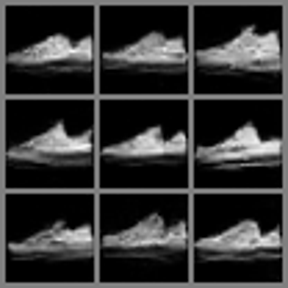

In [ ]:
model.eval()

c = fashion_encoder("sneaker", 9)
noise = torch.randn(size=(9,1,32,32)).to(device)

with torch.no_grad():
    imgs = model(noise, conditional_inputs={"context": c})

img_grid = torchvision.utils.make_grid(imgs, 3)
img = F.to_pil_image((img_grid + 1) / 2)
img.resize((288, 288))